# RLM-LSTM  Cryptocurrency Prediction

### Introduction
Cryptocurrency has always been a topic of dicussion in the forecasting realm, and many believe that it is impossible to predict Crypto prices due to their characteristic high volatility. 

In this notebook, I try to use a RLM-LSTM model to try and predict cryptocurrency prices and demonstrate its practicality by implementing a trading strategy using the predictions.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.api as stats
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint as cointegration
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm_notebook as tqdm
from arch import arch_model as ARCH
from scipy import fftpack
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    TimeDistributed,
    Flatten,
)
from functions import *
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use("seaborn")
plt.rcParams["font.family"] = "Times New Roman"


In [2]:

crypto = pd.read_csv(r'data/Binance Coin Historical Data - Investing.com.csv',index_col='Date')
index = []

for date in crypto.index:
    index.append(dt.datetime.strptime(date,'%b %d, %Y'))

crypto.index = index
crypto.sort_index(inplace=True)


In [3]:
crypto = crypto[:-70]

### Exploratory Data Analysis

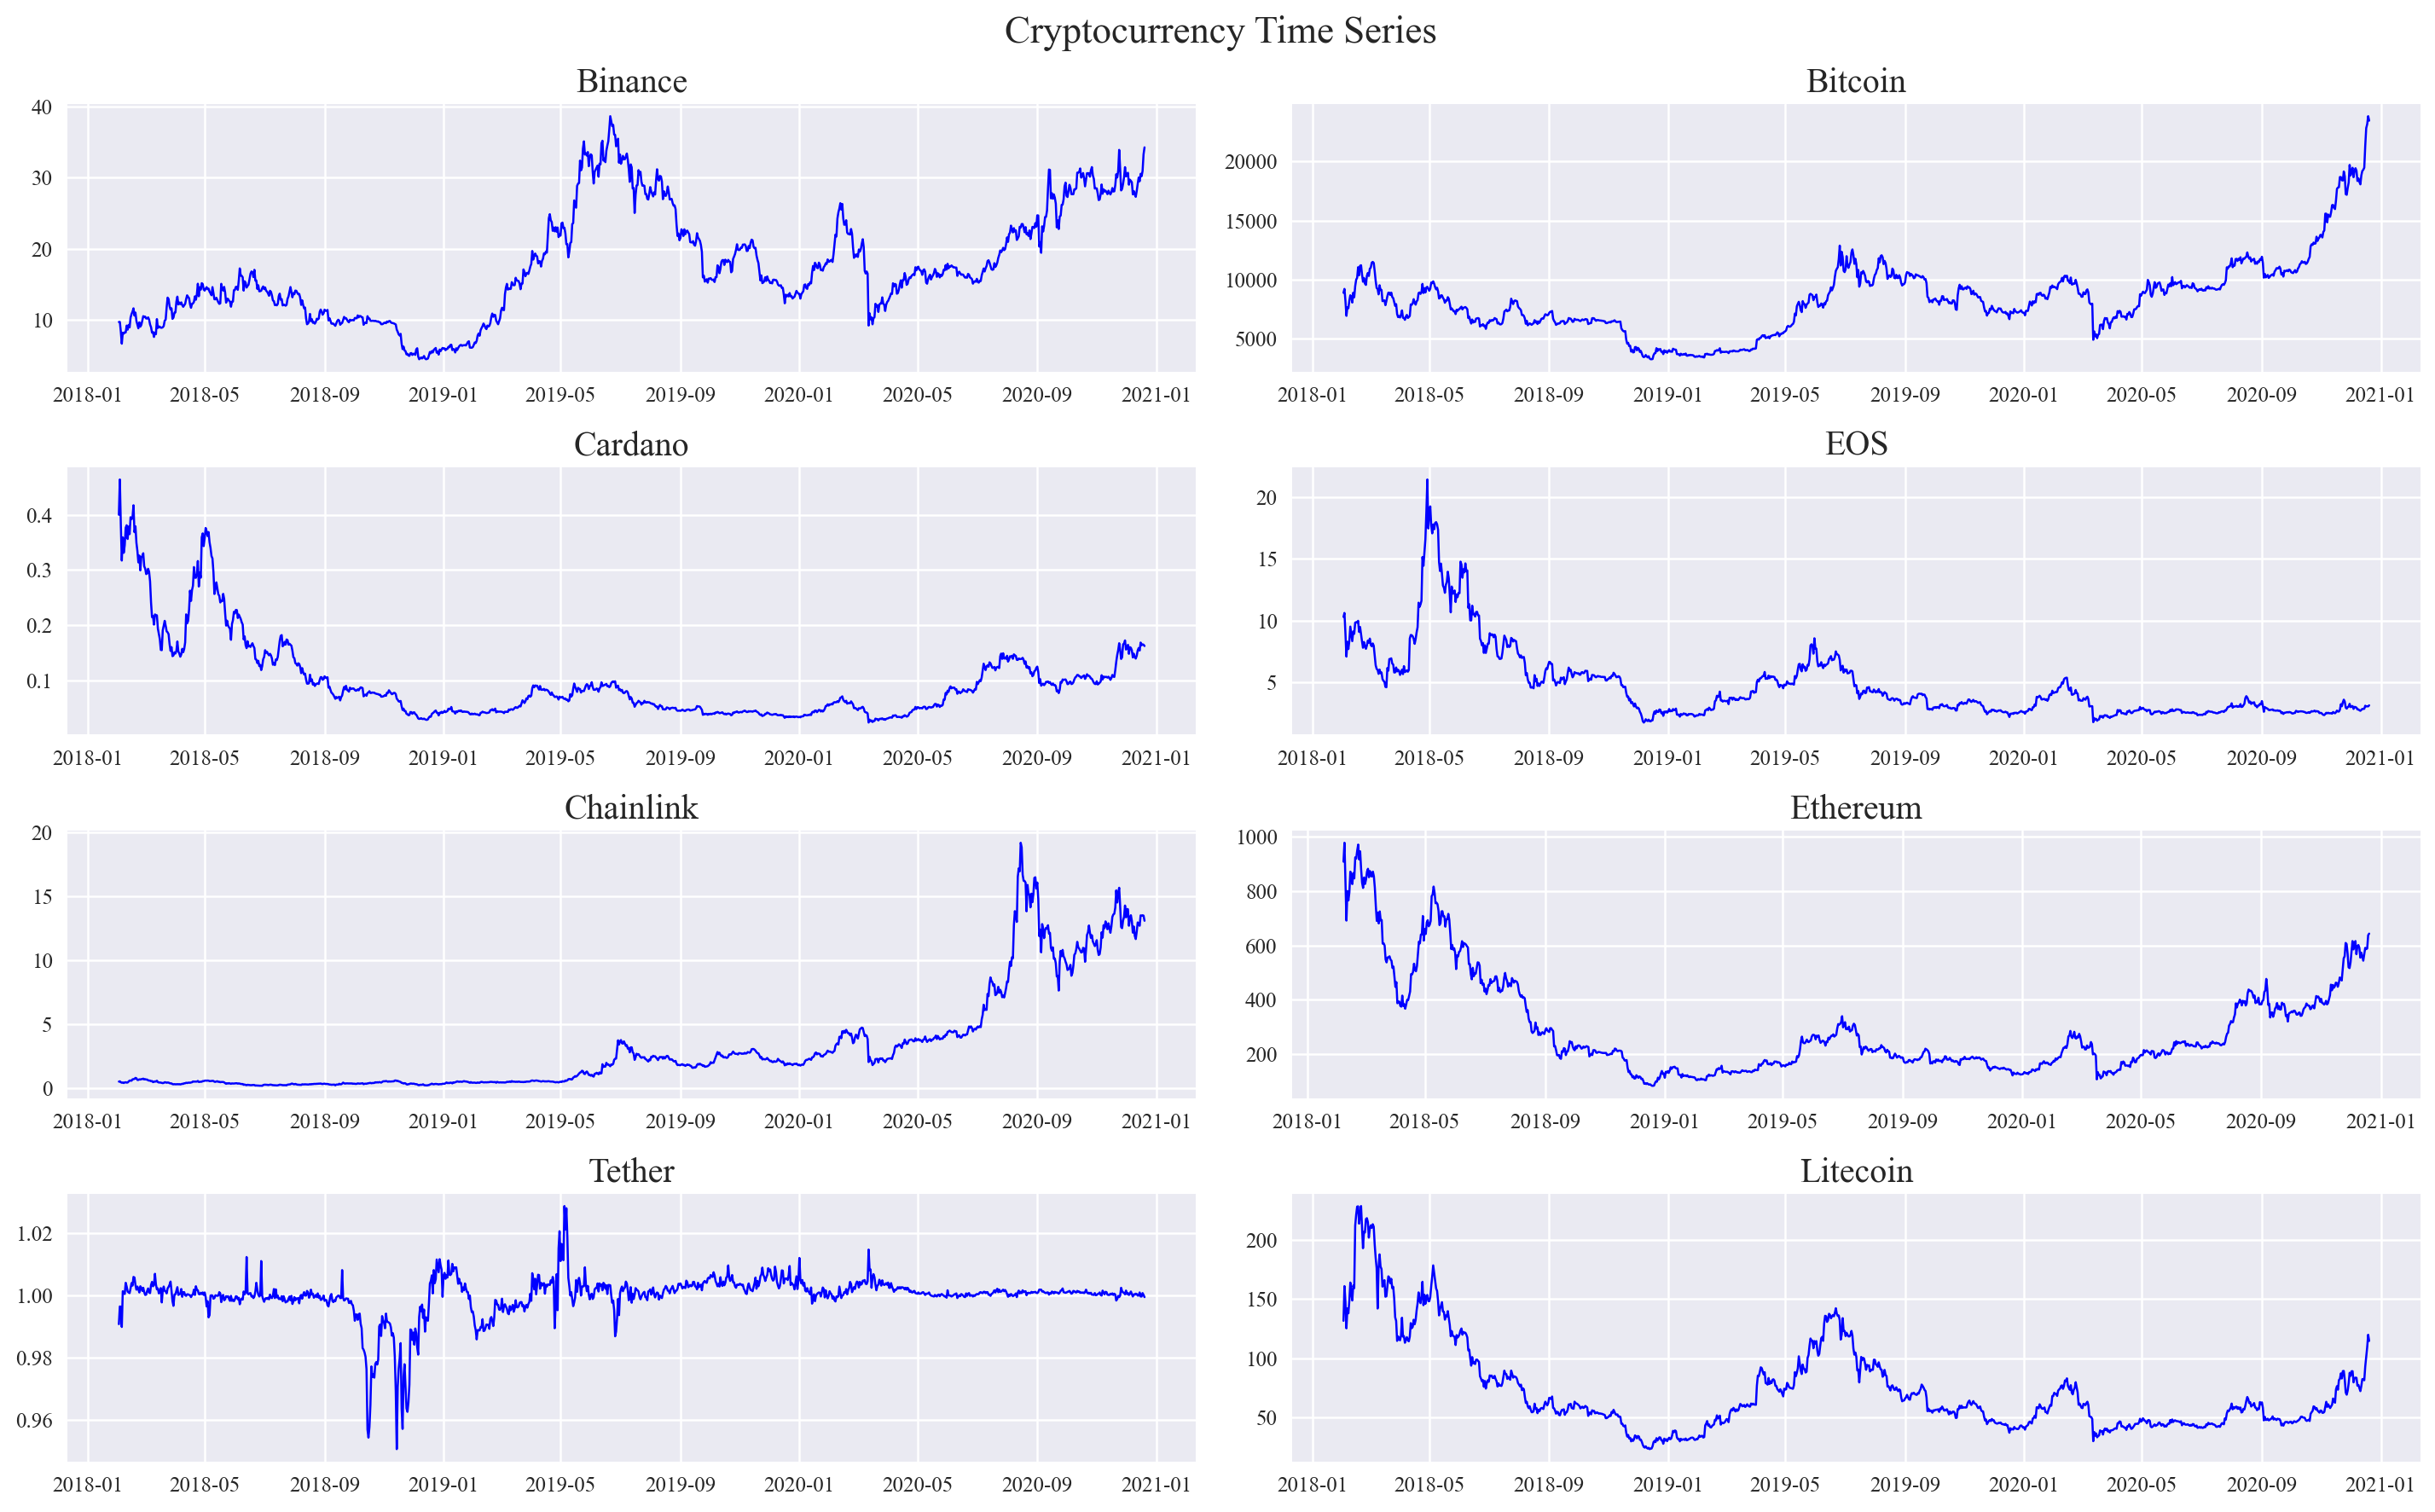

In [4]:
plot_timeseries(crypto)

As is visible above, if the reader were to look closely, they would see that all four cryptocurrencies have surges at similar time periods and it might be possible to predict one cryptocurrency price if we know the price of another

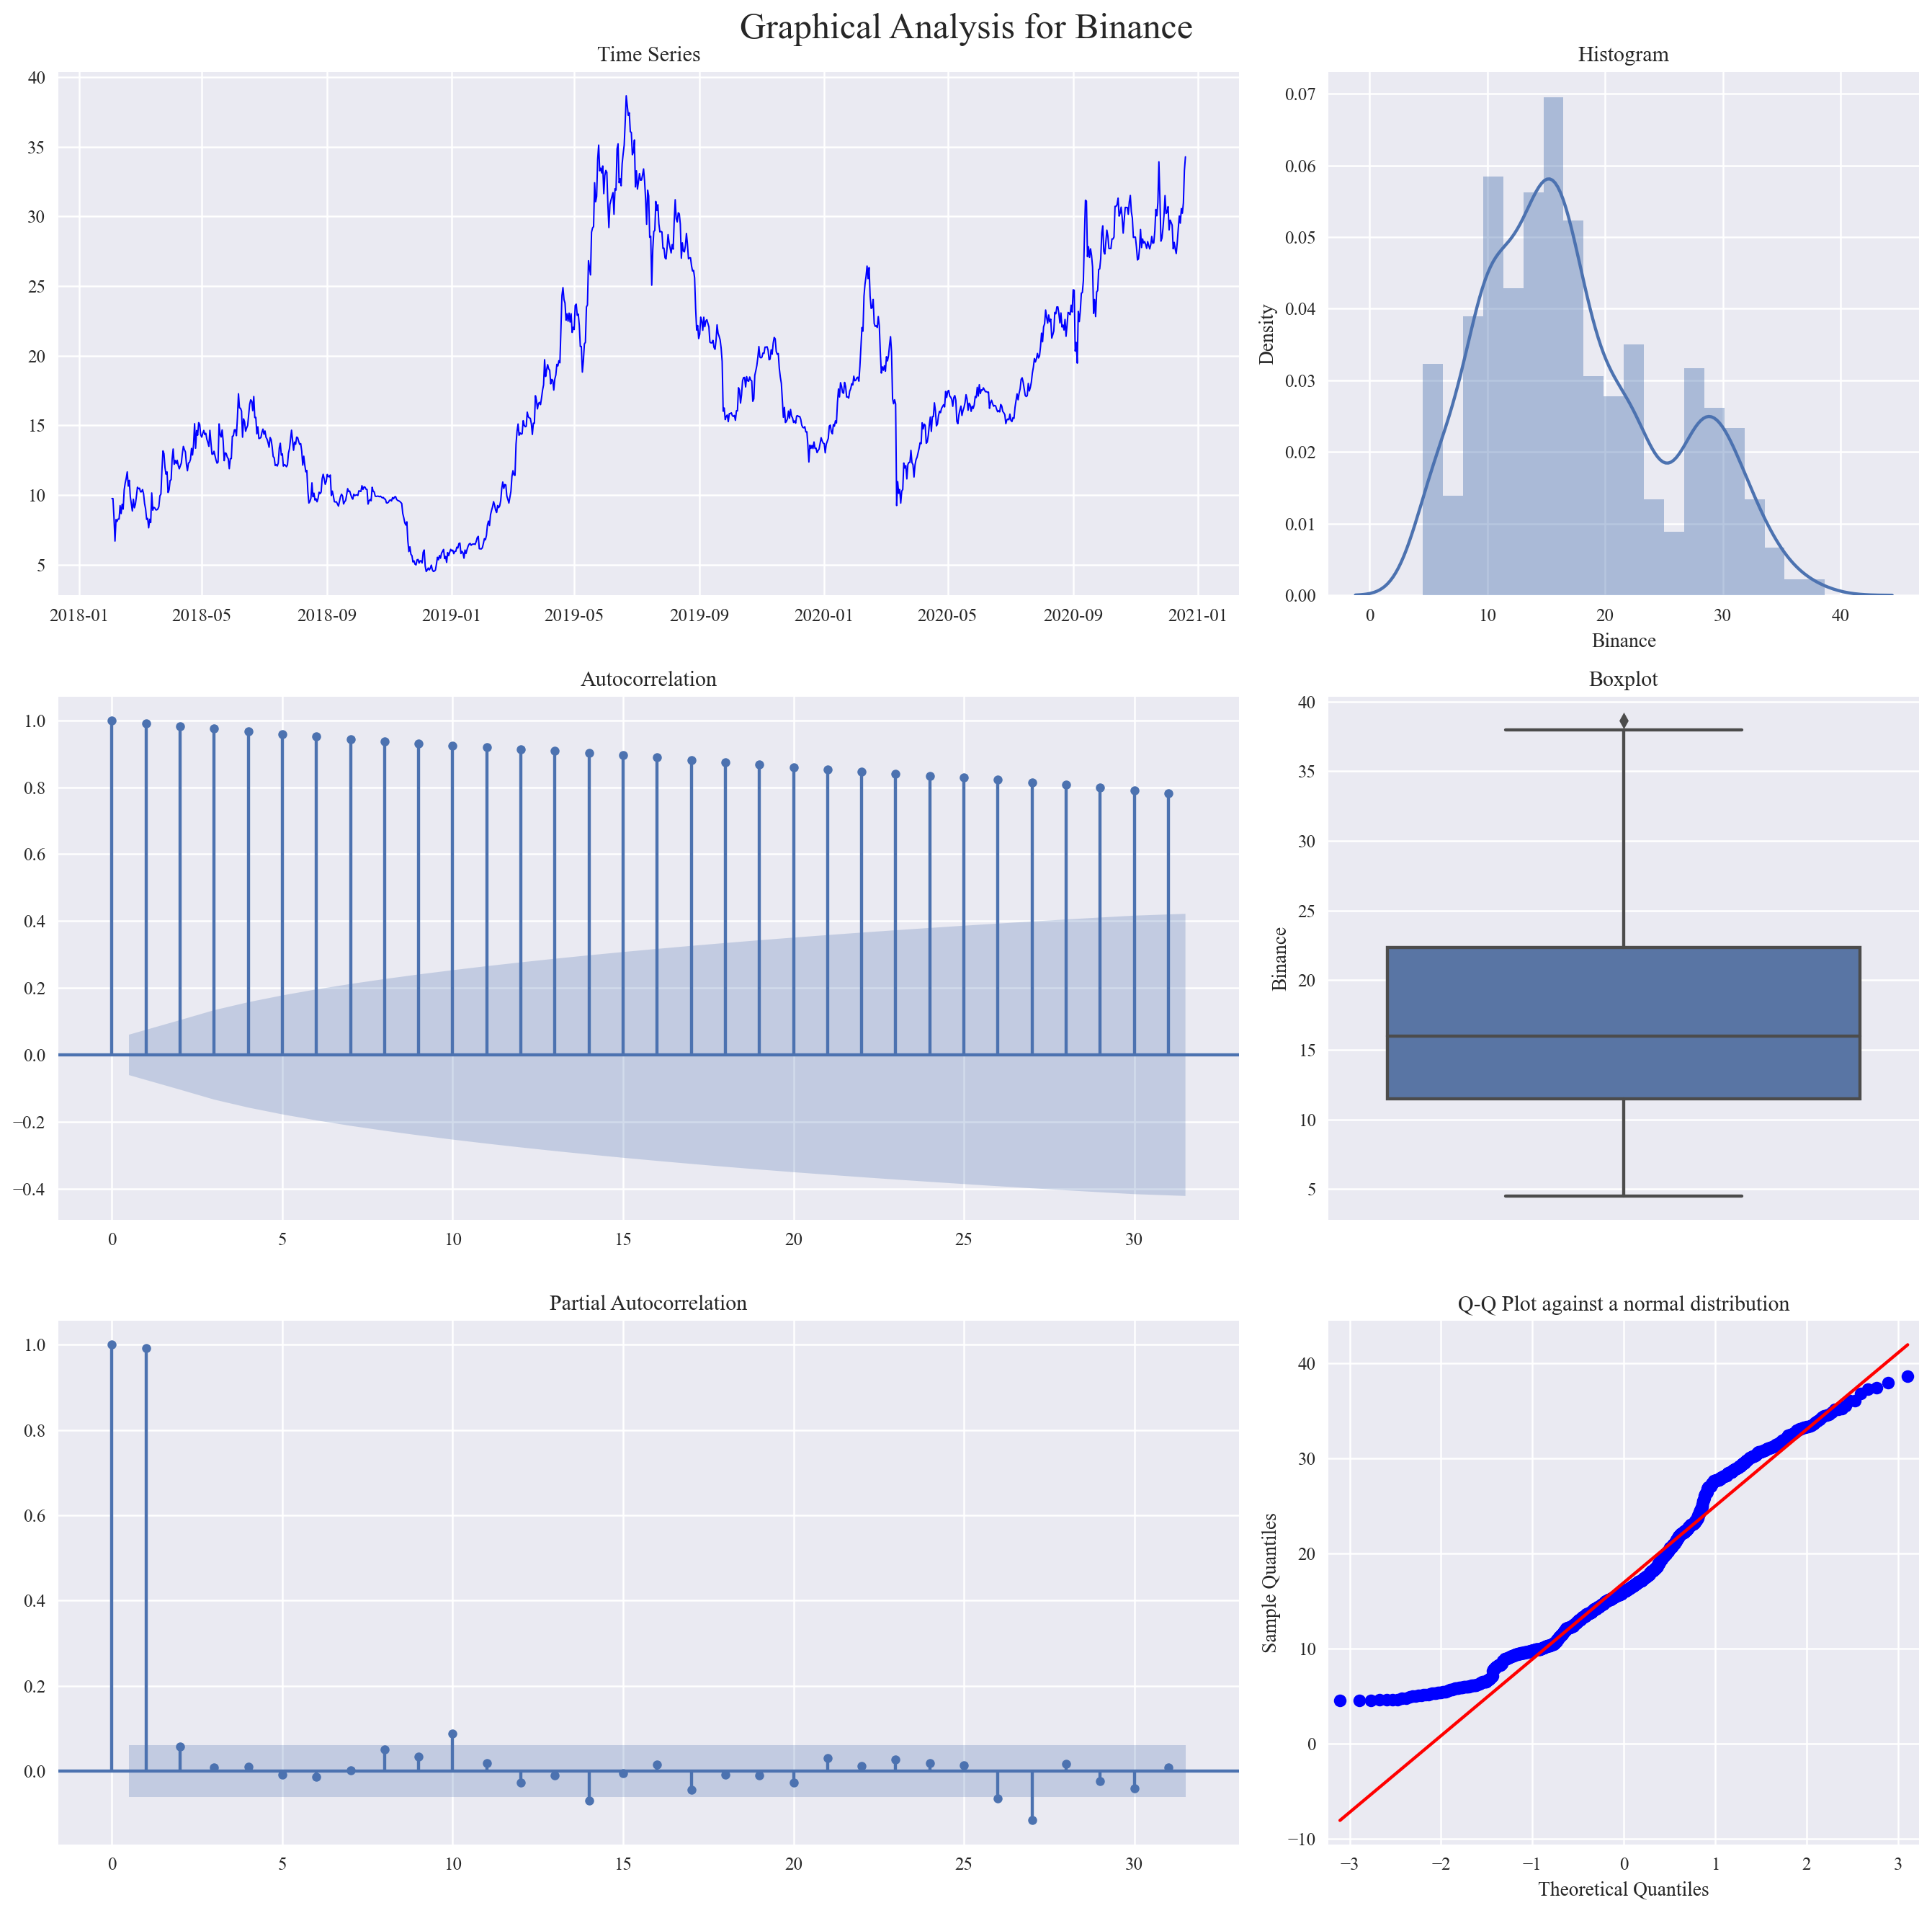

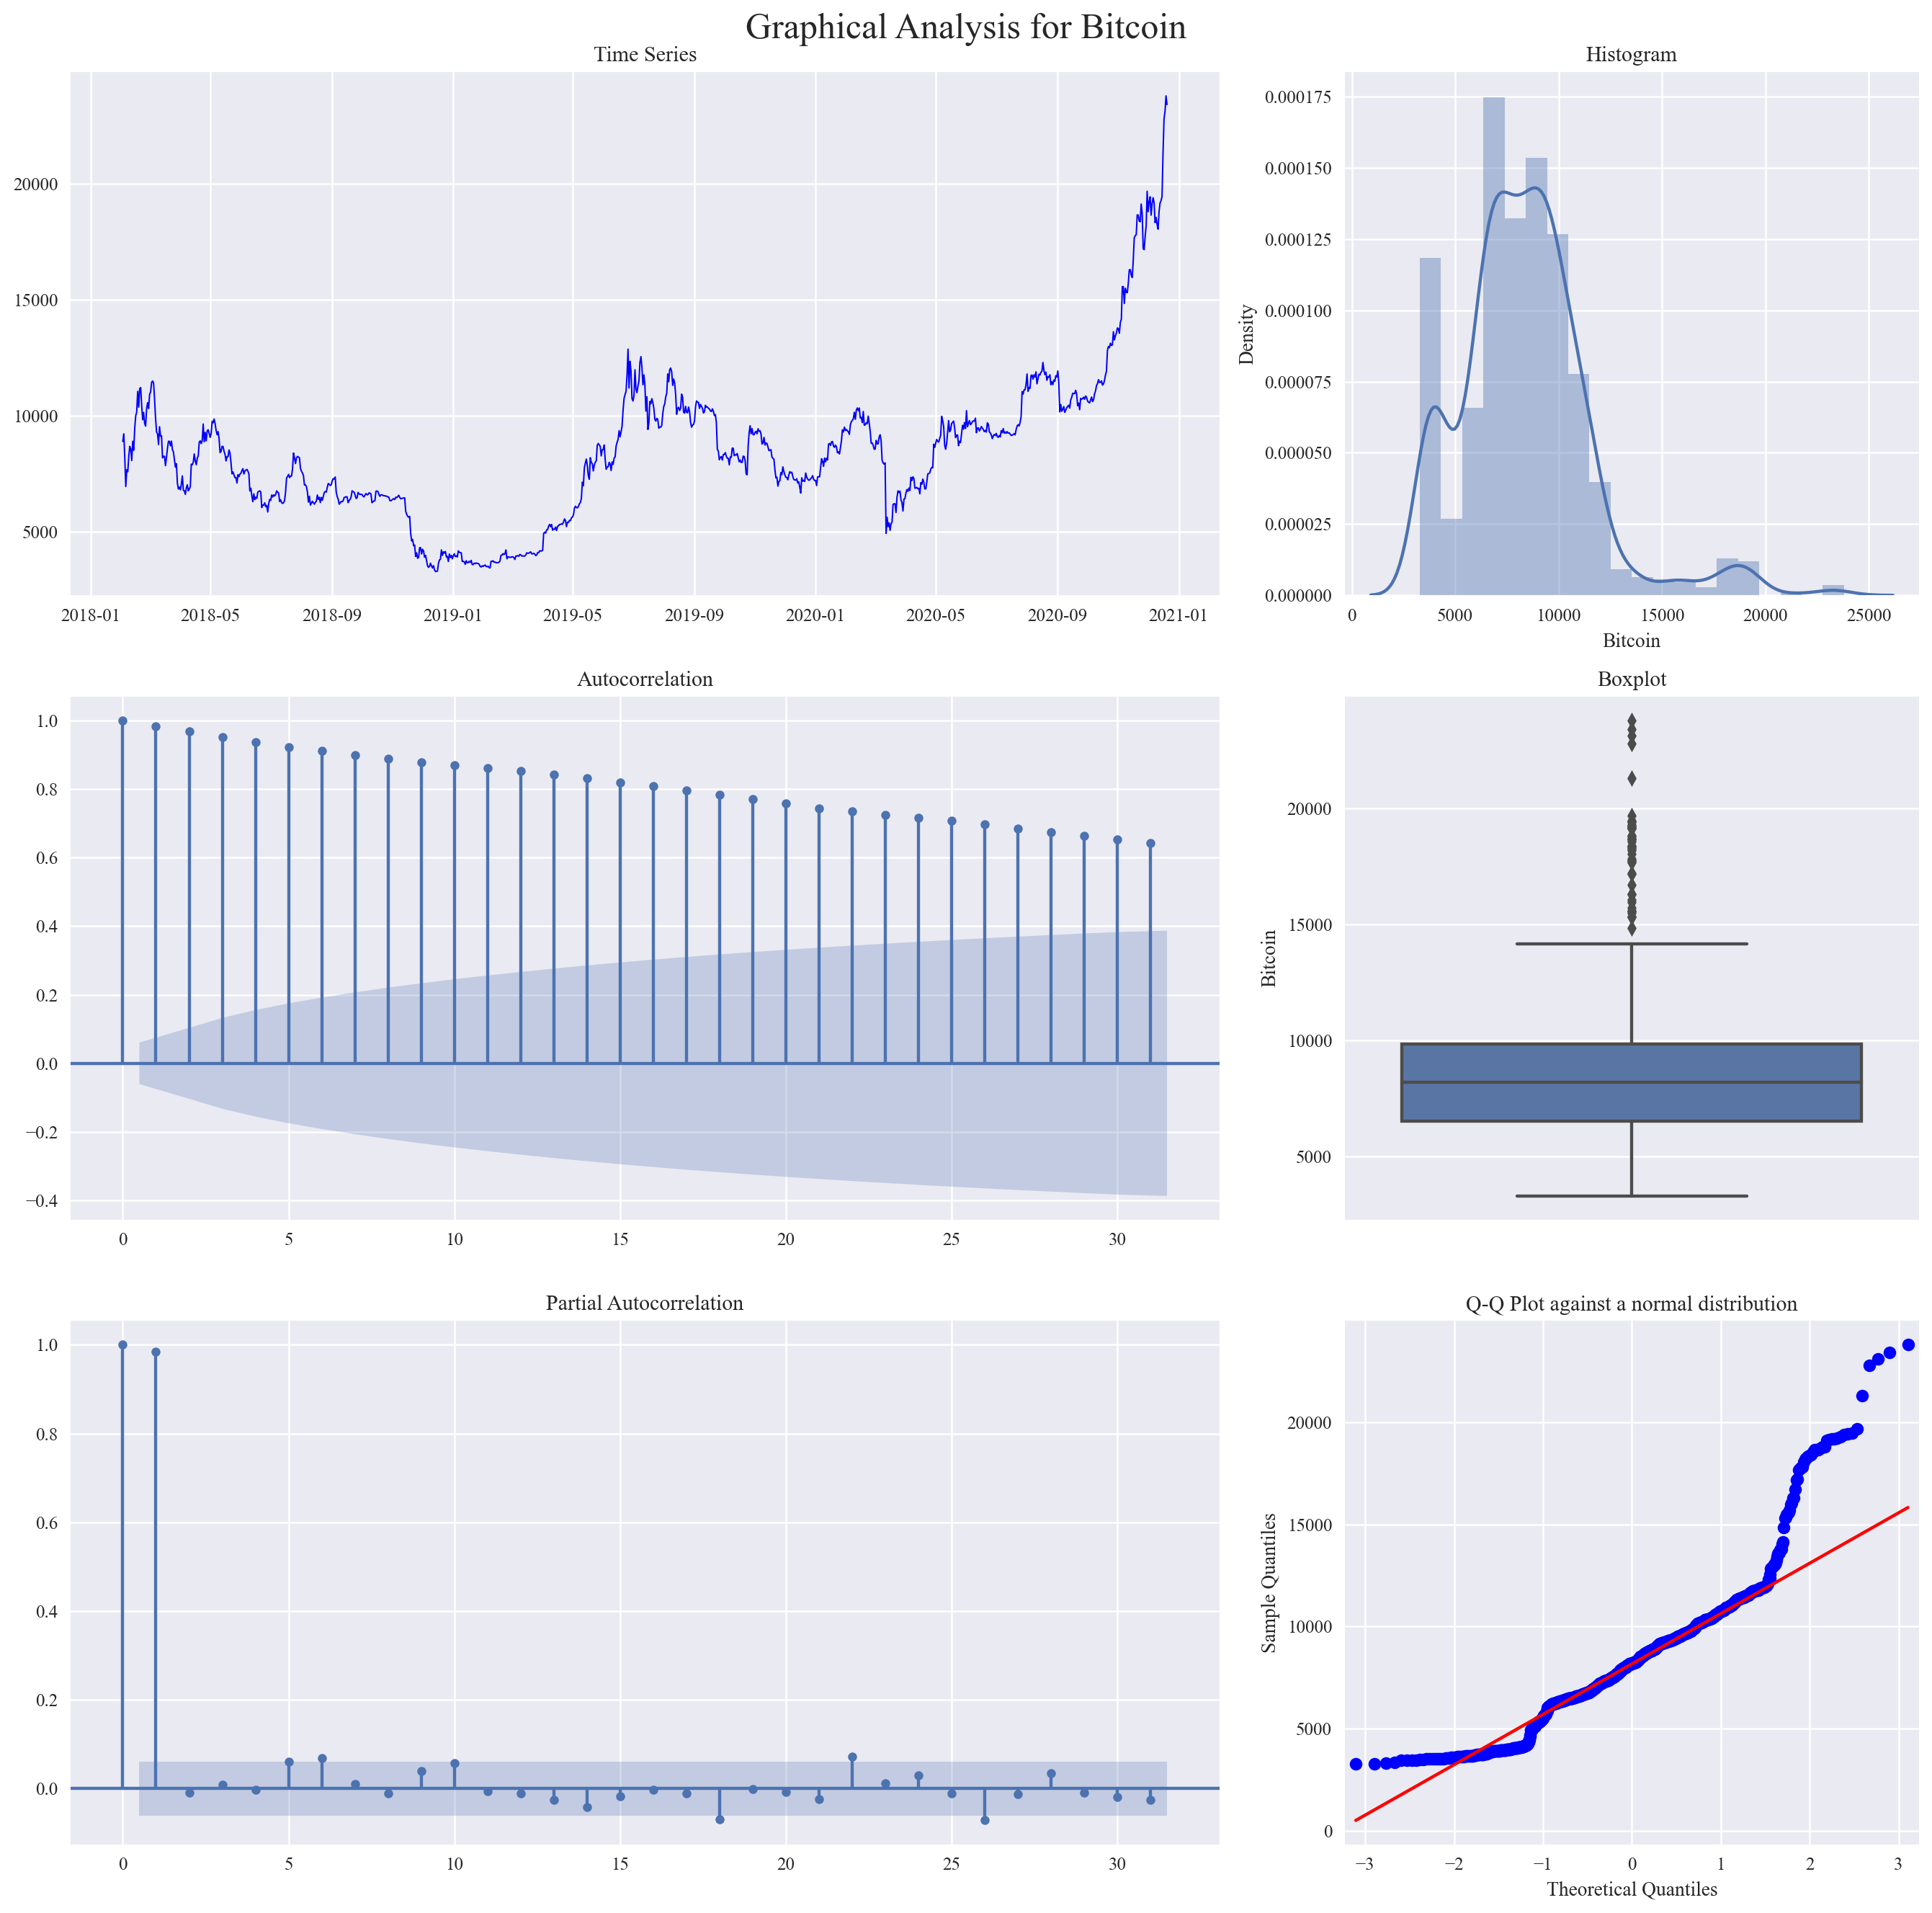

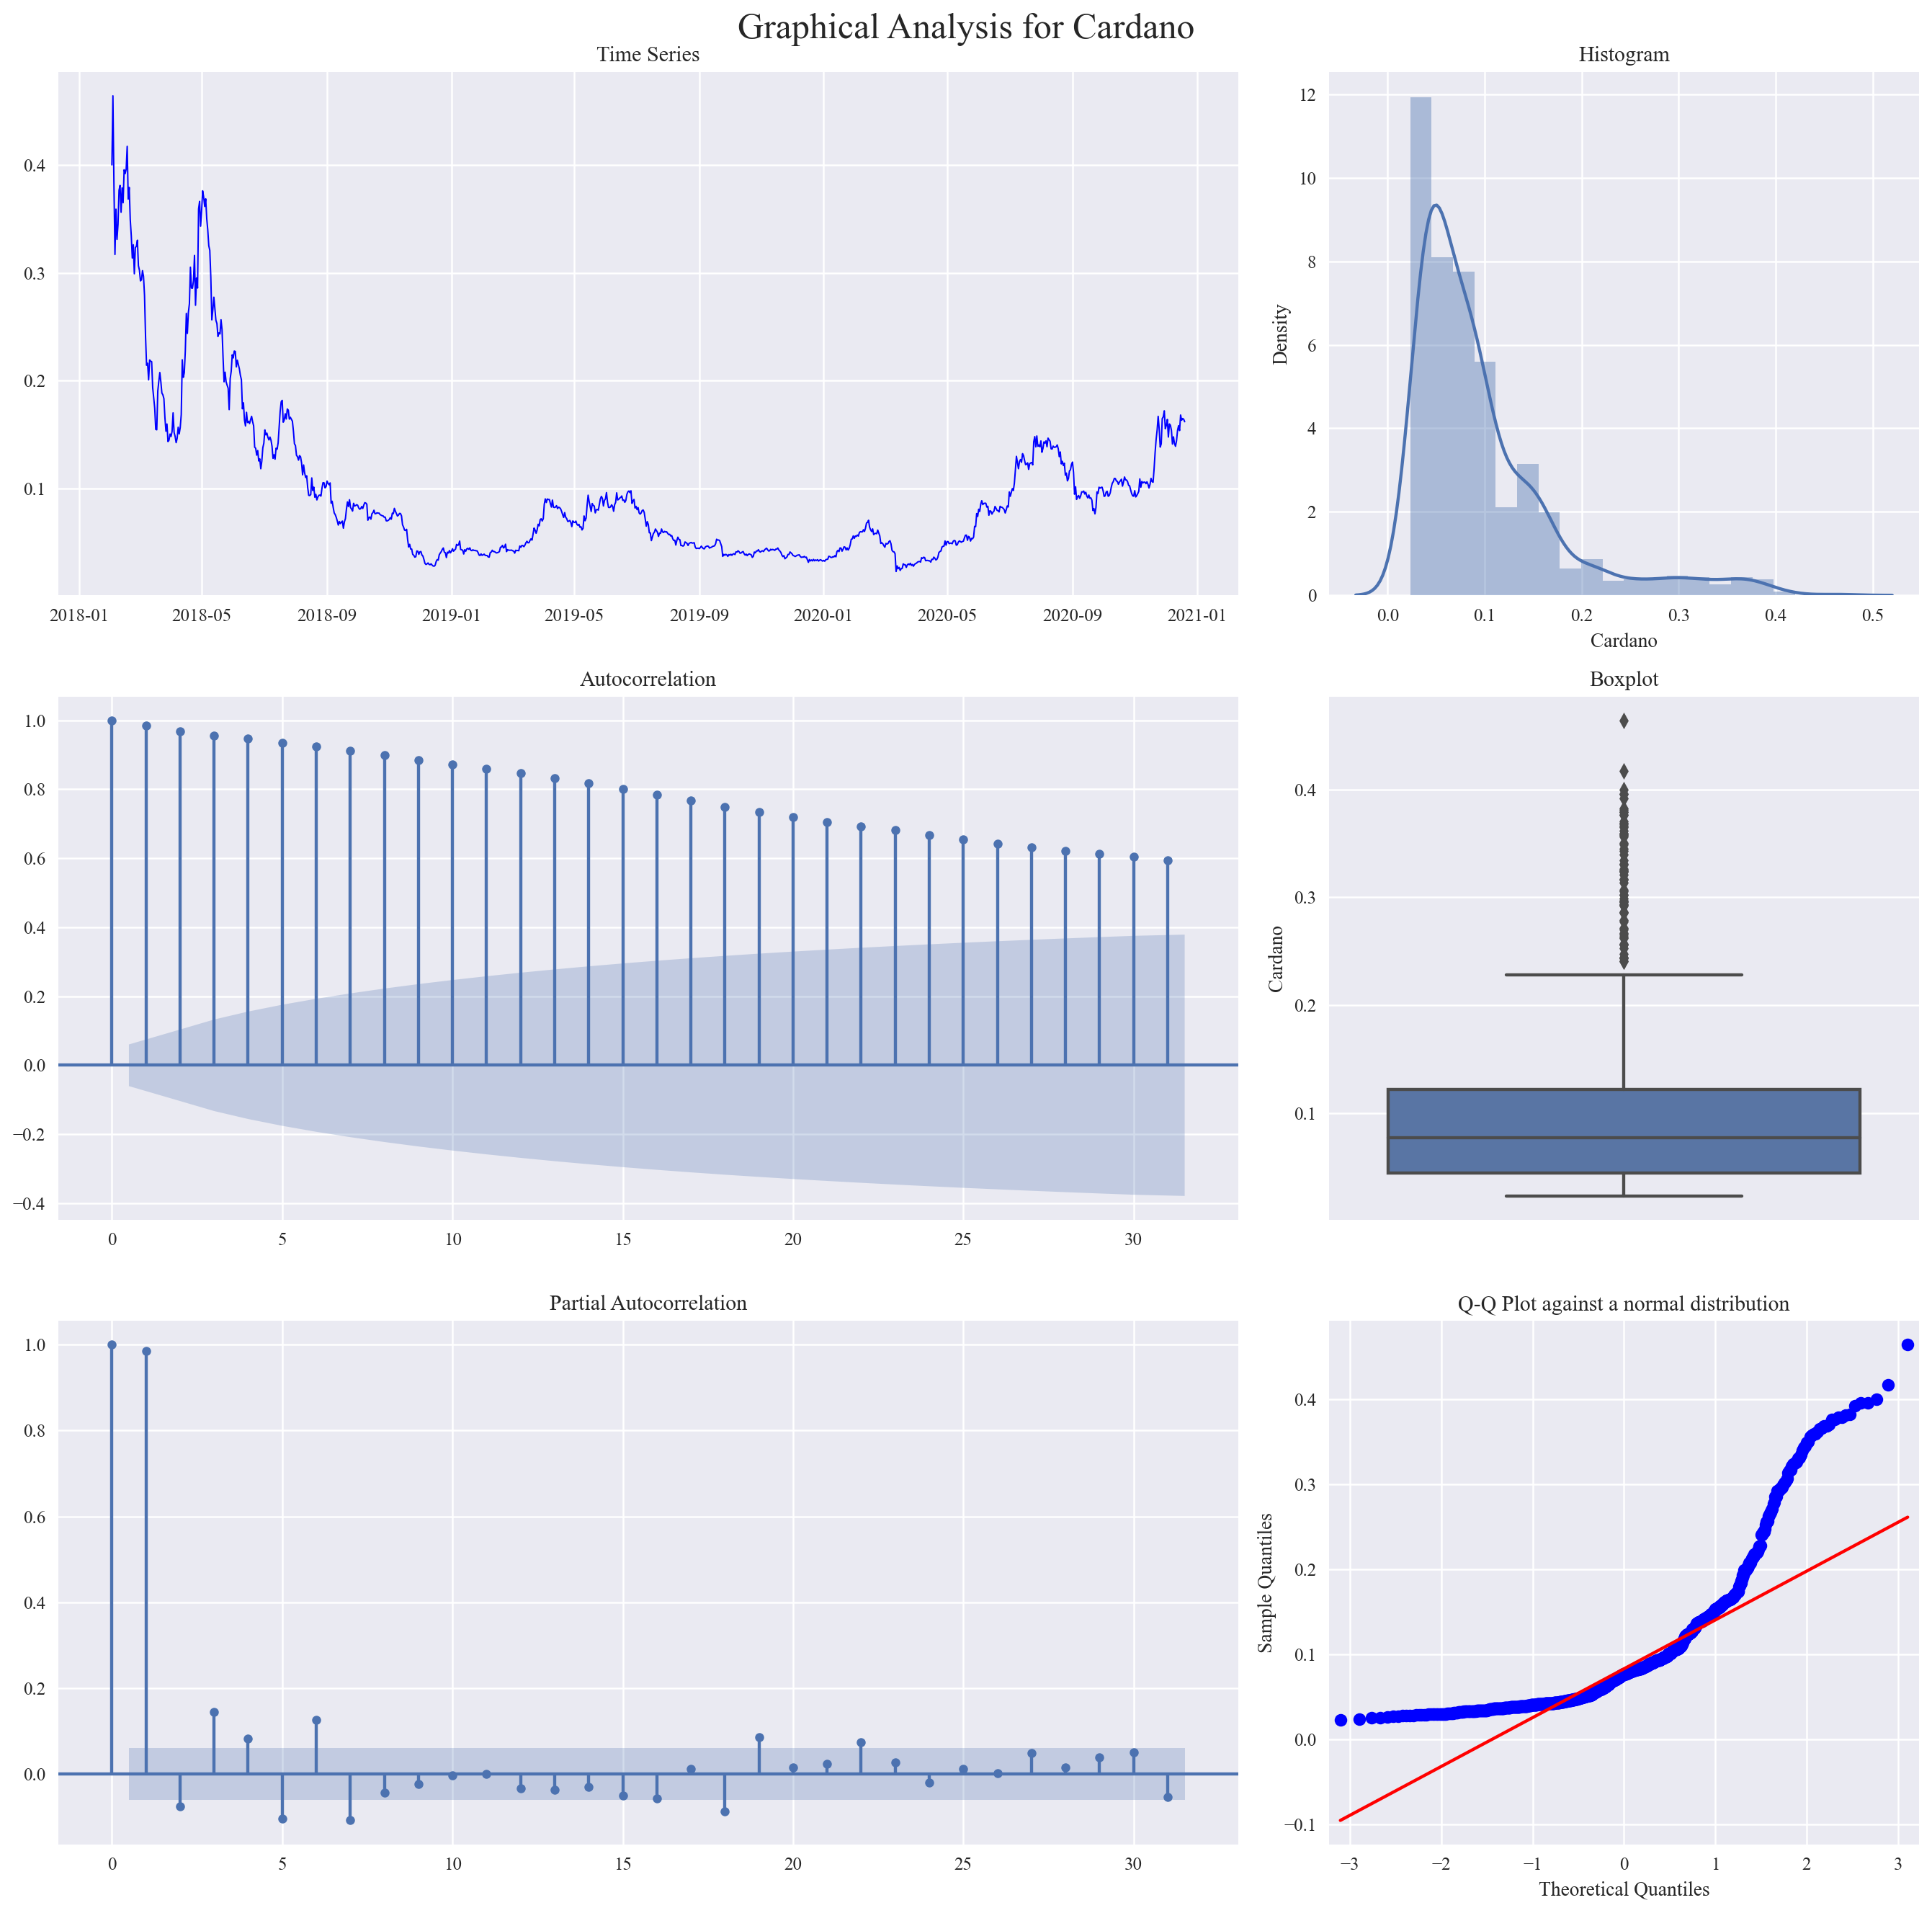

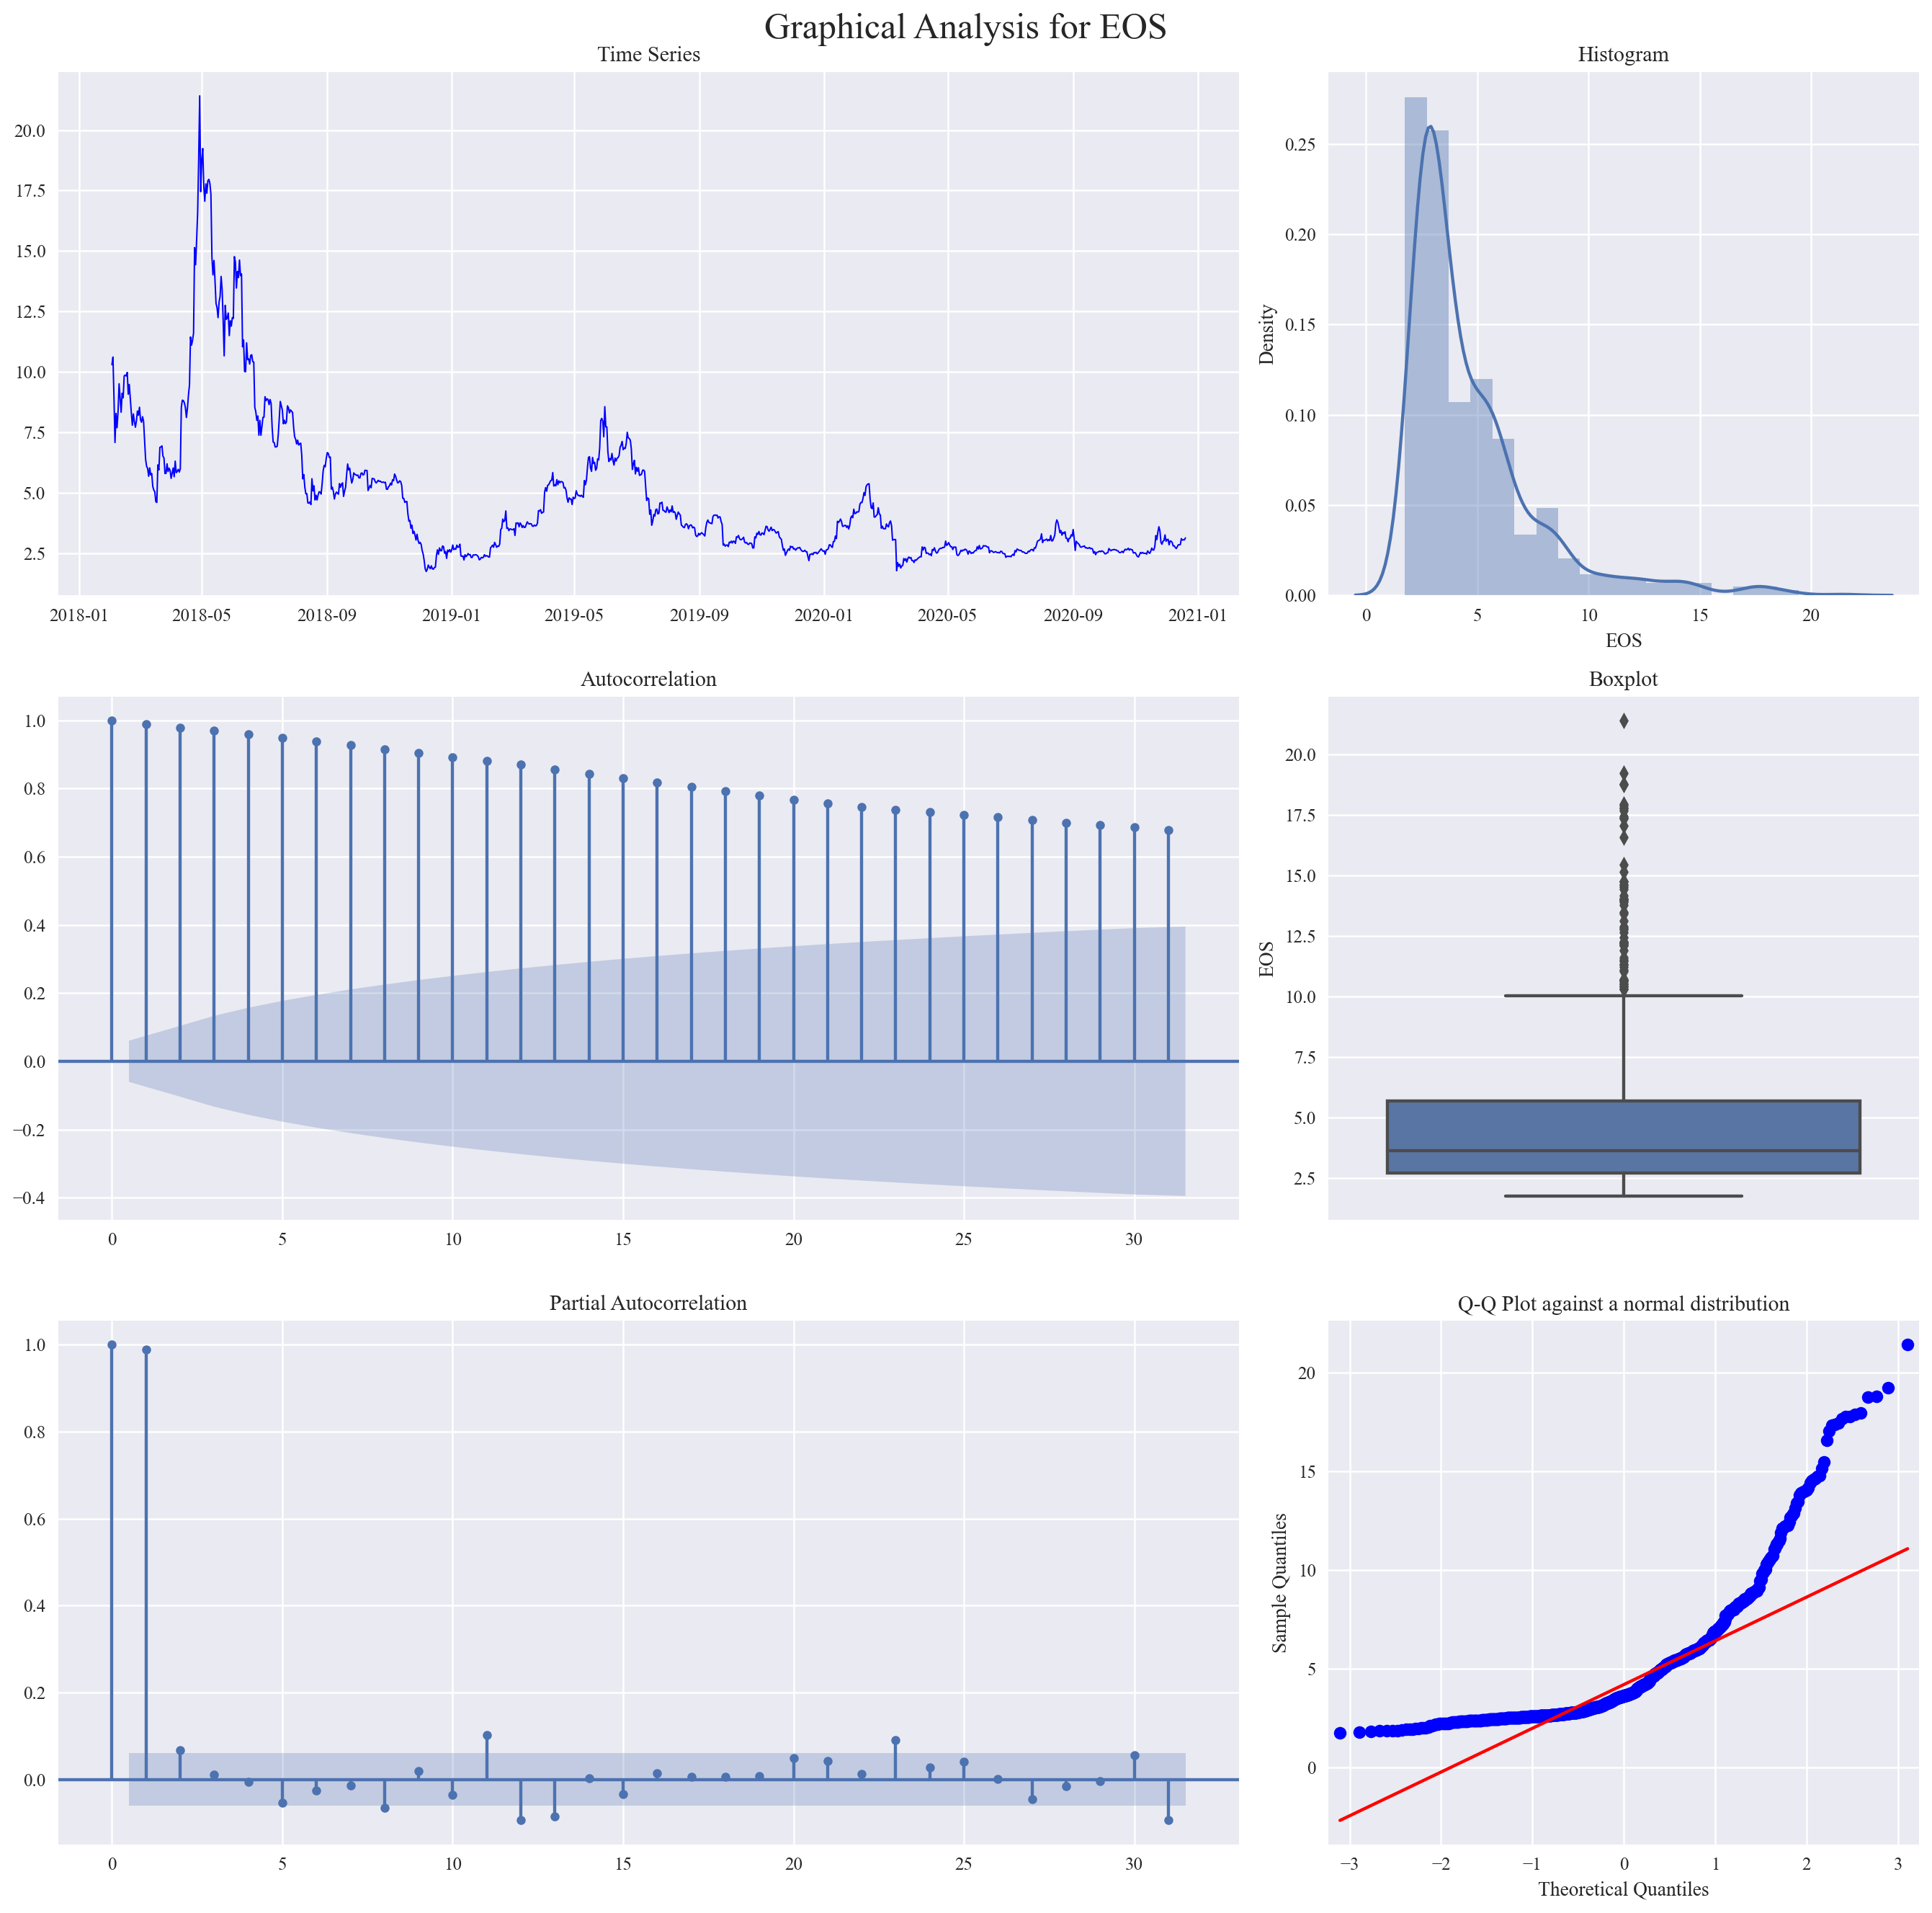

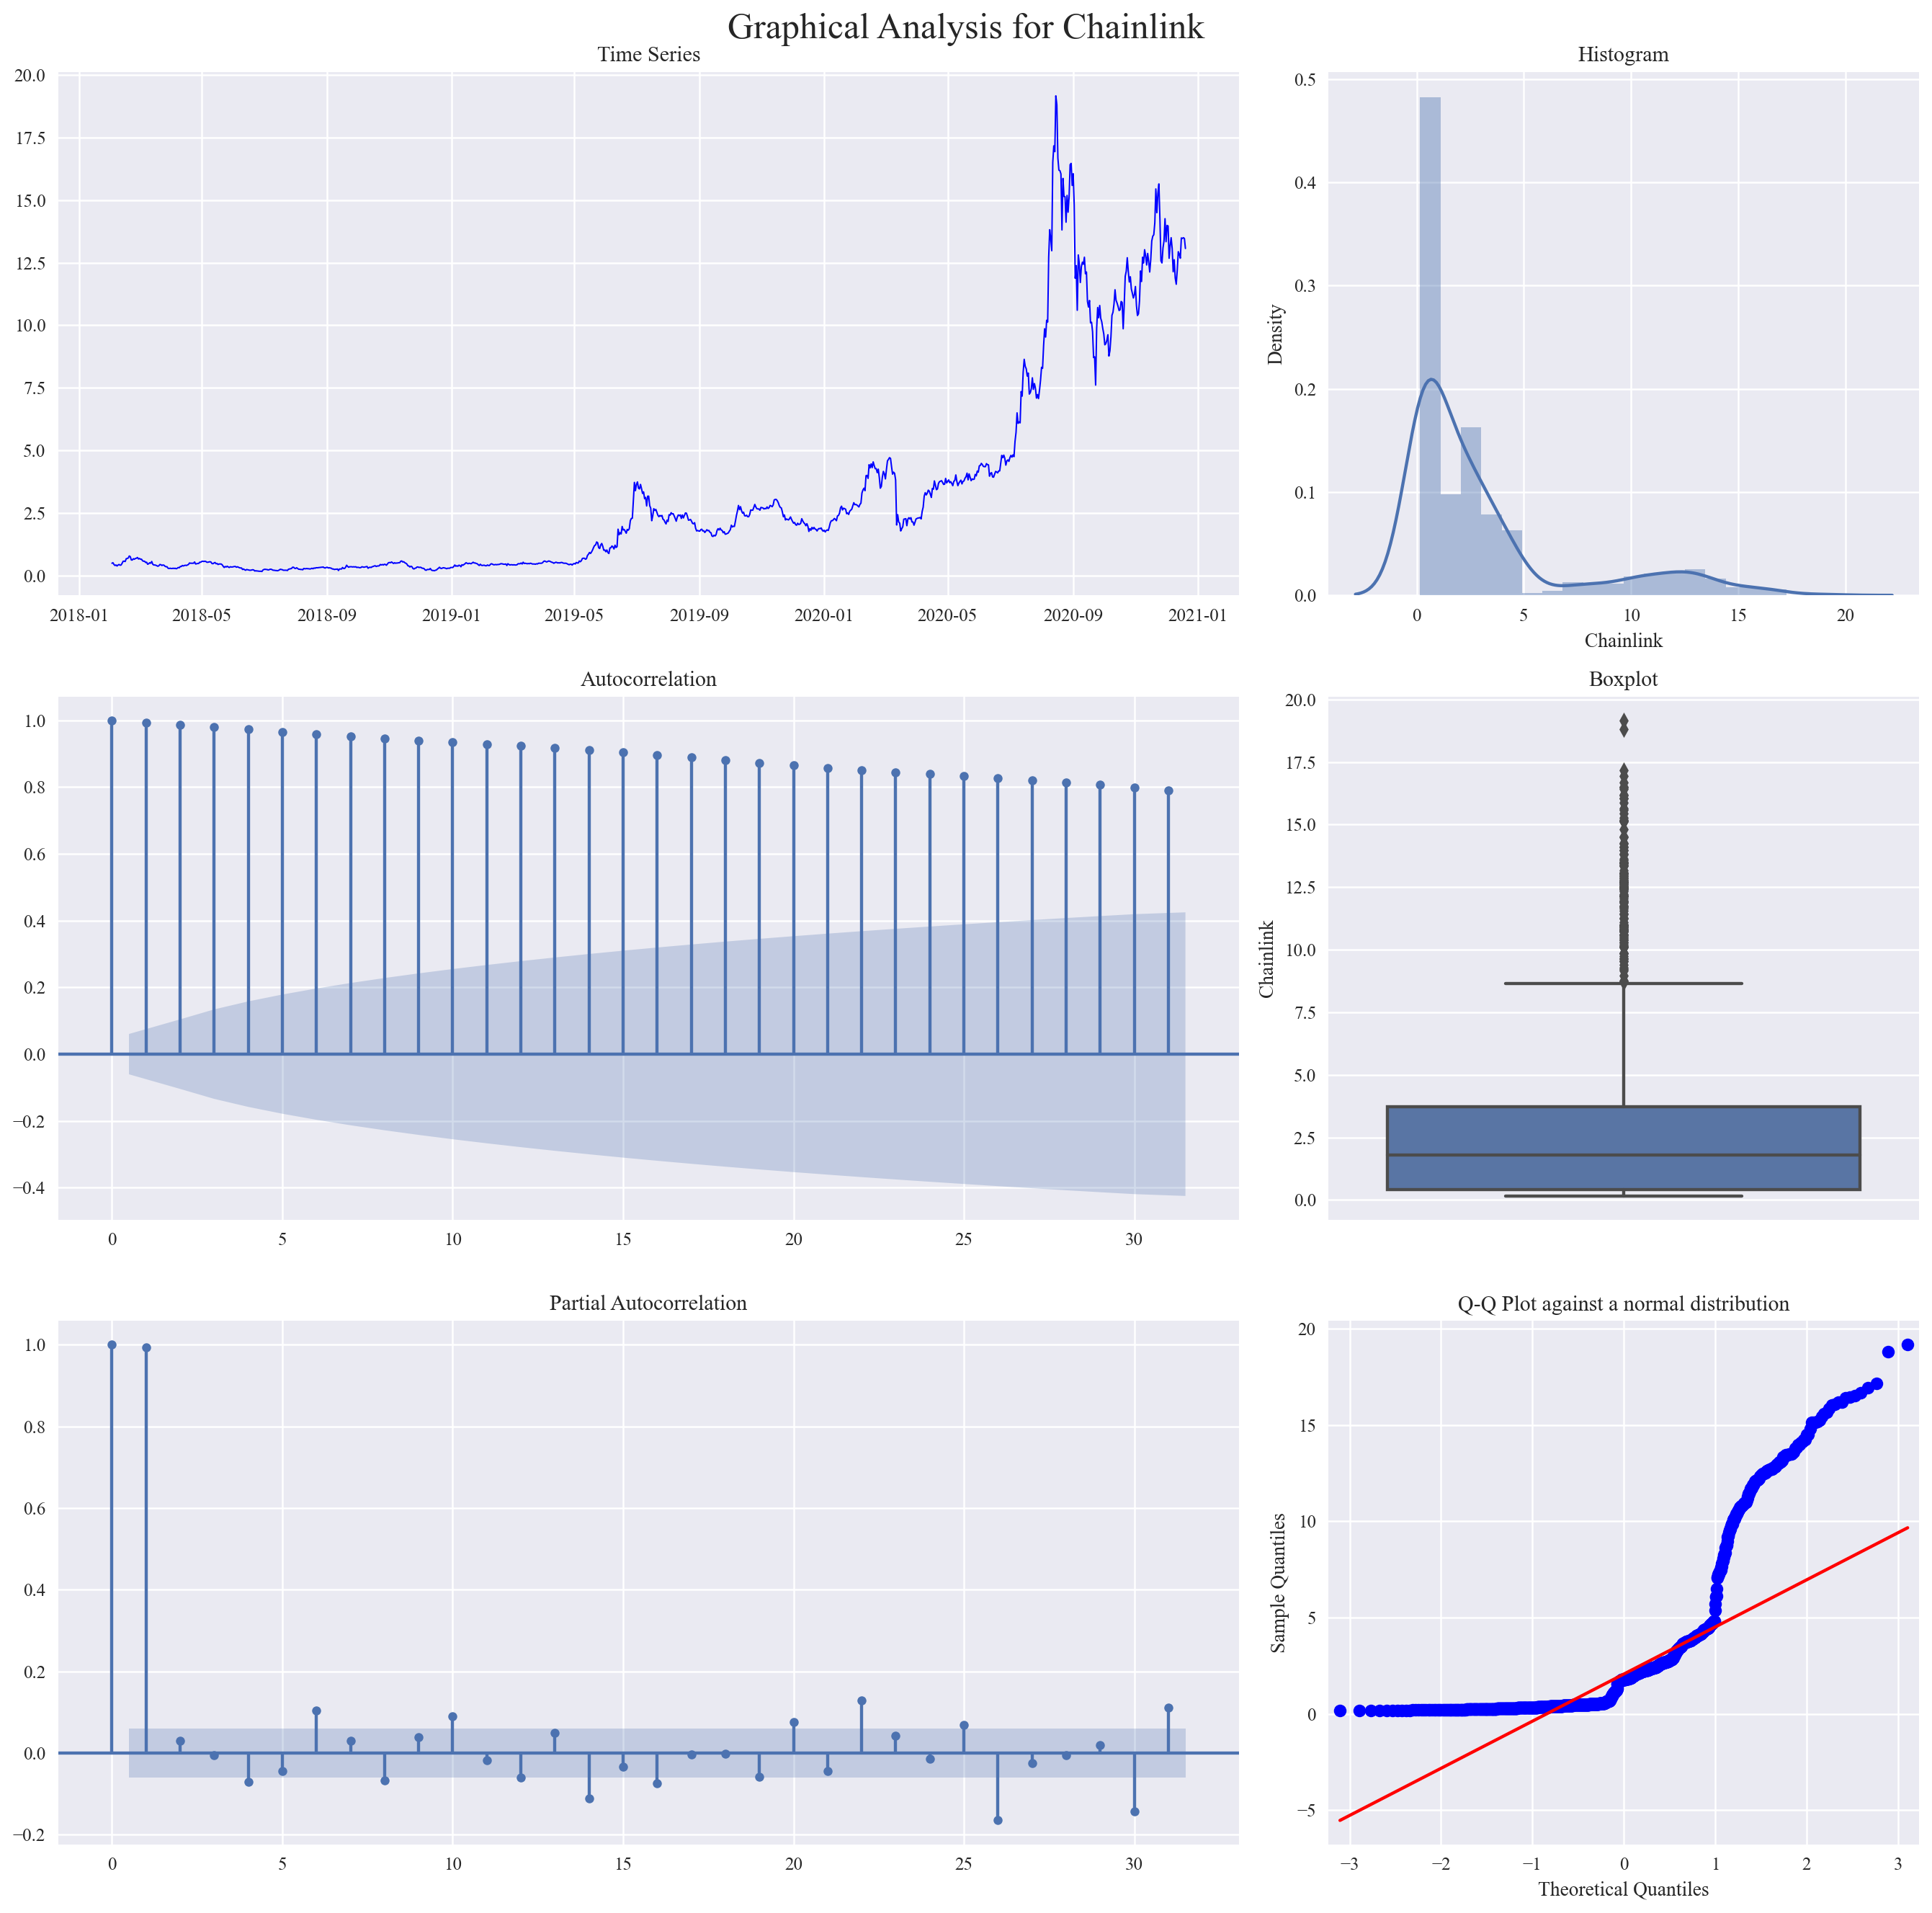

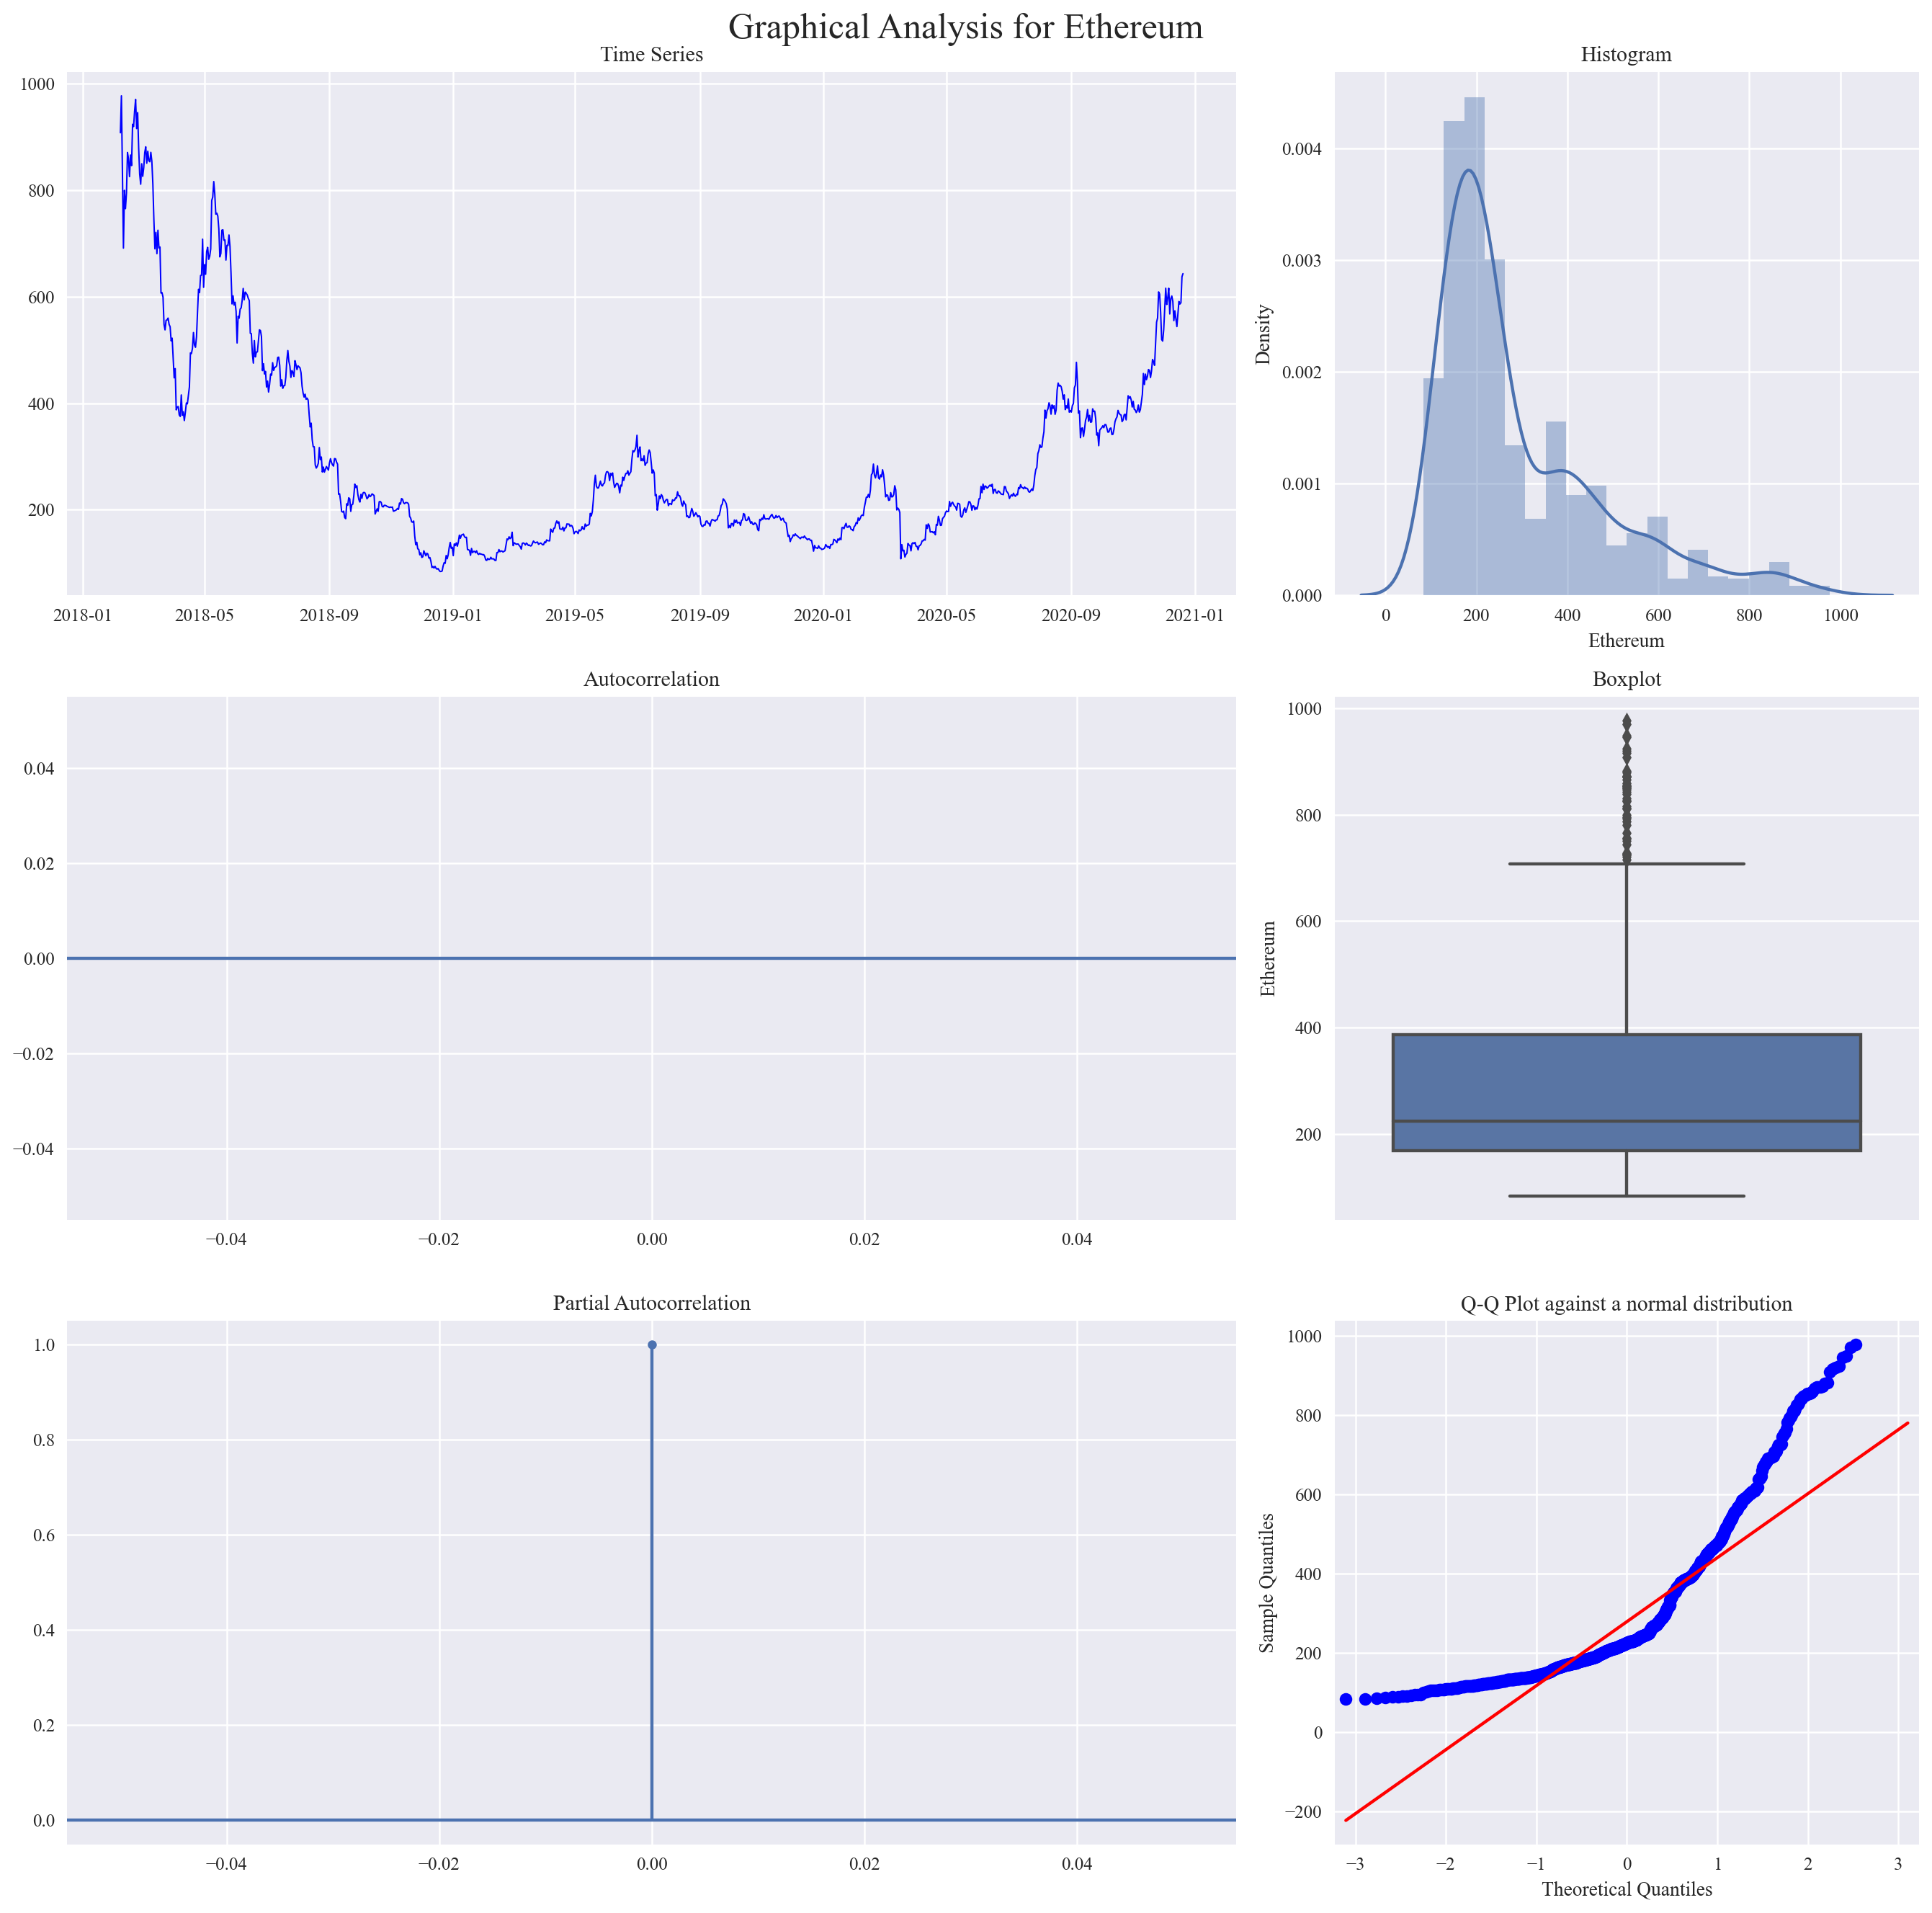

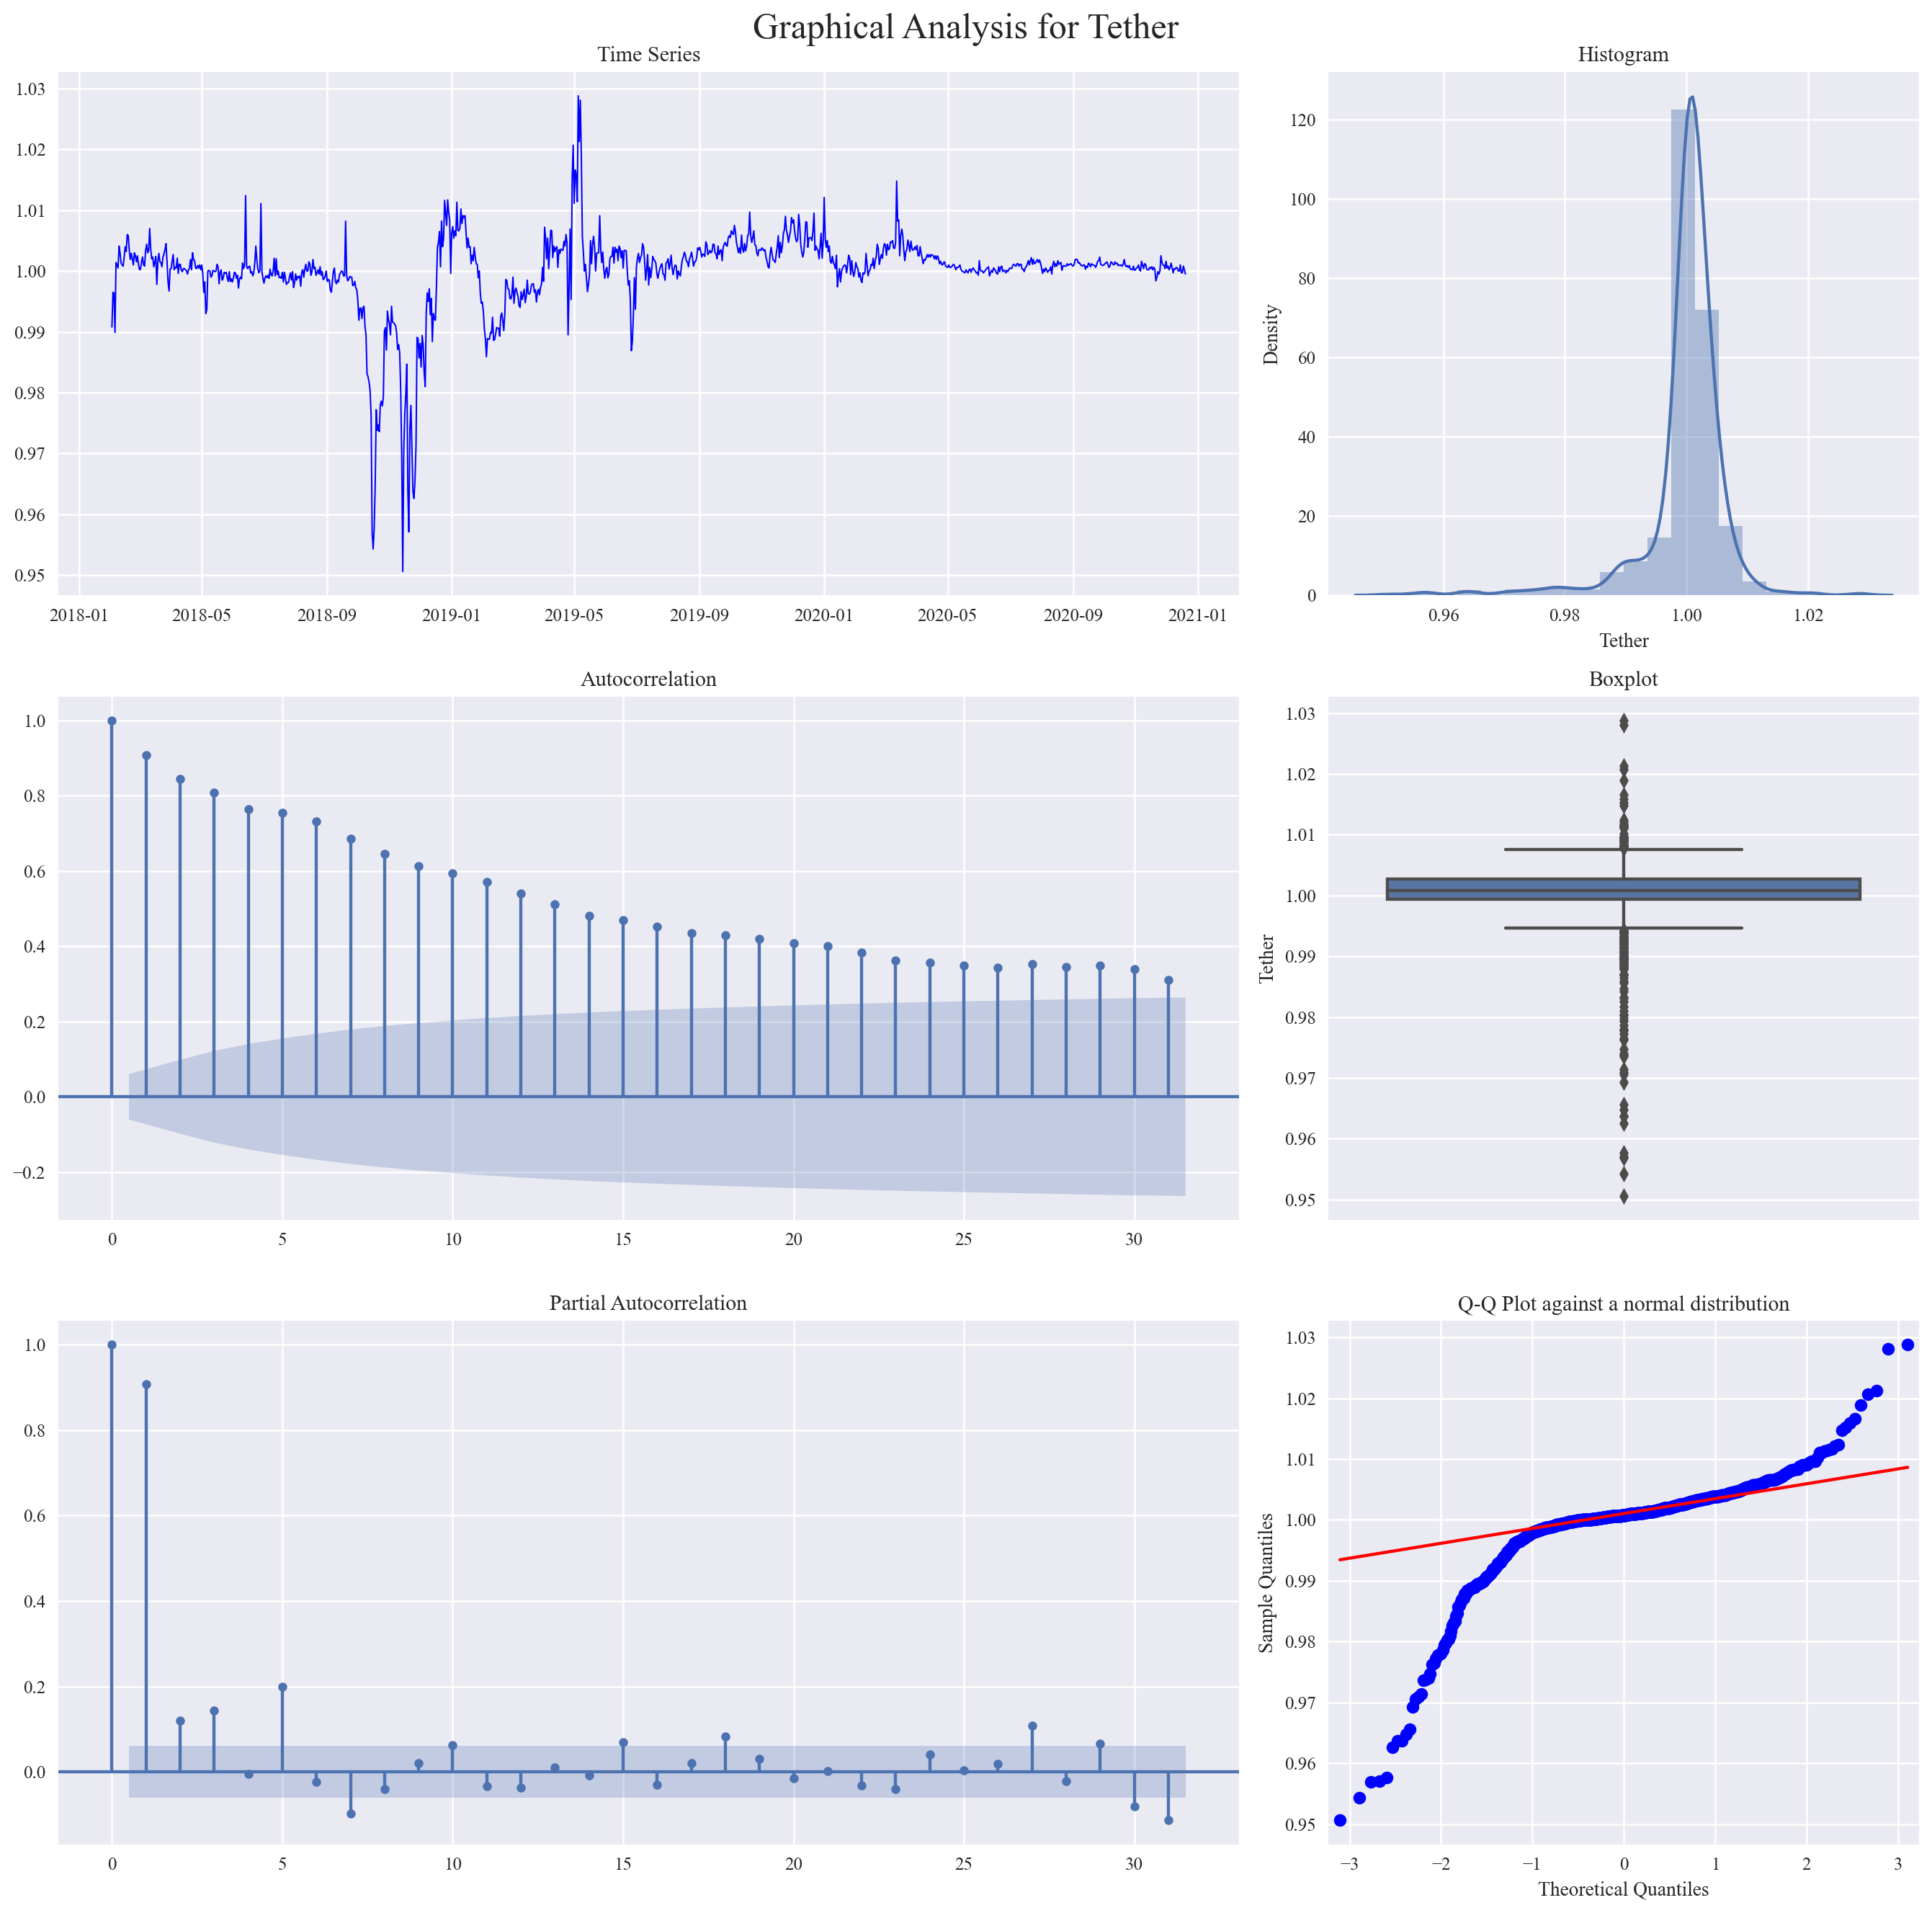

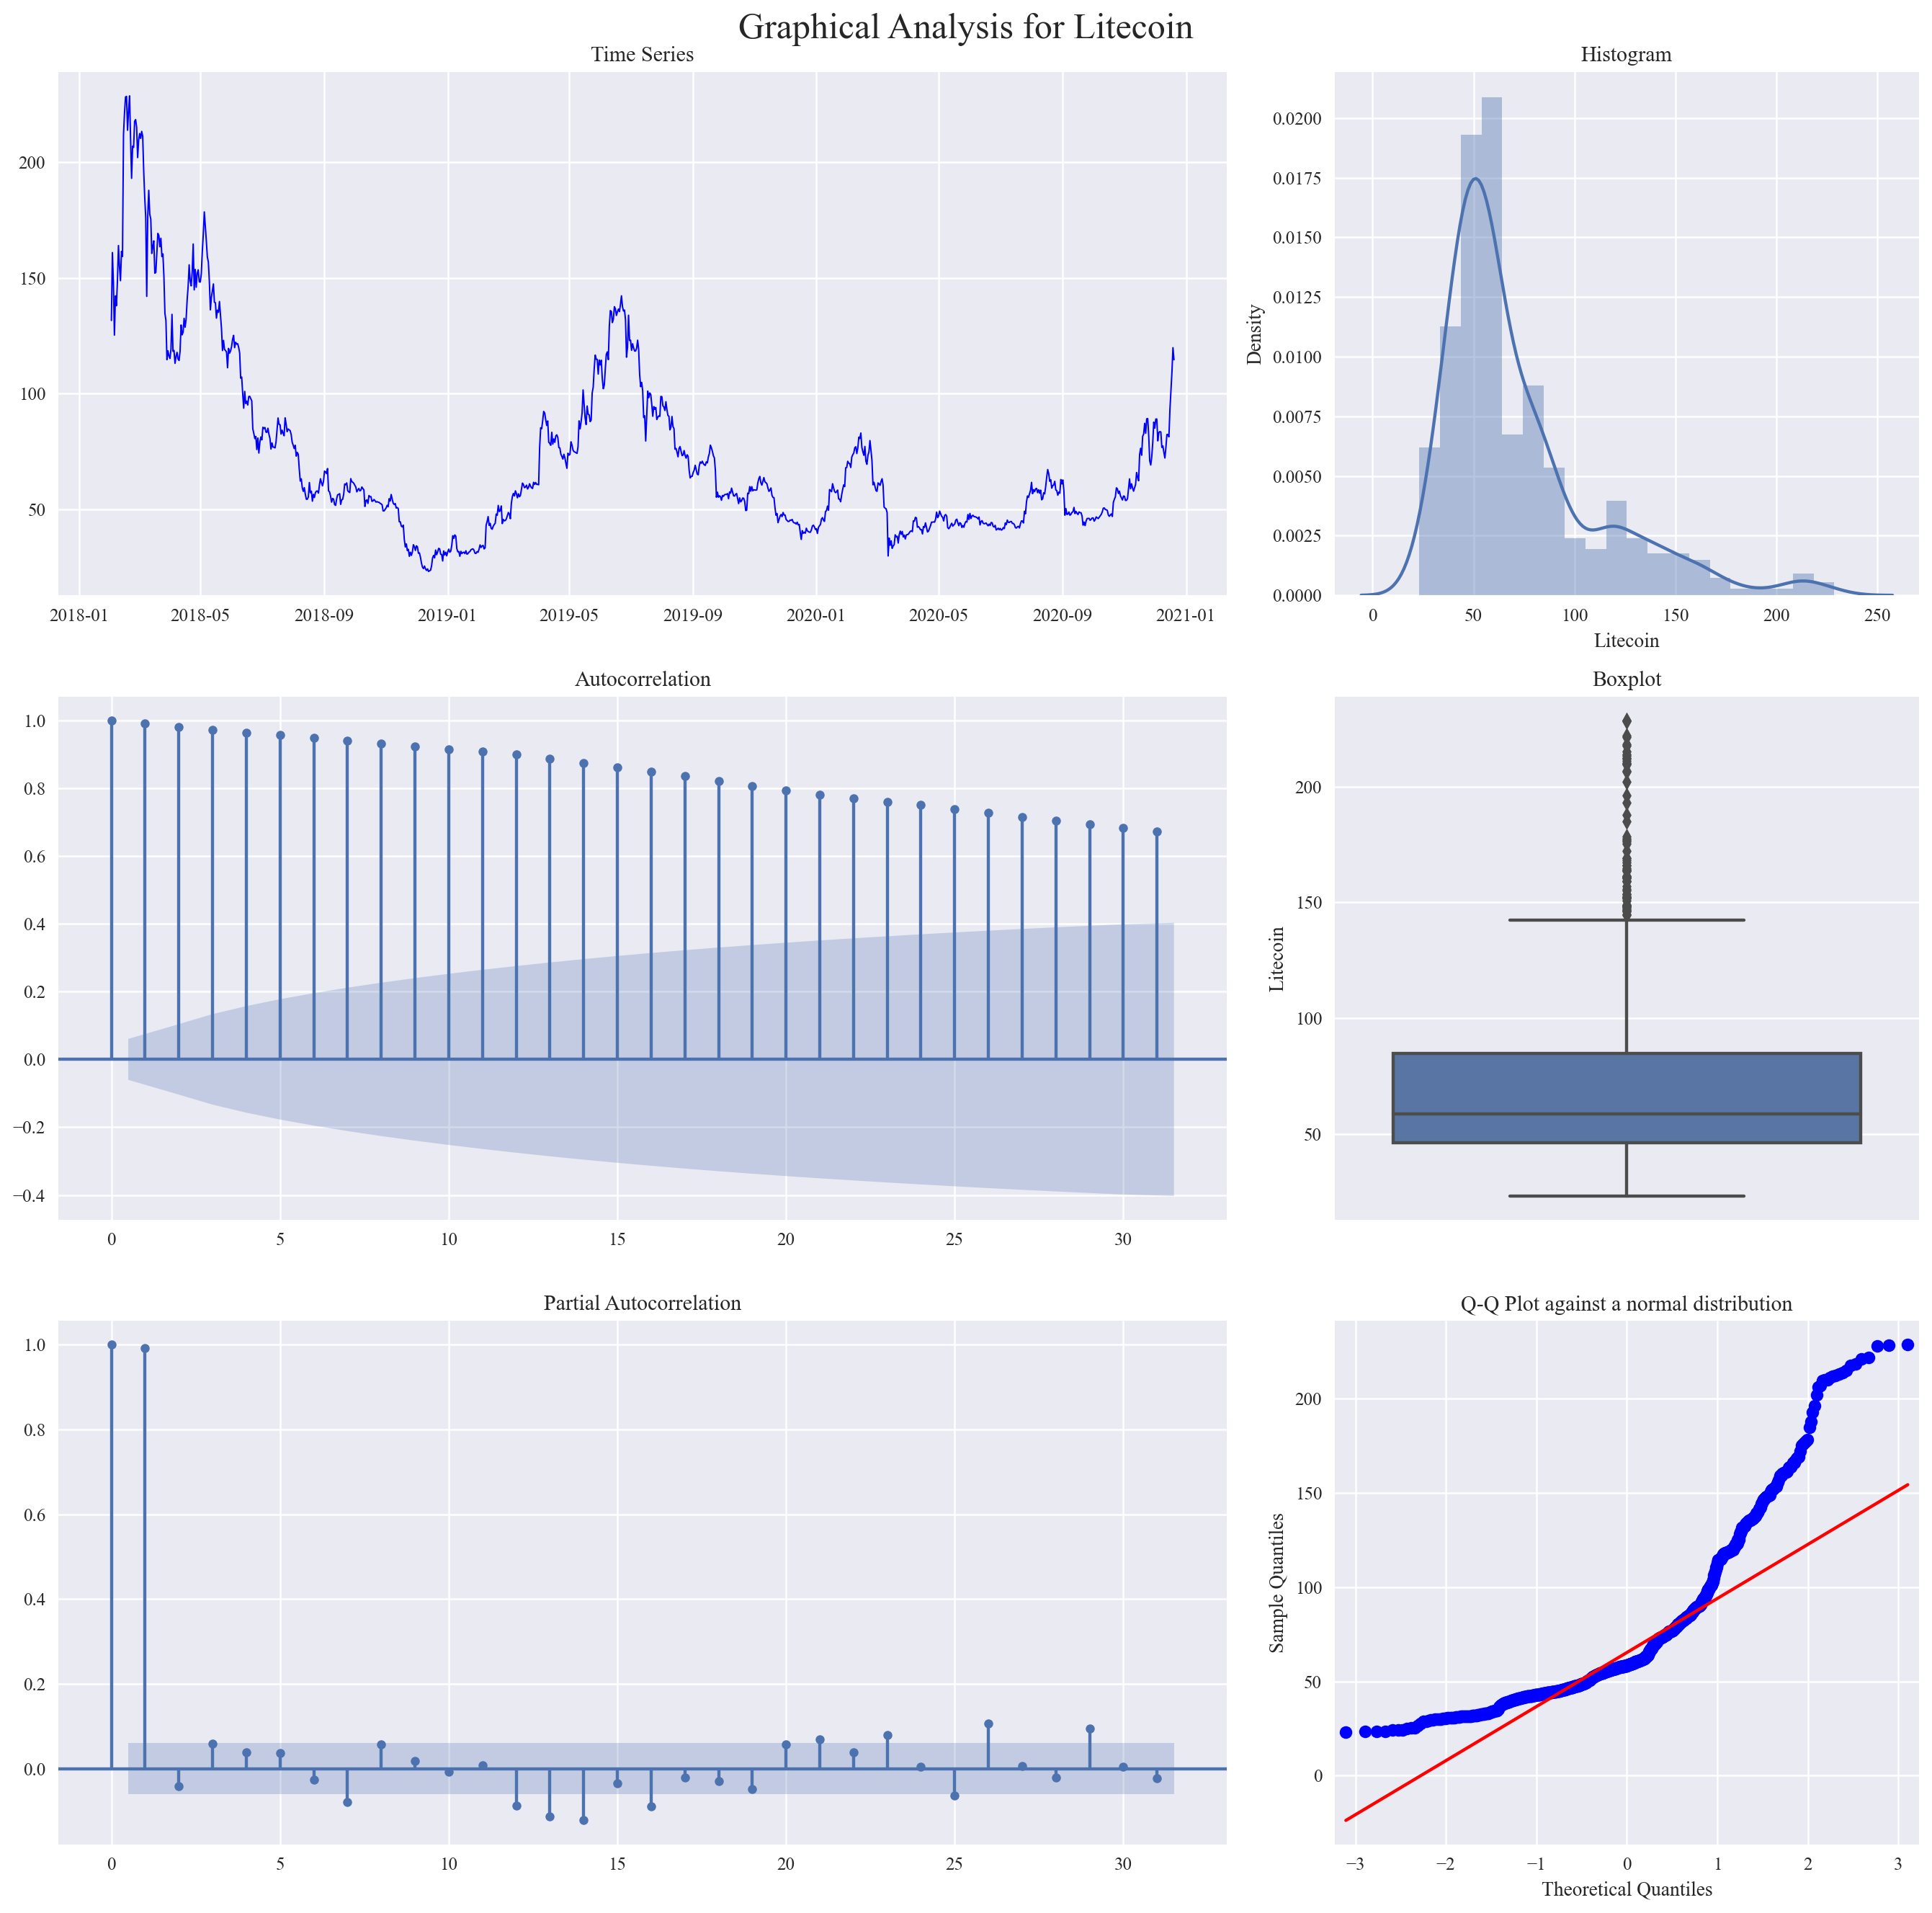

In [5]:
plot_graphics(crypto)

3 out of 4 of the distributions of the prices are bi-modal and all of them exhibit leptokurtosis are are right-skewed. 
There does not seem to be any significant partial autocorrelation with any value except Y(t-1)

Let us check if the distributions of the Cryptocurrencies can assumed to be Normally distributed.
I use the Jarque-Bera test to check whether the data is Normally distributed or not. The Null Hypothesis is that the data is Normally distributed.

I perform the Augmented Dickey-Fuller test to check for the presence of Unit-roots in each of the cryptocurrencies.
If a unit-root is present then the data is non-stationary

In [6]:
normality_checking(crypto)


--------------------------------------------

Checking Normality of Binance
Test Statistic : 62.20, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Bitcoin
Test Statistic : 759.80, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Cardano
Test Statistic : 1477.02, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of EOS
Test Statistic : 2303.08, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Chainlink
Test Statistic : 788.48, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Ethereum
Test Statistic : nan, p valu

In [7]:
stationary_checking(crypto)


--------------------------------------------

Checking Stationarity of Binance
Test Statistic : -1.18, p value : 0.68114
Data is NOT Stationary for Binance

--------------------------------------------

Checking Stationarity of Bitcoin
Test Statistic : 1.45, p value : 0.99731
Data is NOT Stationary for Bitcoin

--------------------------------------------

Checking Stationarity of Cardano
Test Statistic : -3.55, p value : 0.00676
Data is Stationary for Cardano

--------------------------------------------

Checking Stationarity of EOS
Test Statistic : -2.89, p value : 0.04648
Data is Stationary for EOS

--------------------------------------------

Checking Stationarity of Chainlink
Test Statistic : 0.07, p value : 0.96413
Data is NOT Stationary for Chainlink

--------------------------------------------

Checking Stationarity of Ethereum
Test Statistic : -2.68, p value : 0.07803
Data is NOT Stationary for Ethereum

--------------------------------------------

Checking Stationarity o

Looking at the test results and statistics for each cryptocurrency, we can safely assume that the data is both non-stationary as well as non-normally distributed. 
Therefore we take the first difference of the data and then proceed to standardize it by subtracting its mean and dividing by the standard deviation of the differences

In [8]:

differencedCrypto = crypto.diff().bfill()
standardDifferencedCrypto = (
    differencedCrypto - differencedCrypto.mean()
) / differencedCrypto.std()


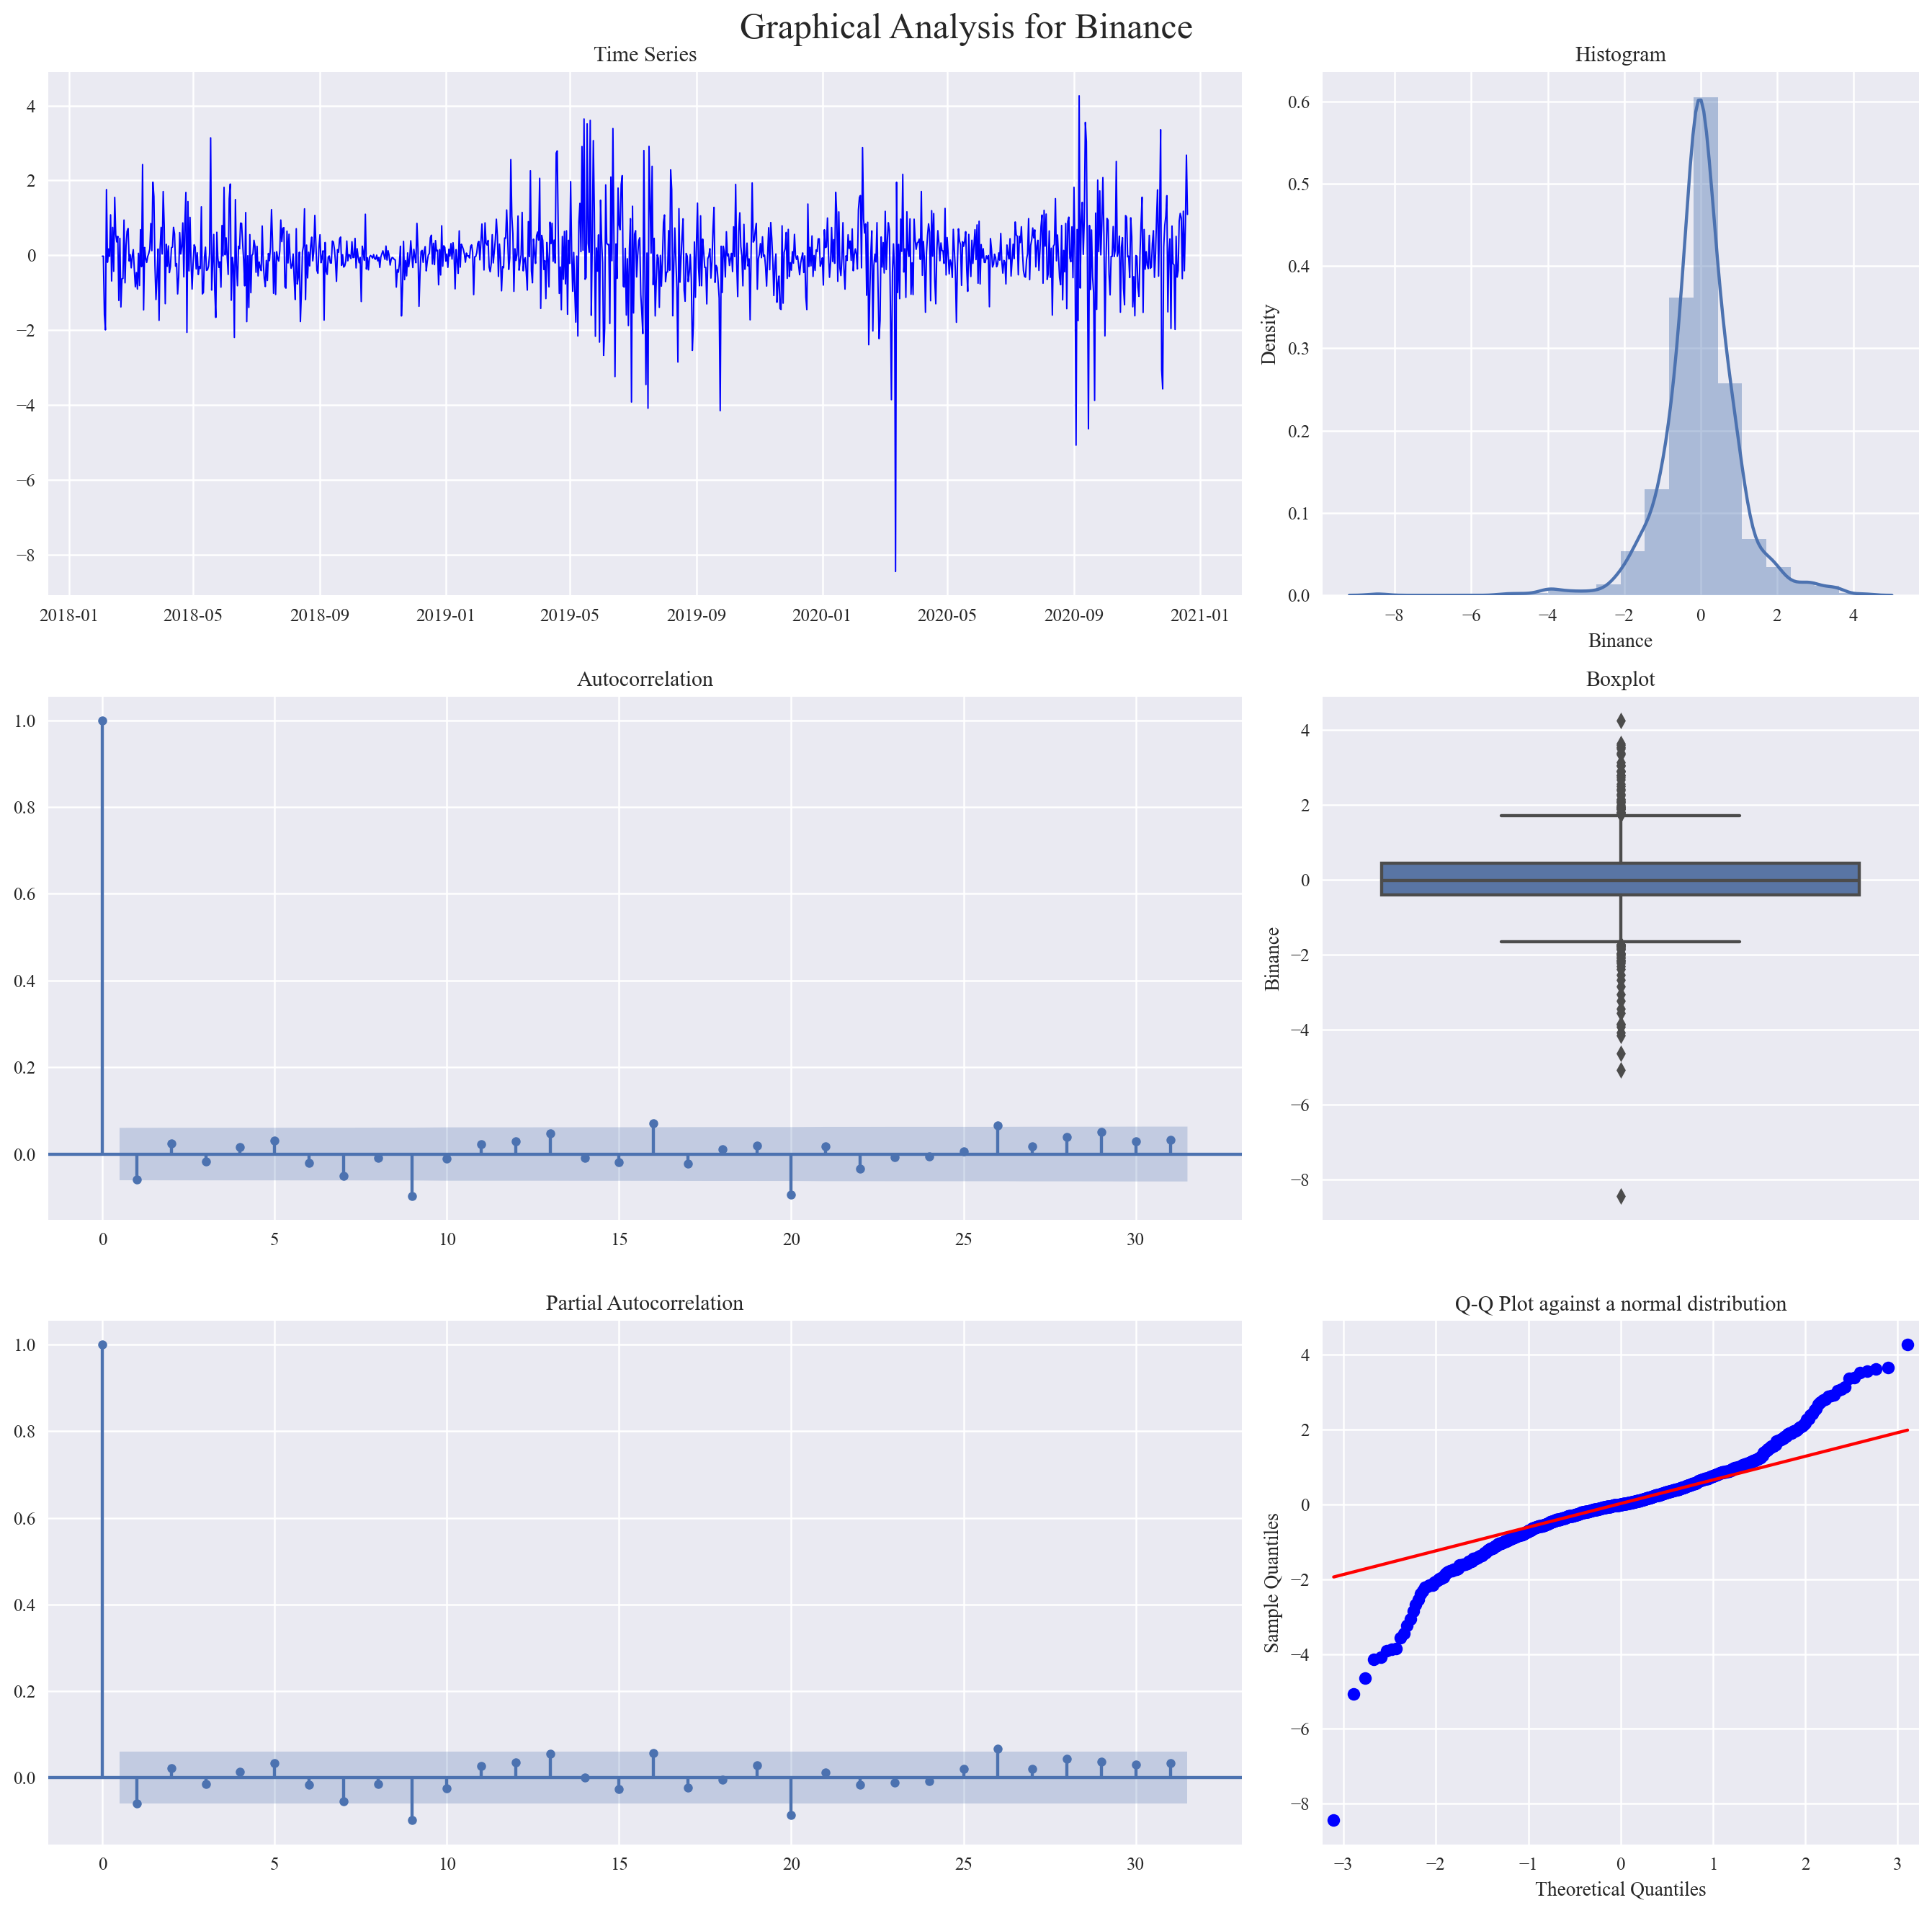

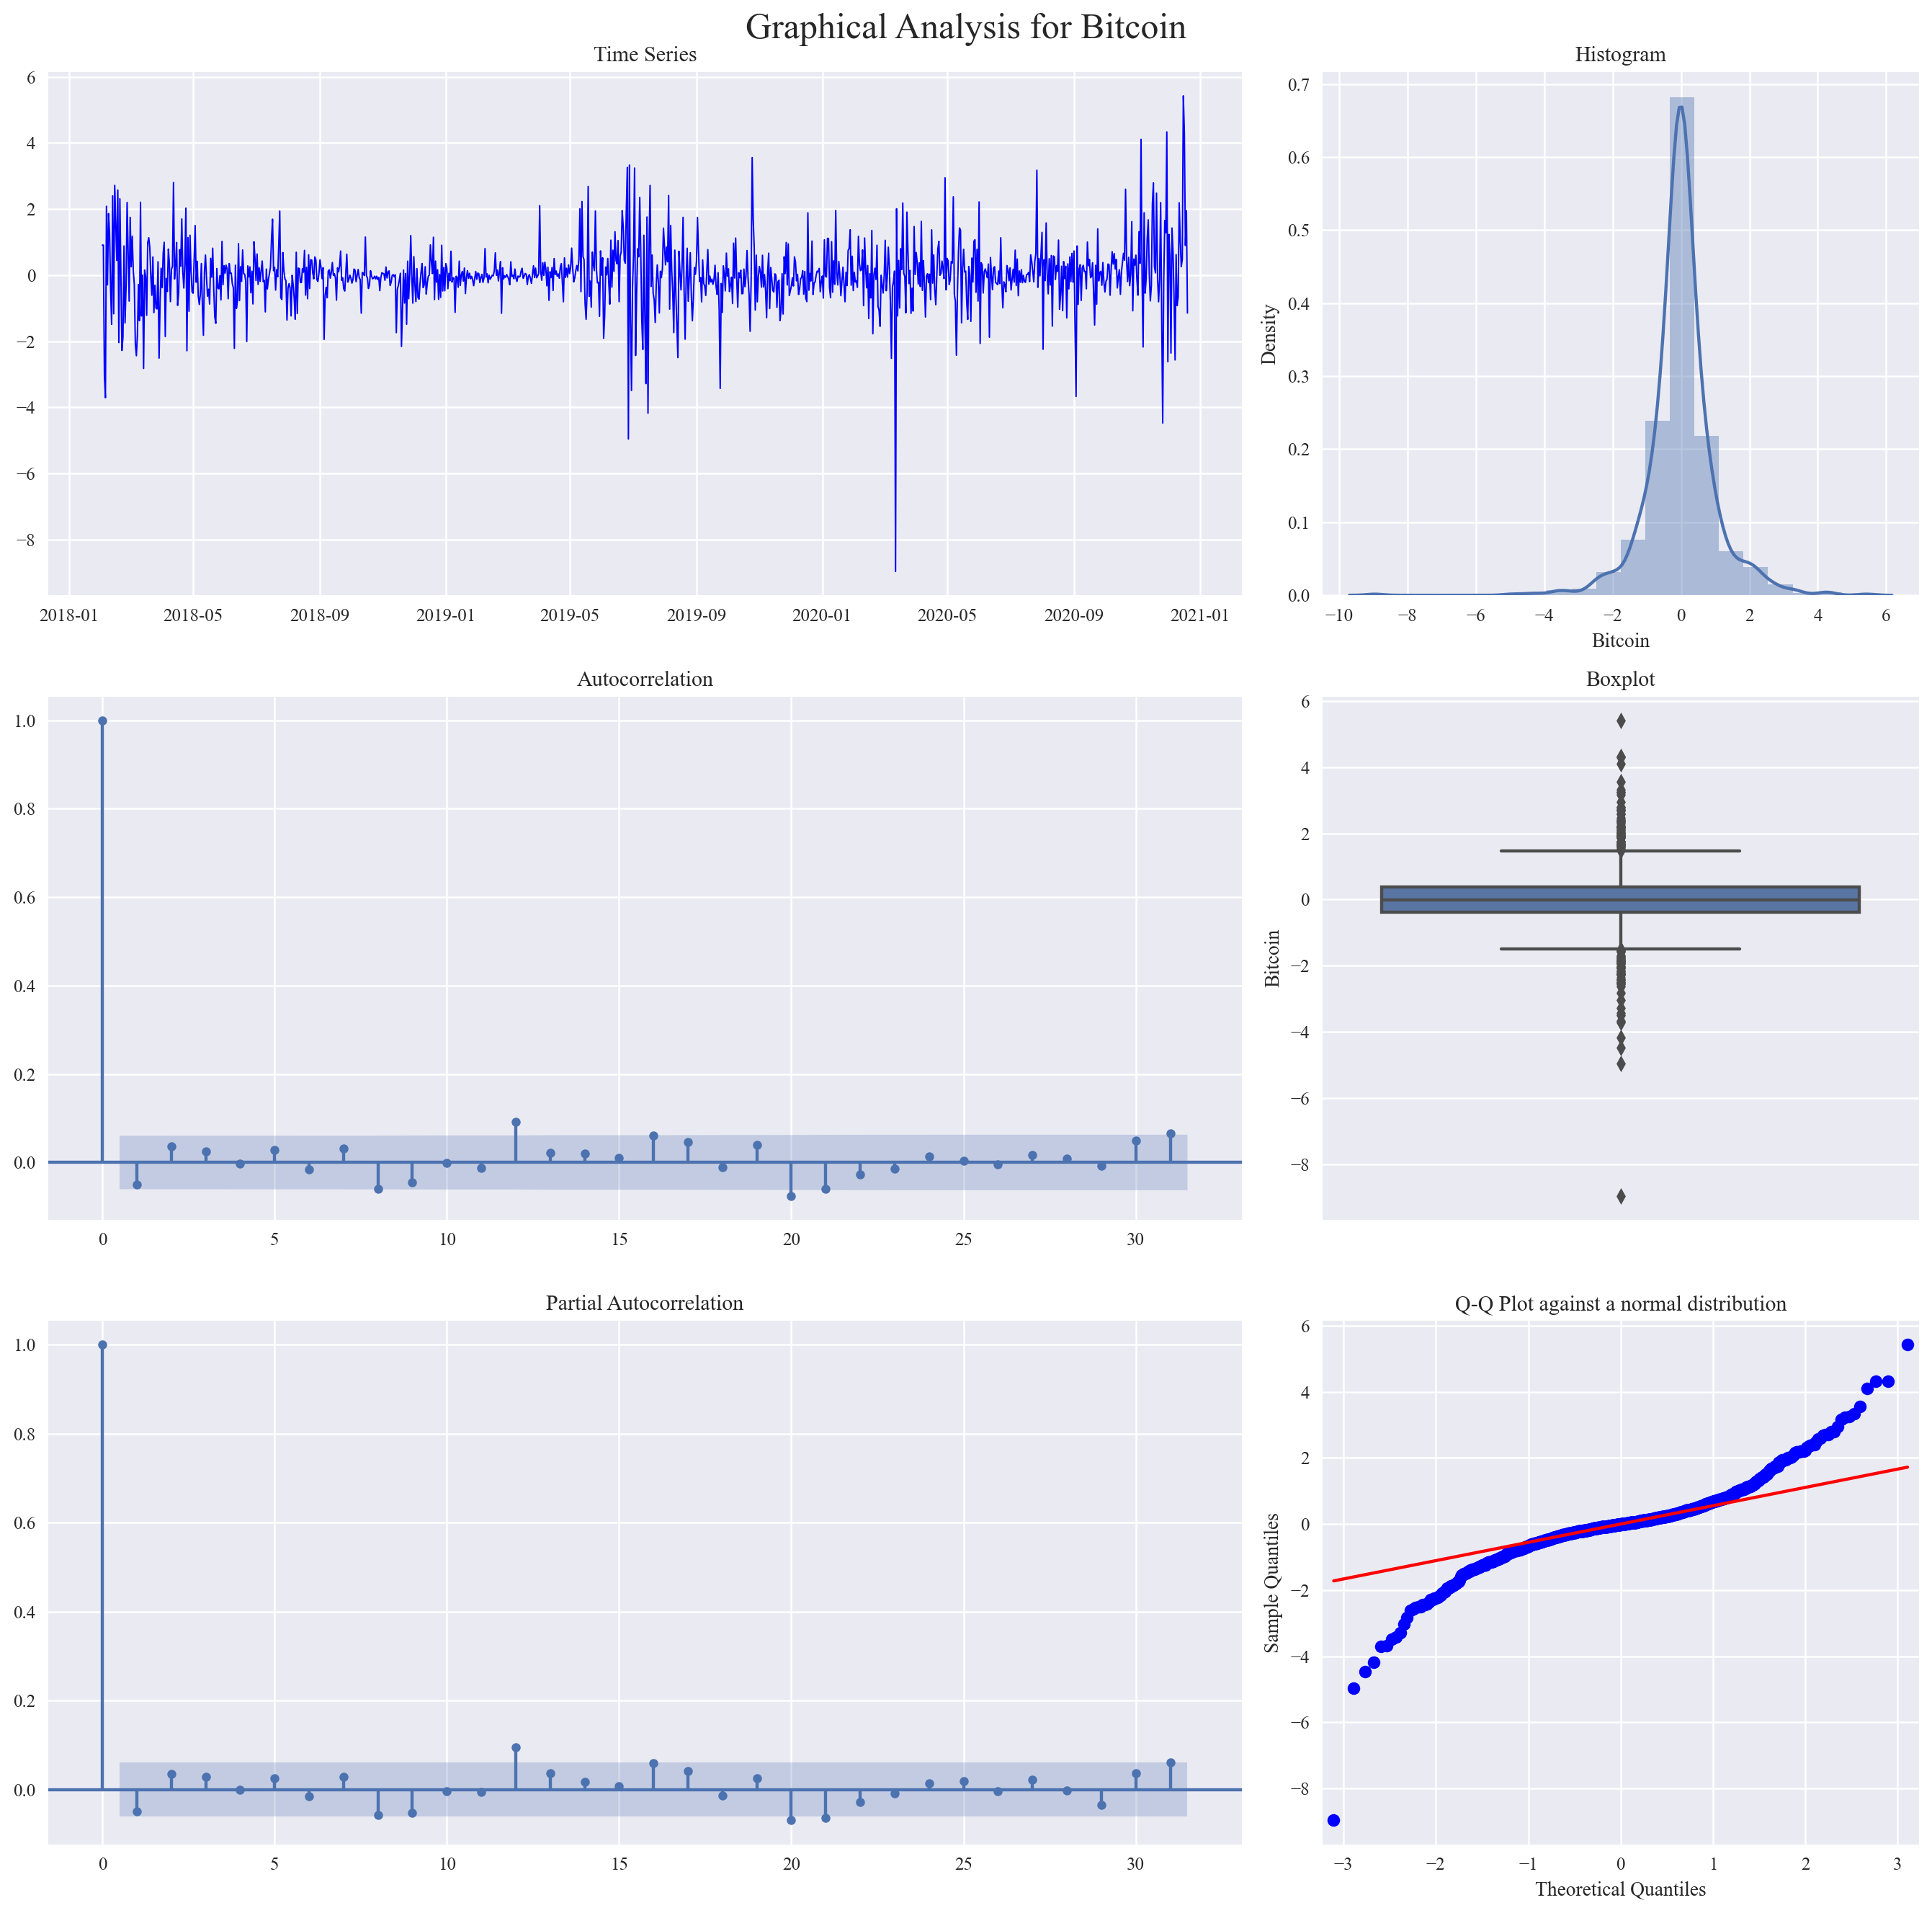

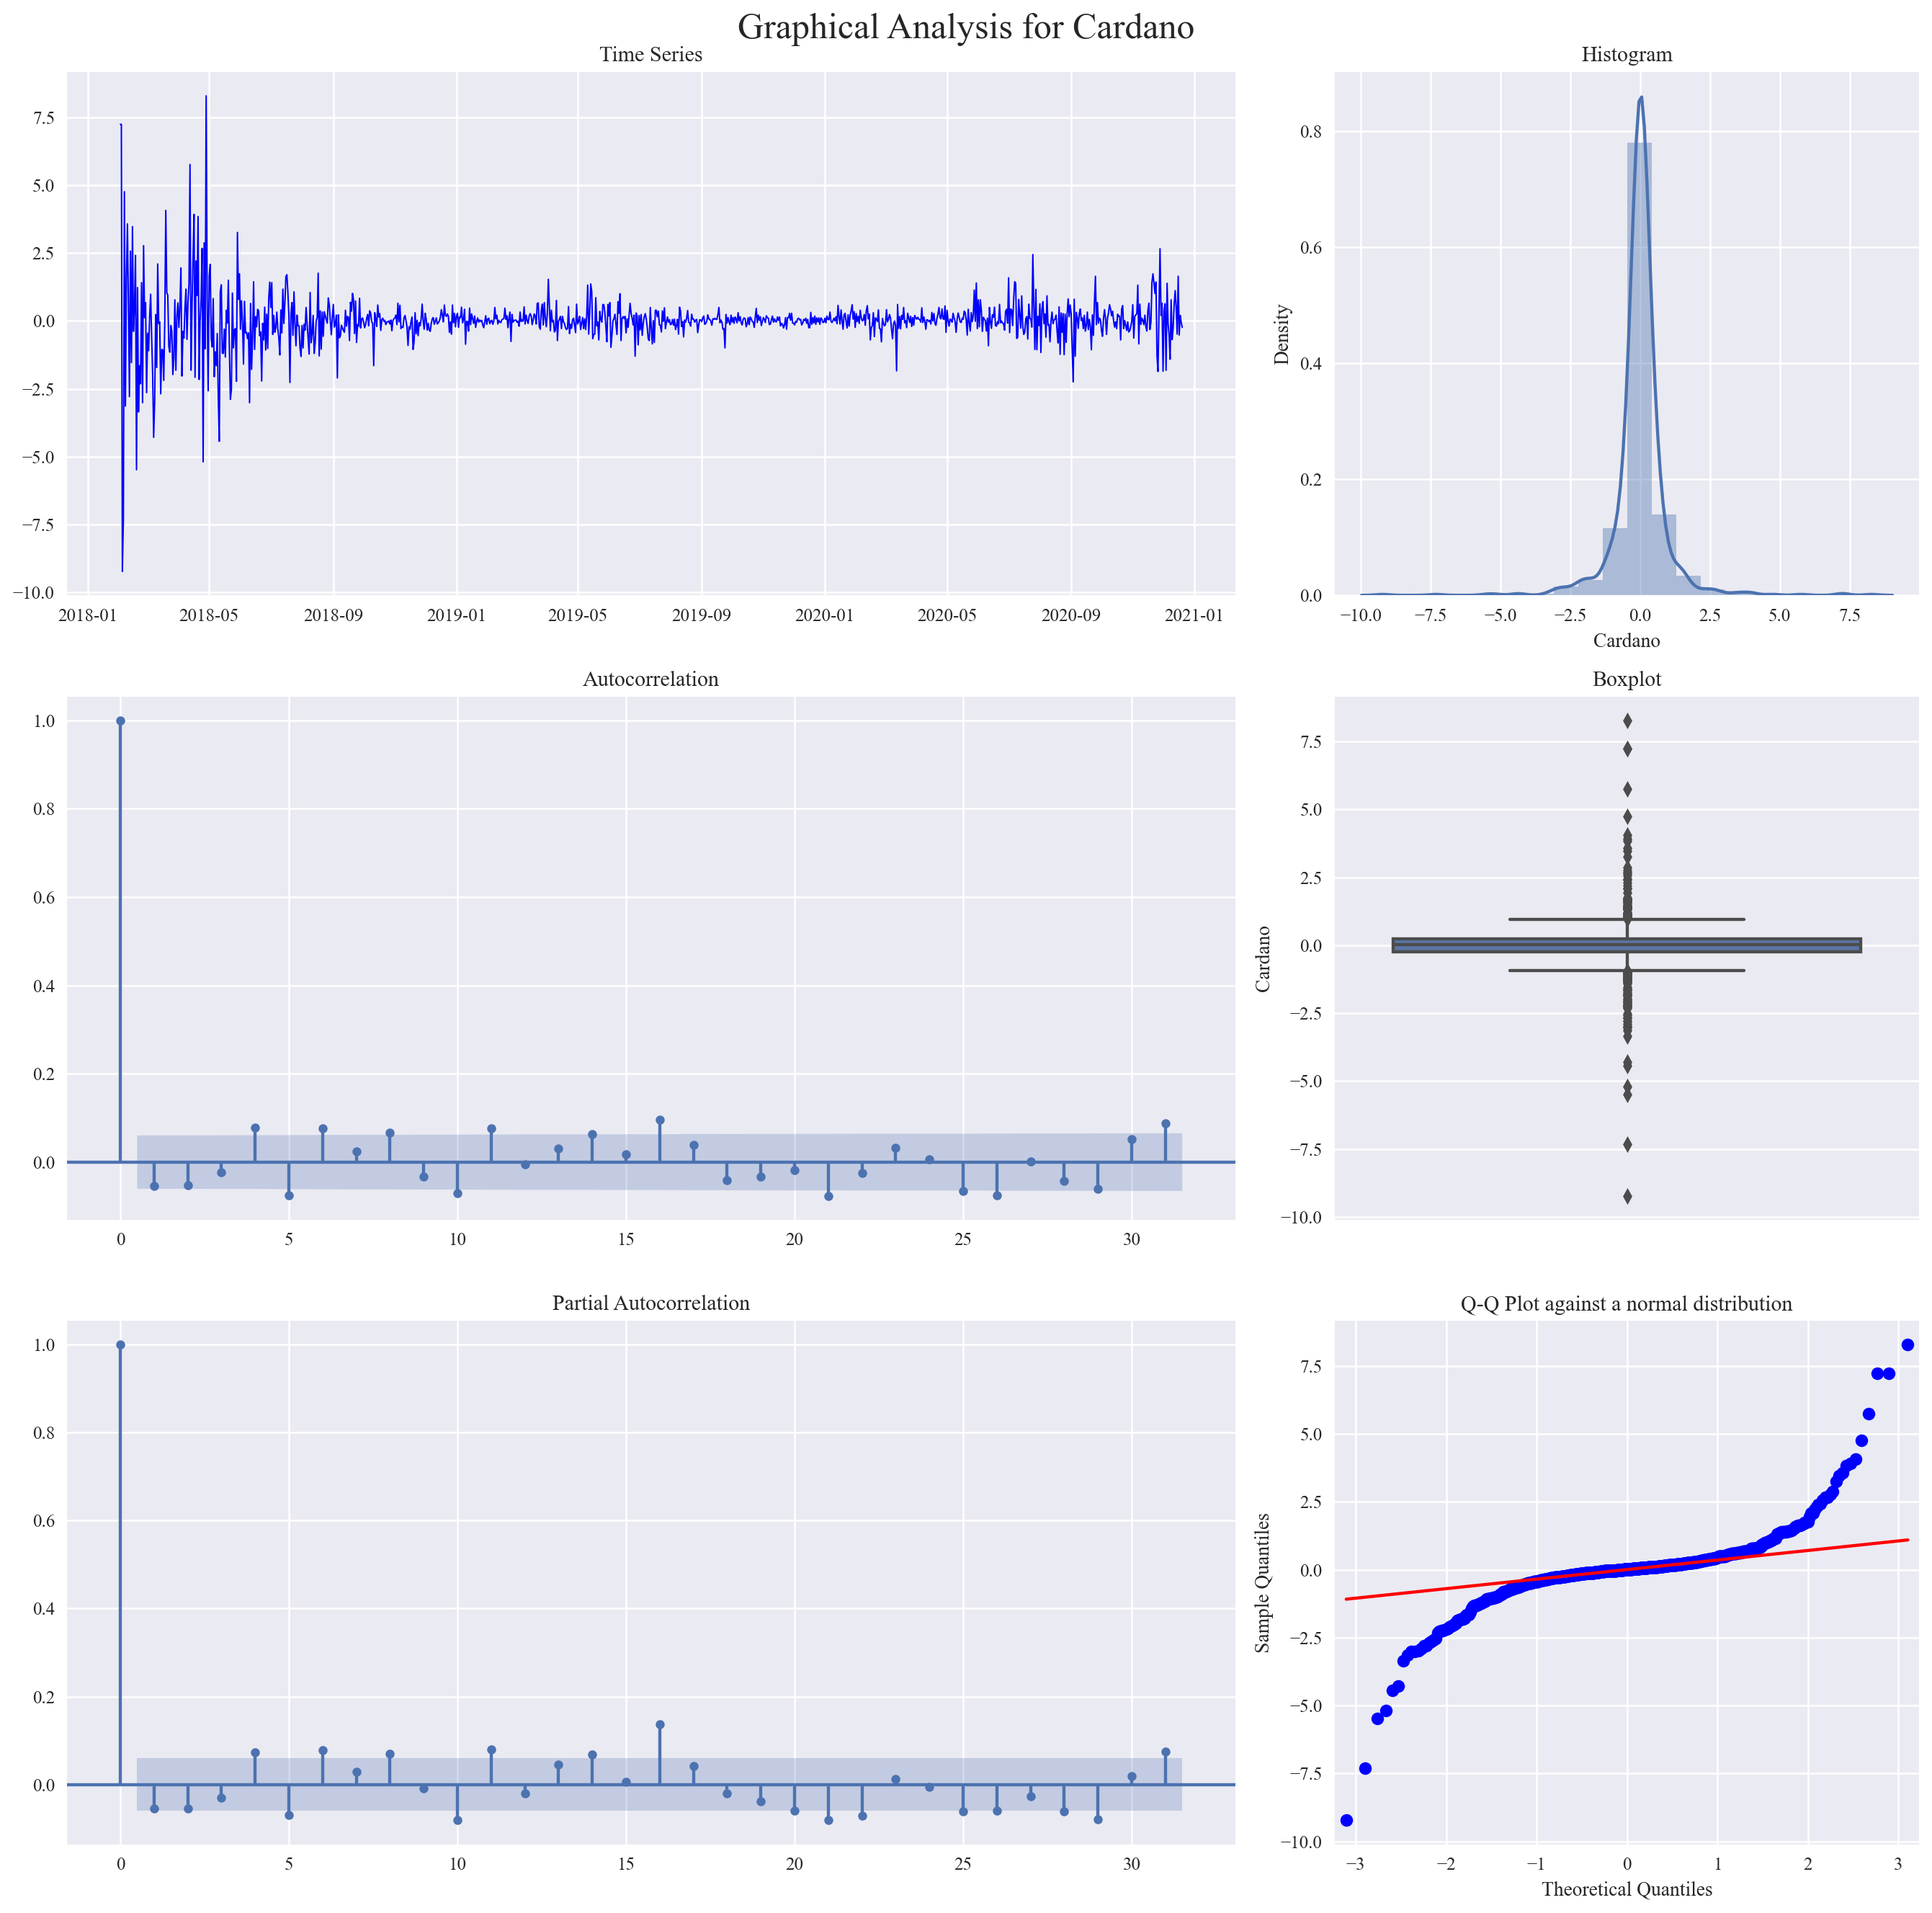

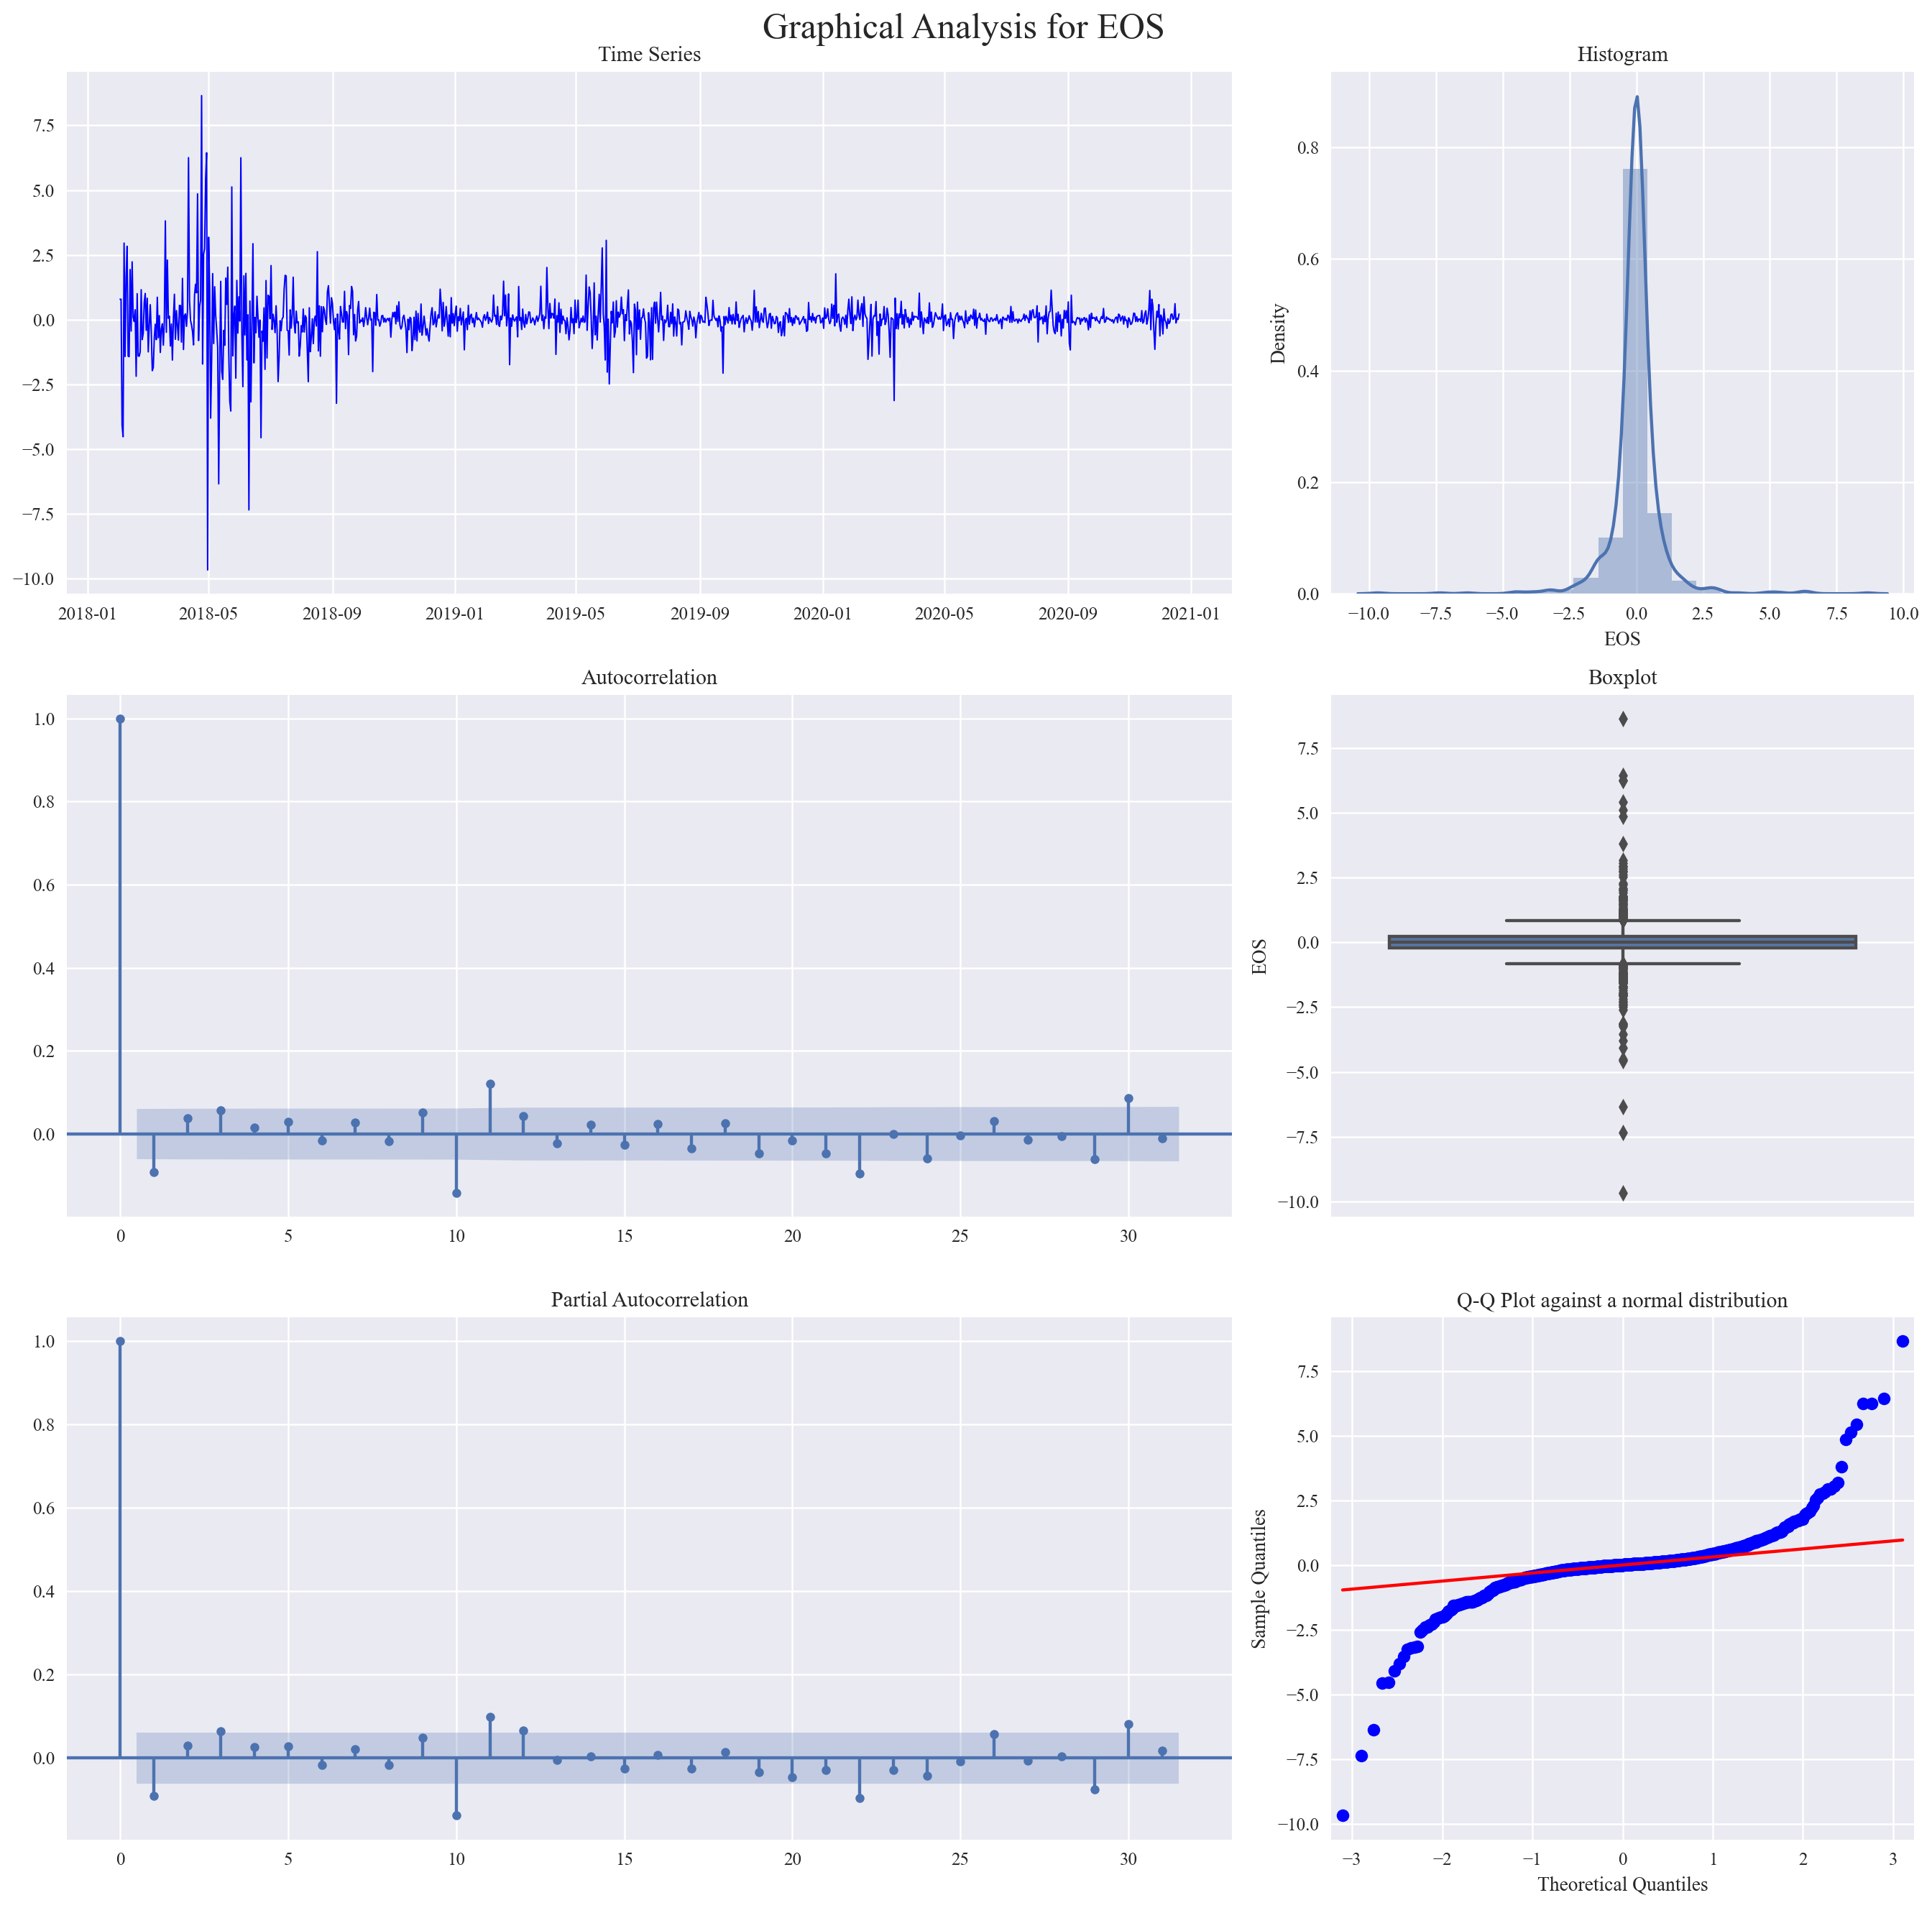

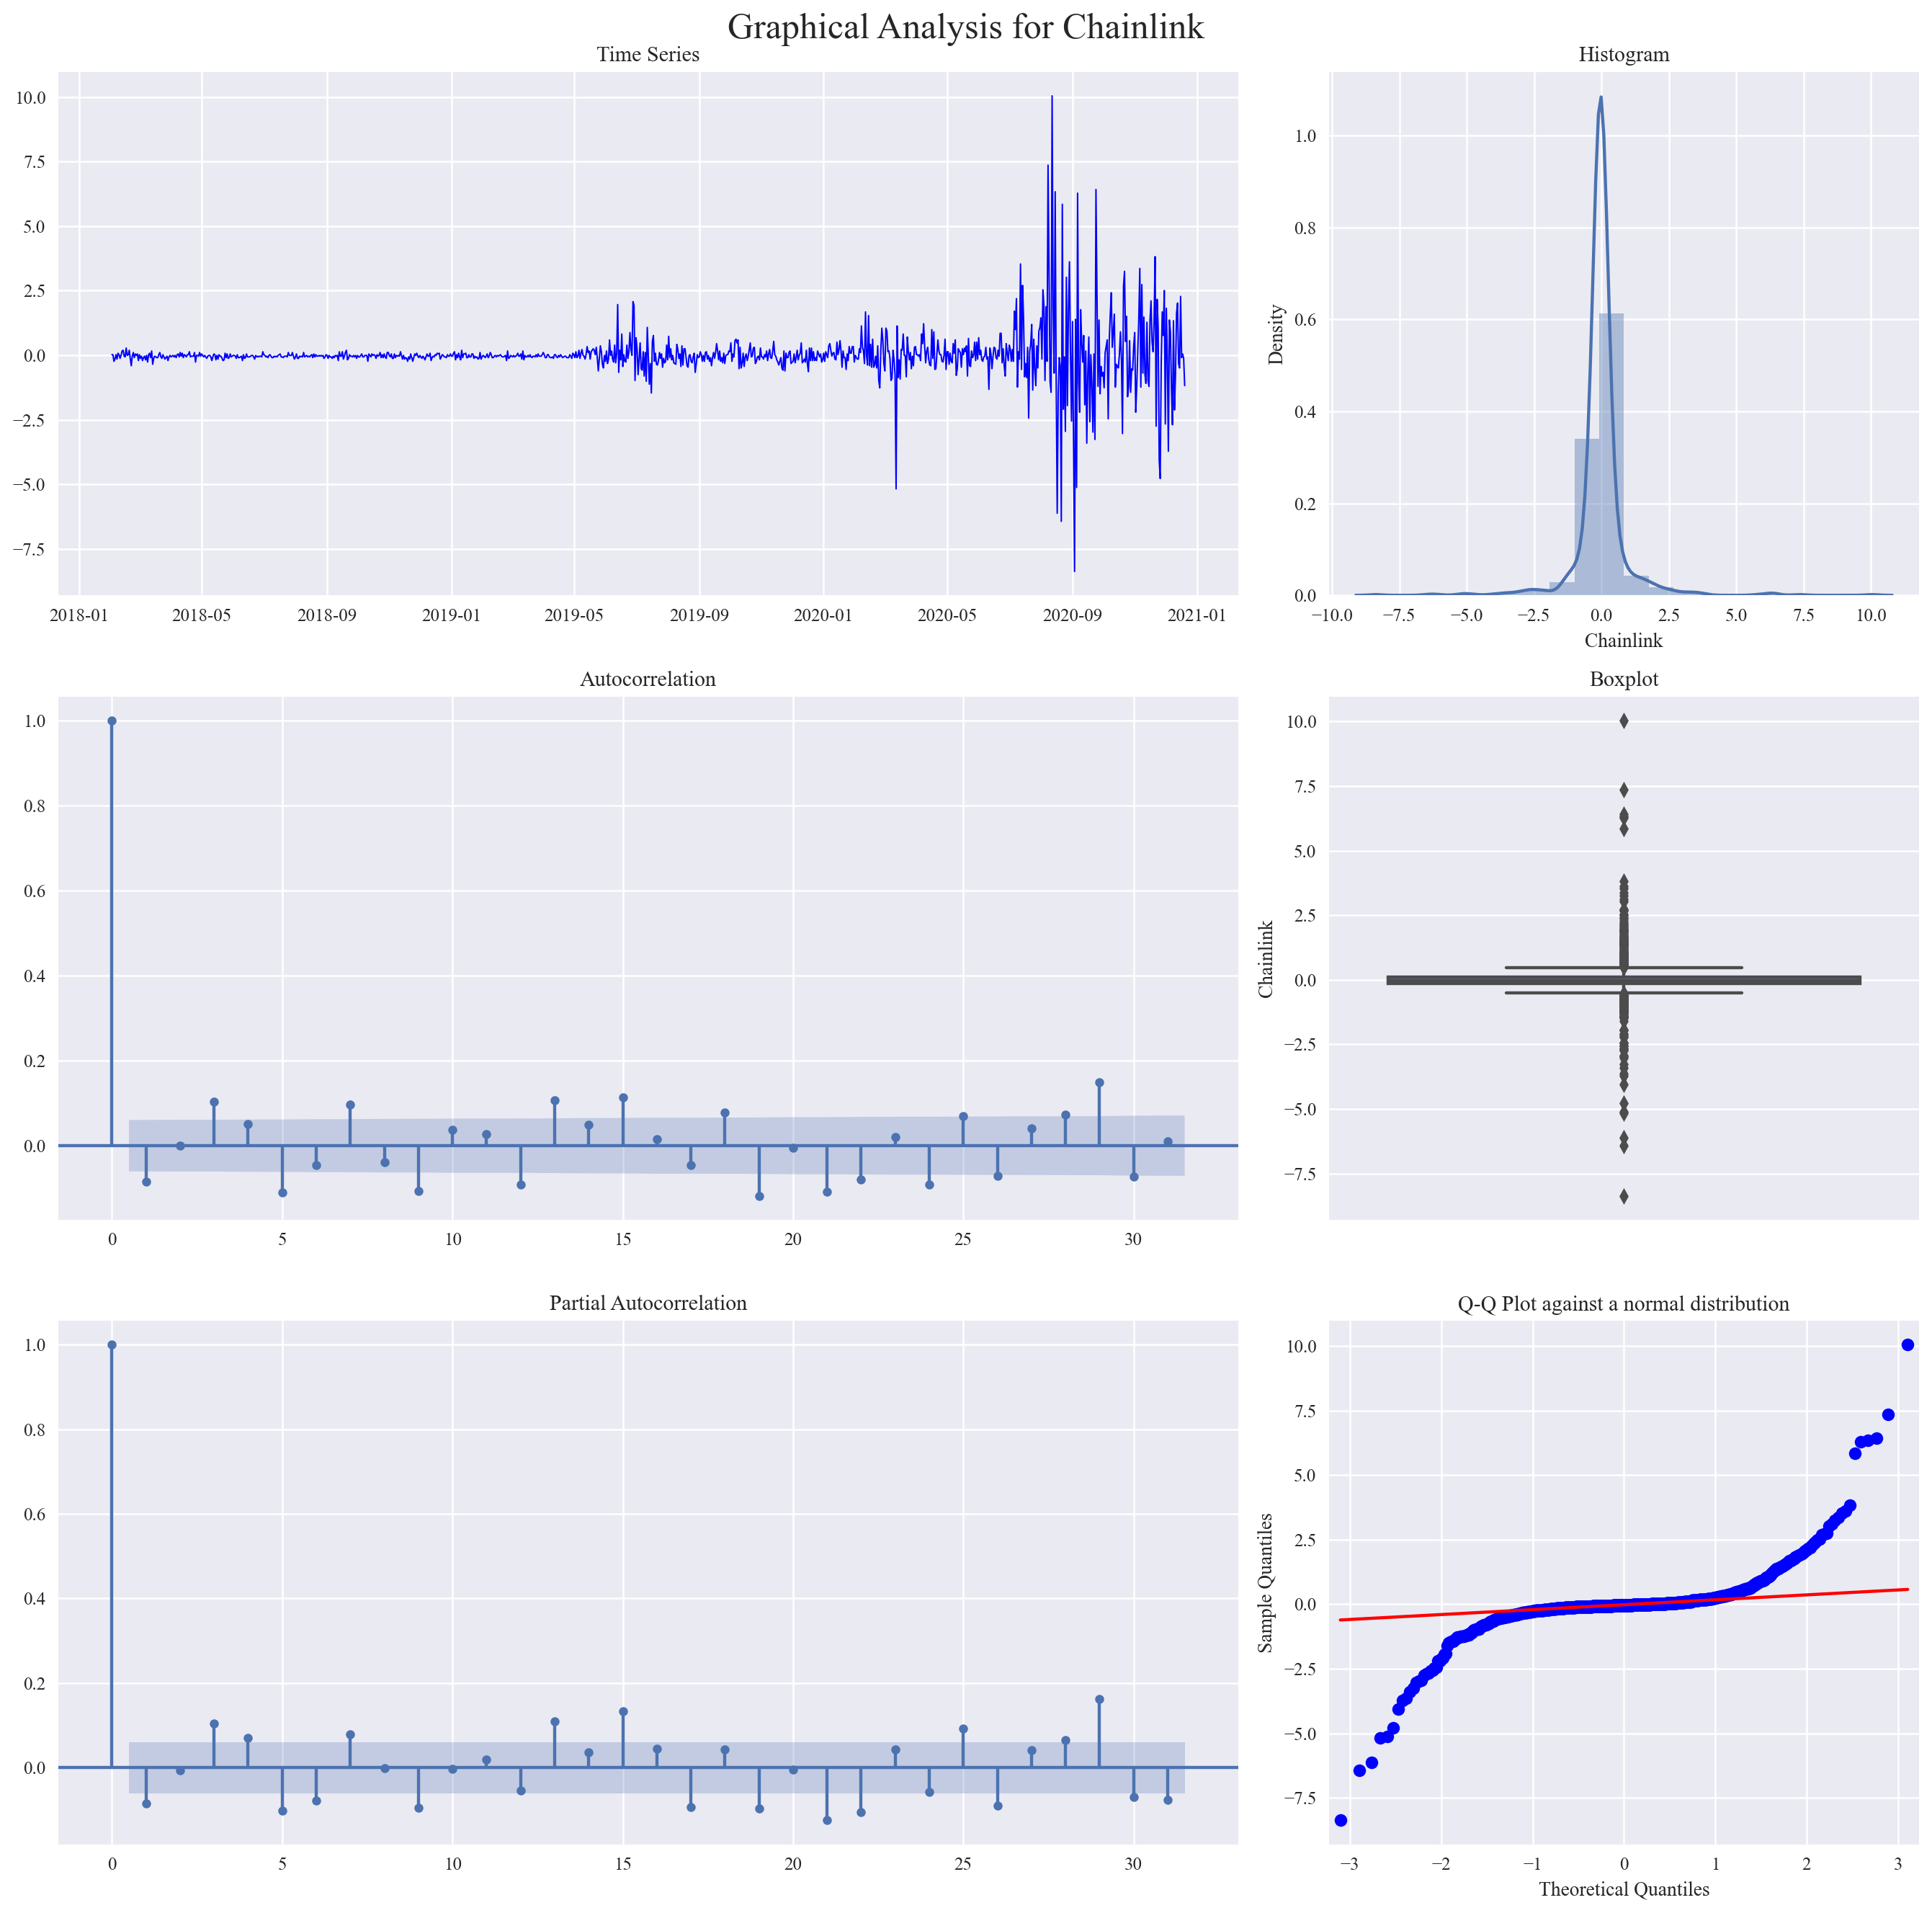

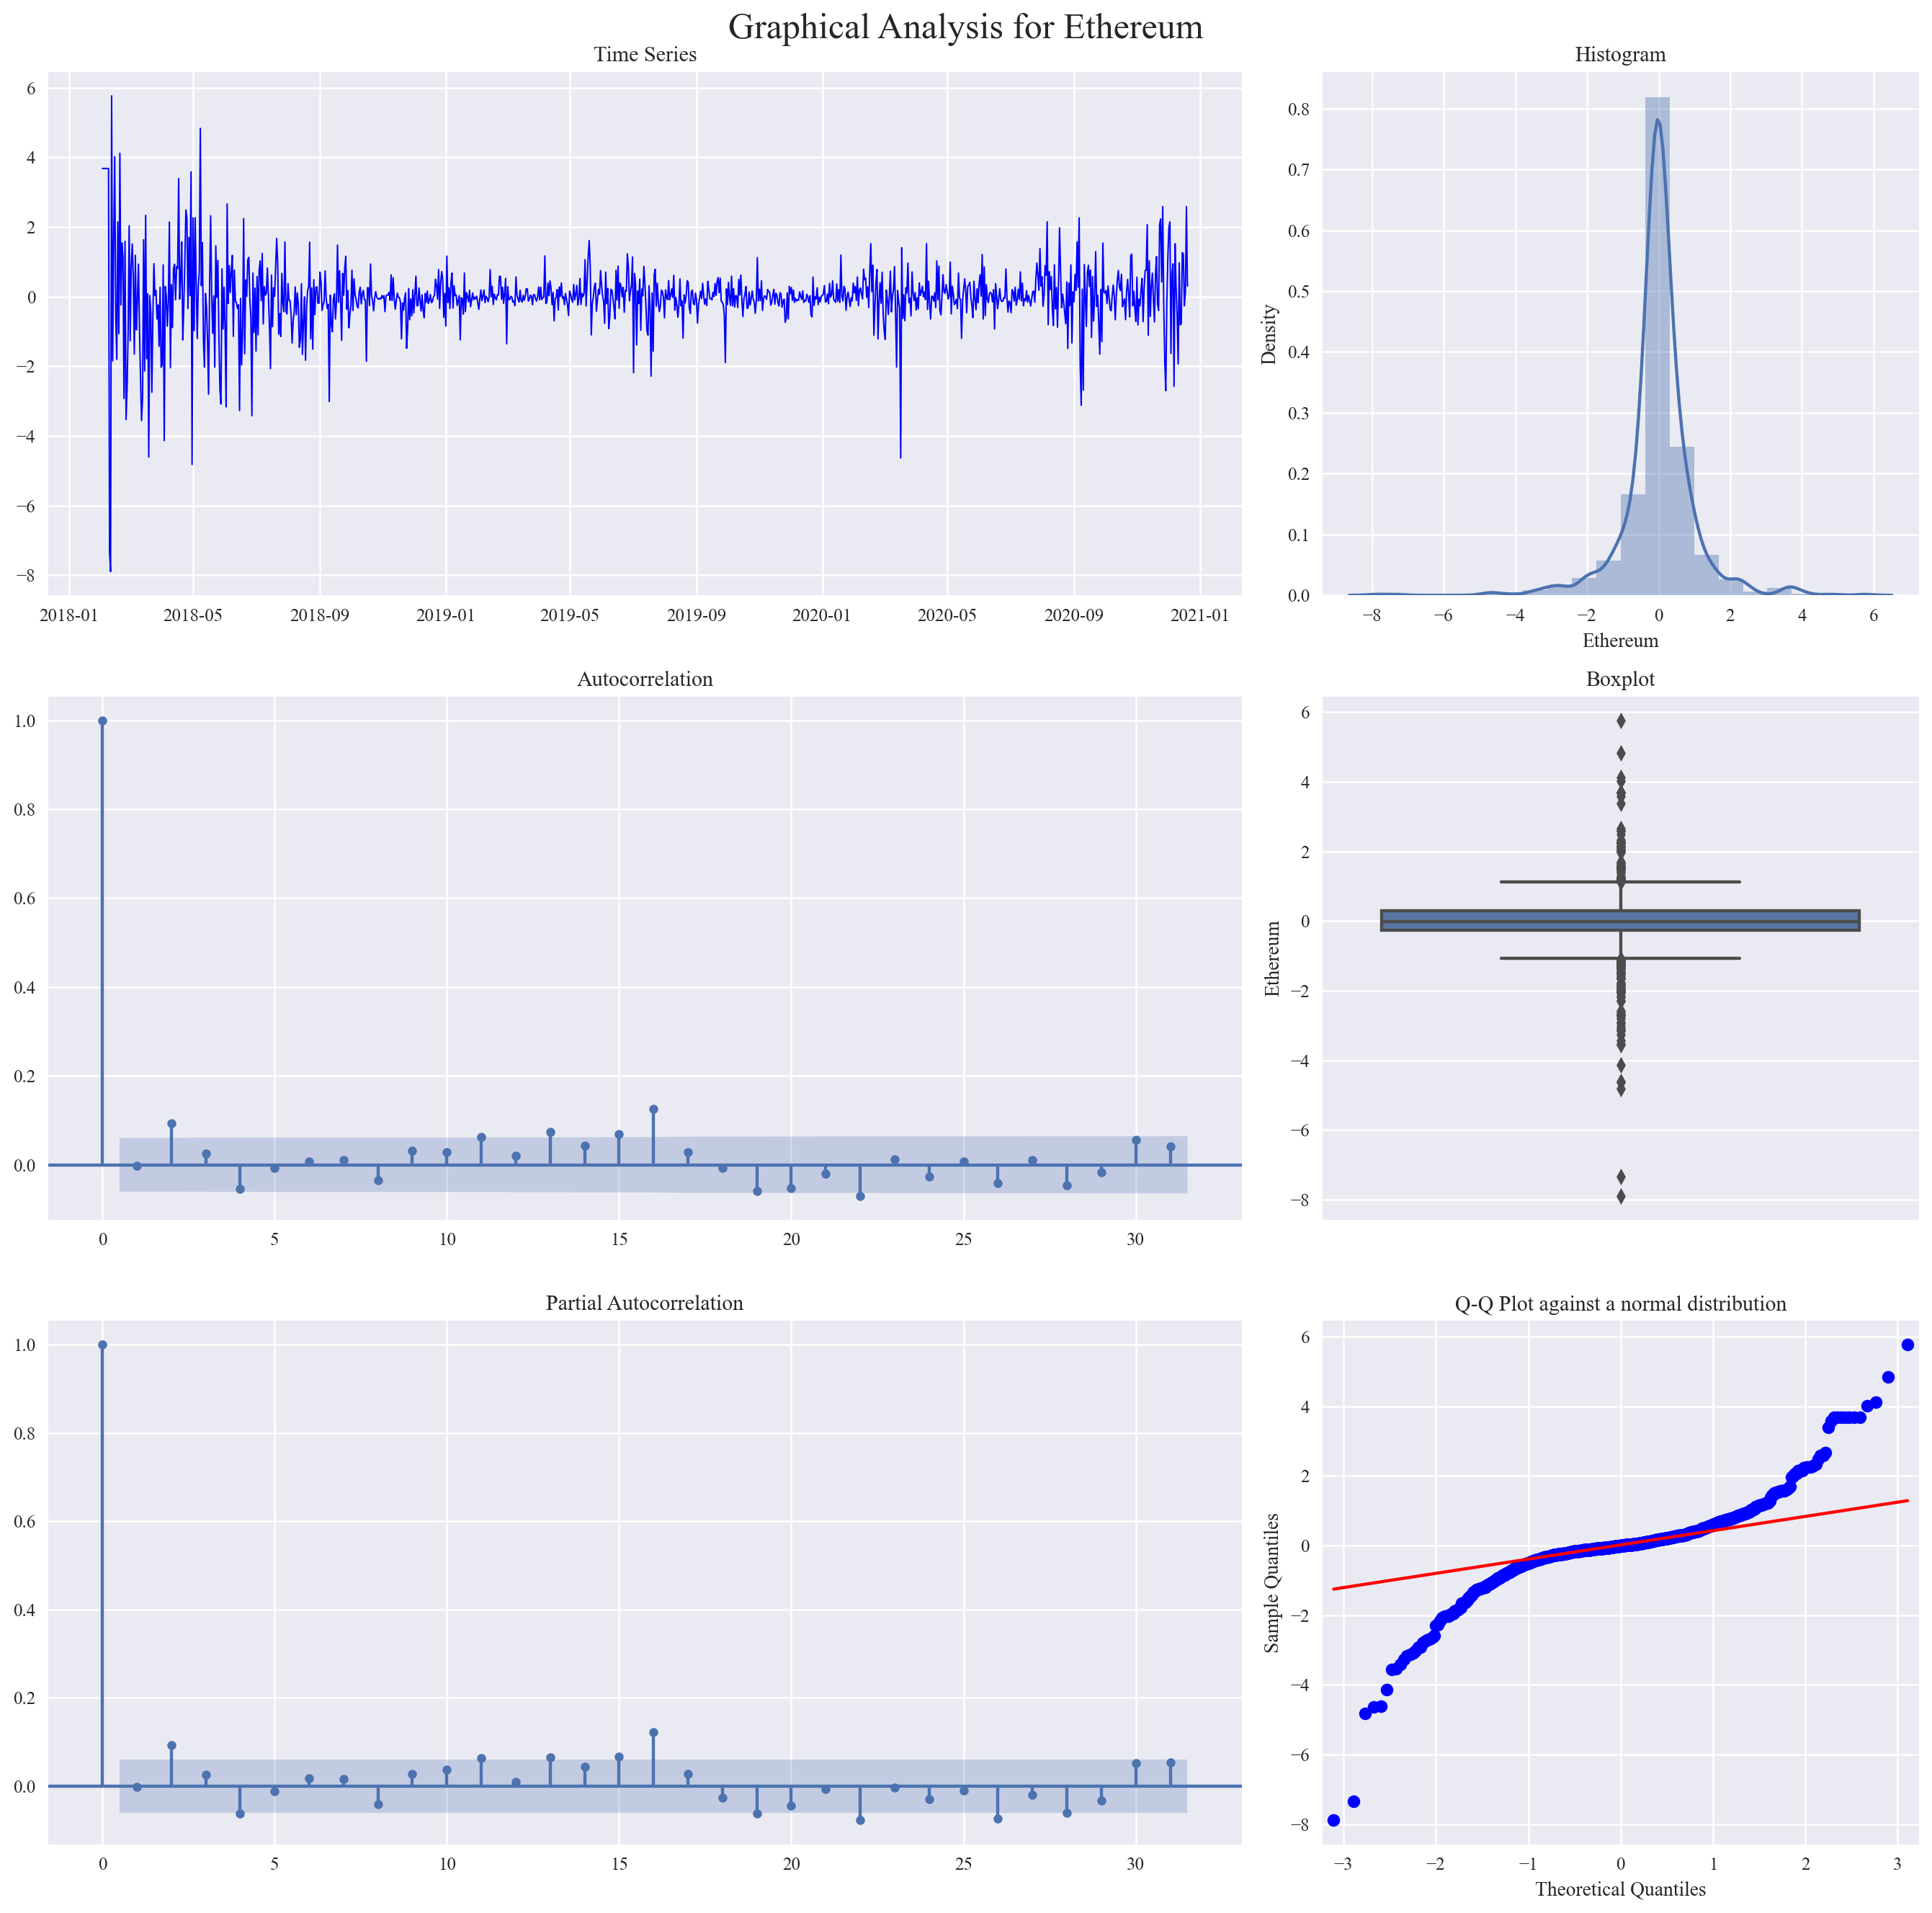

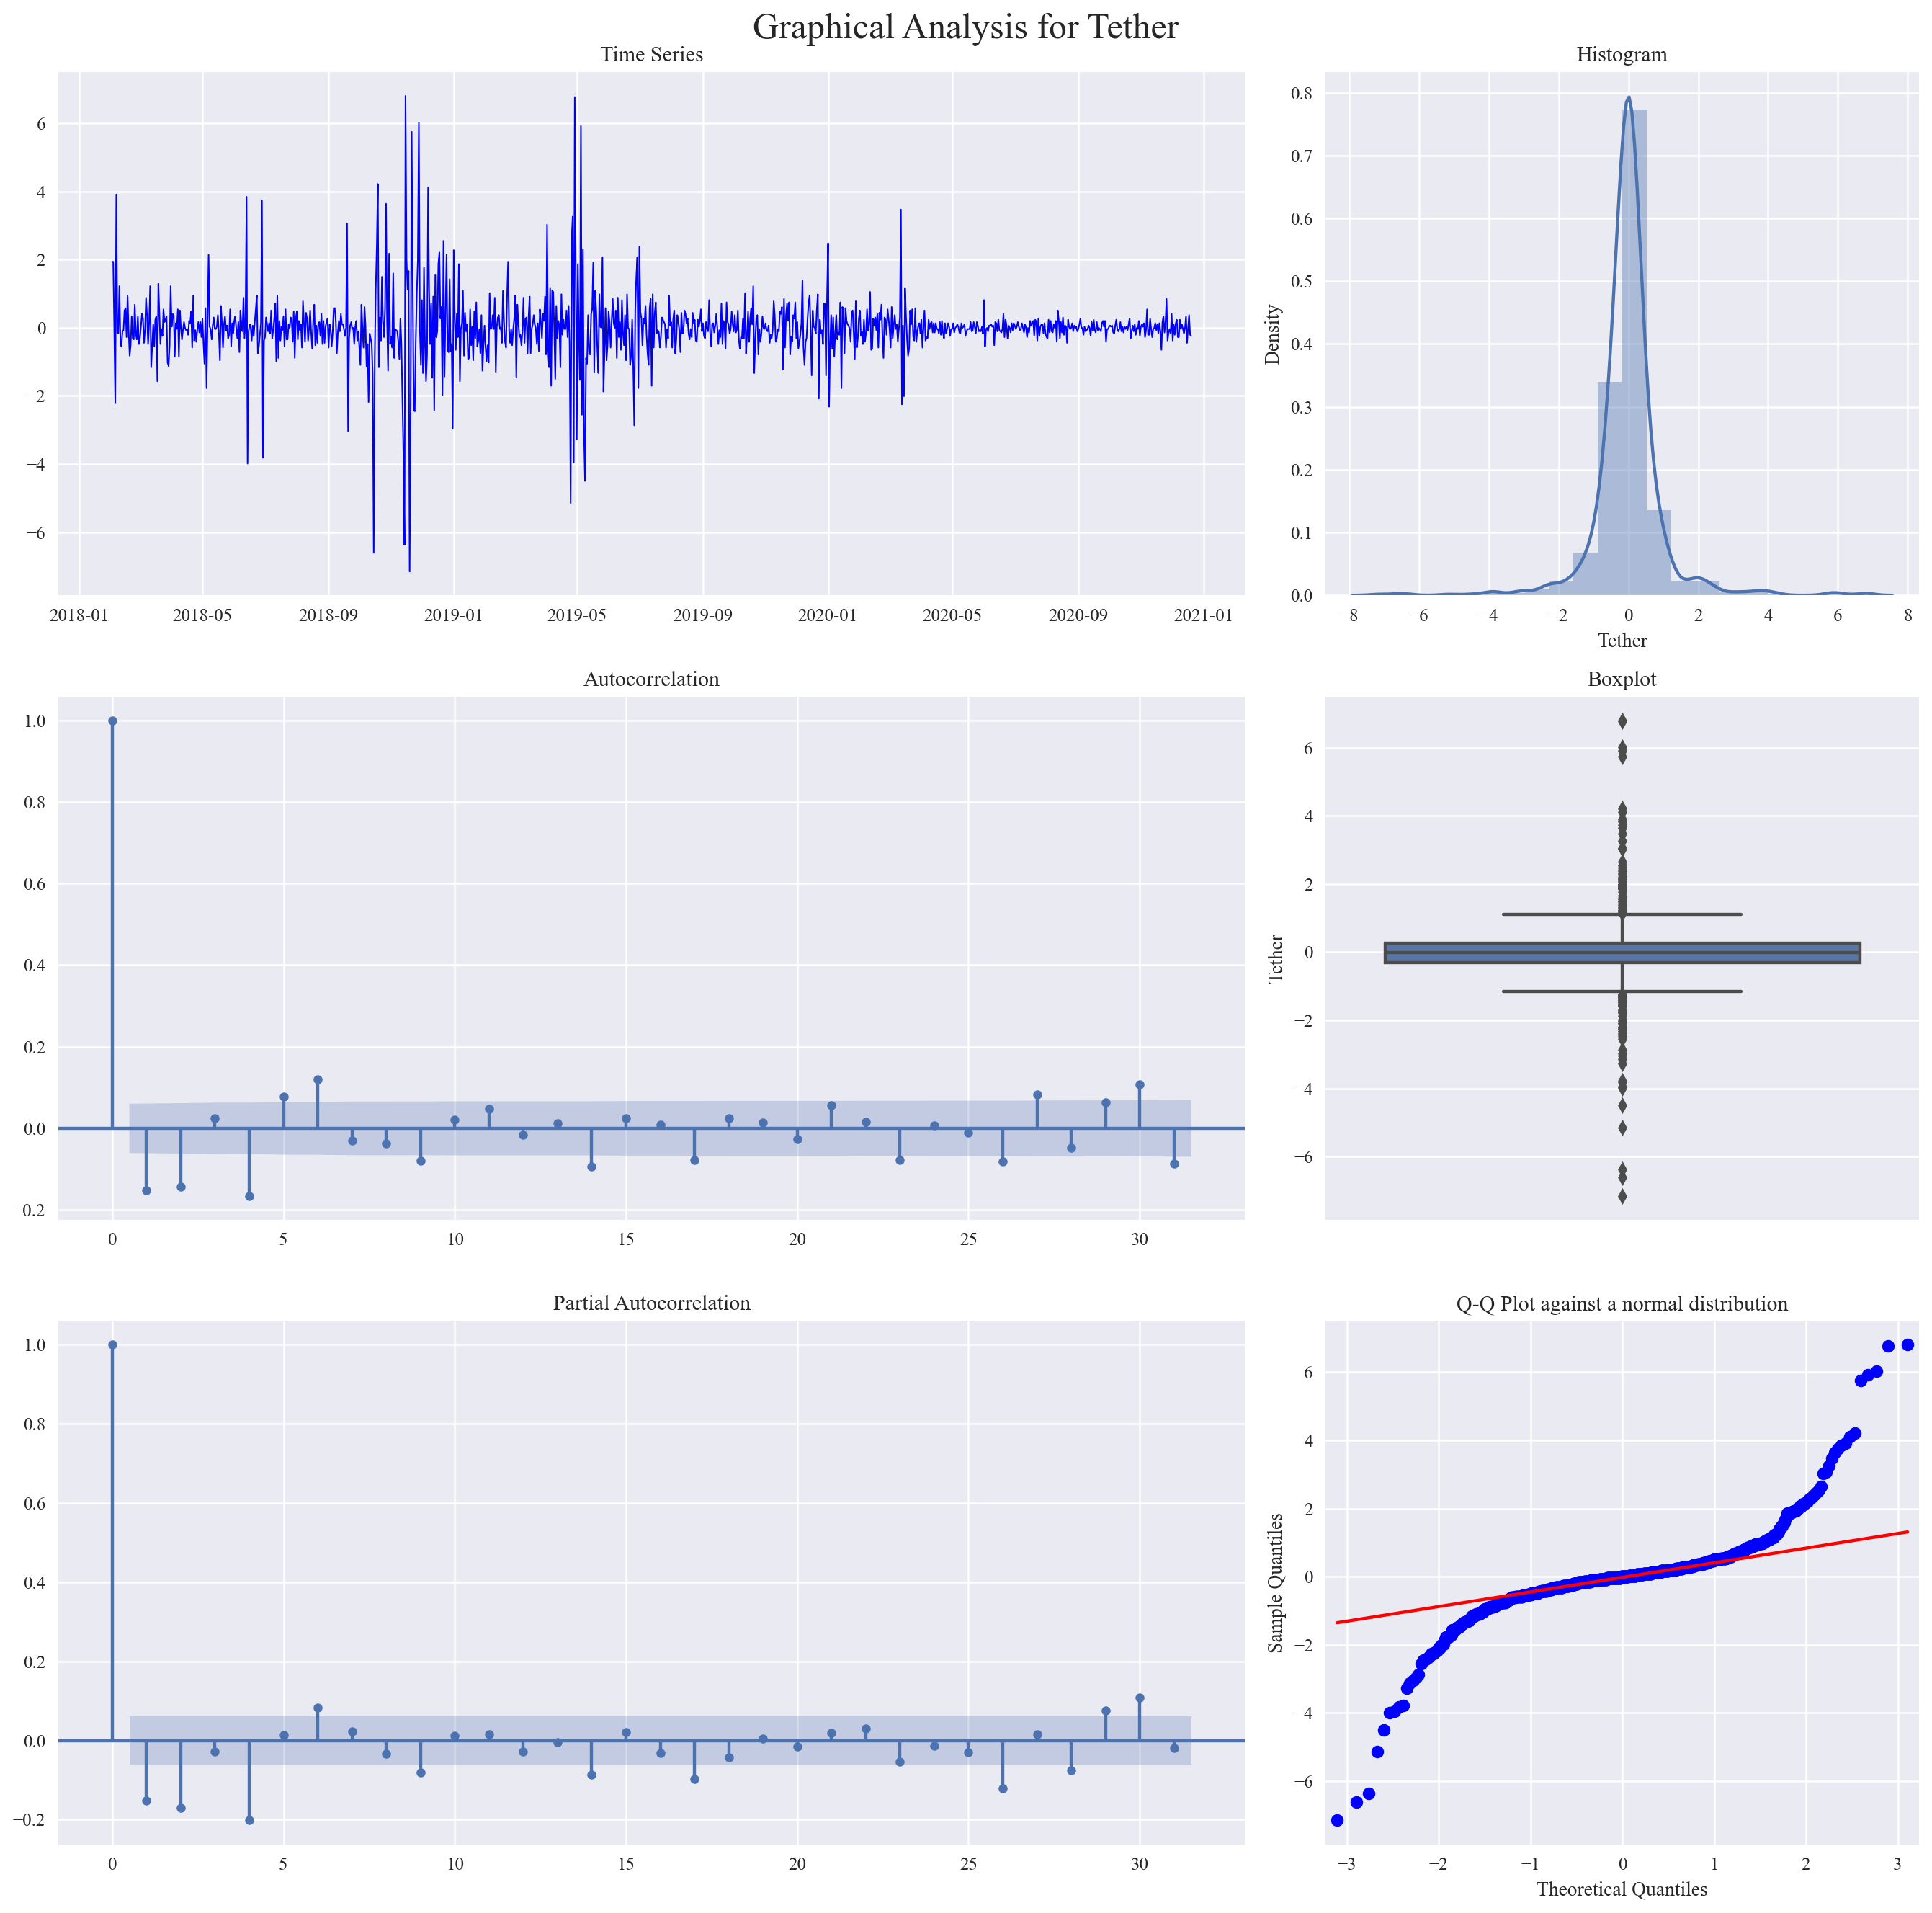

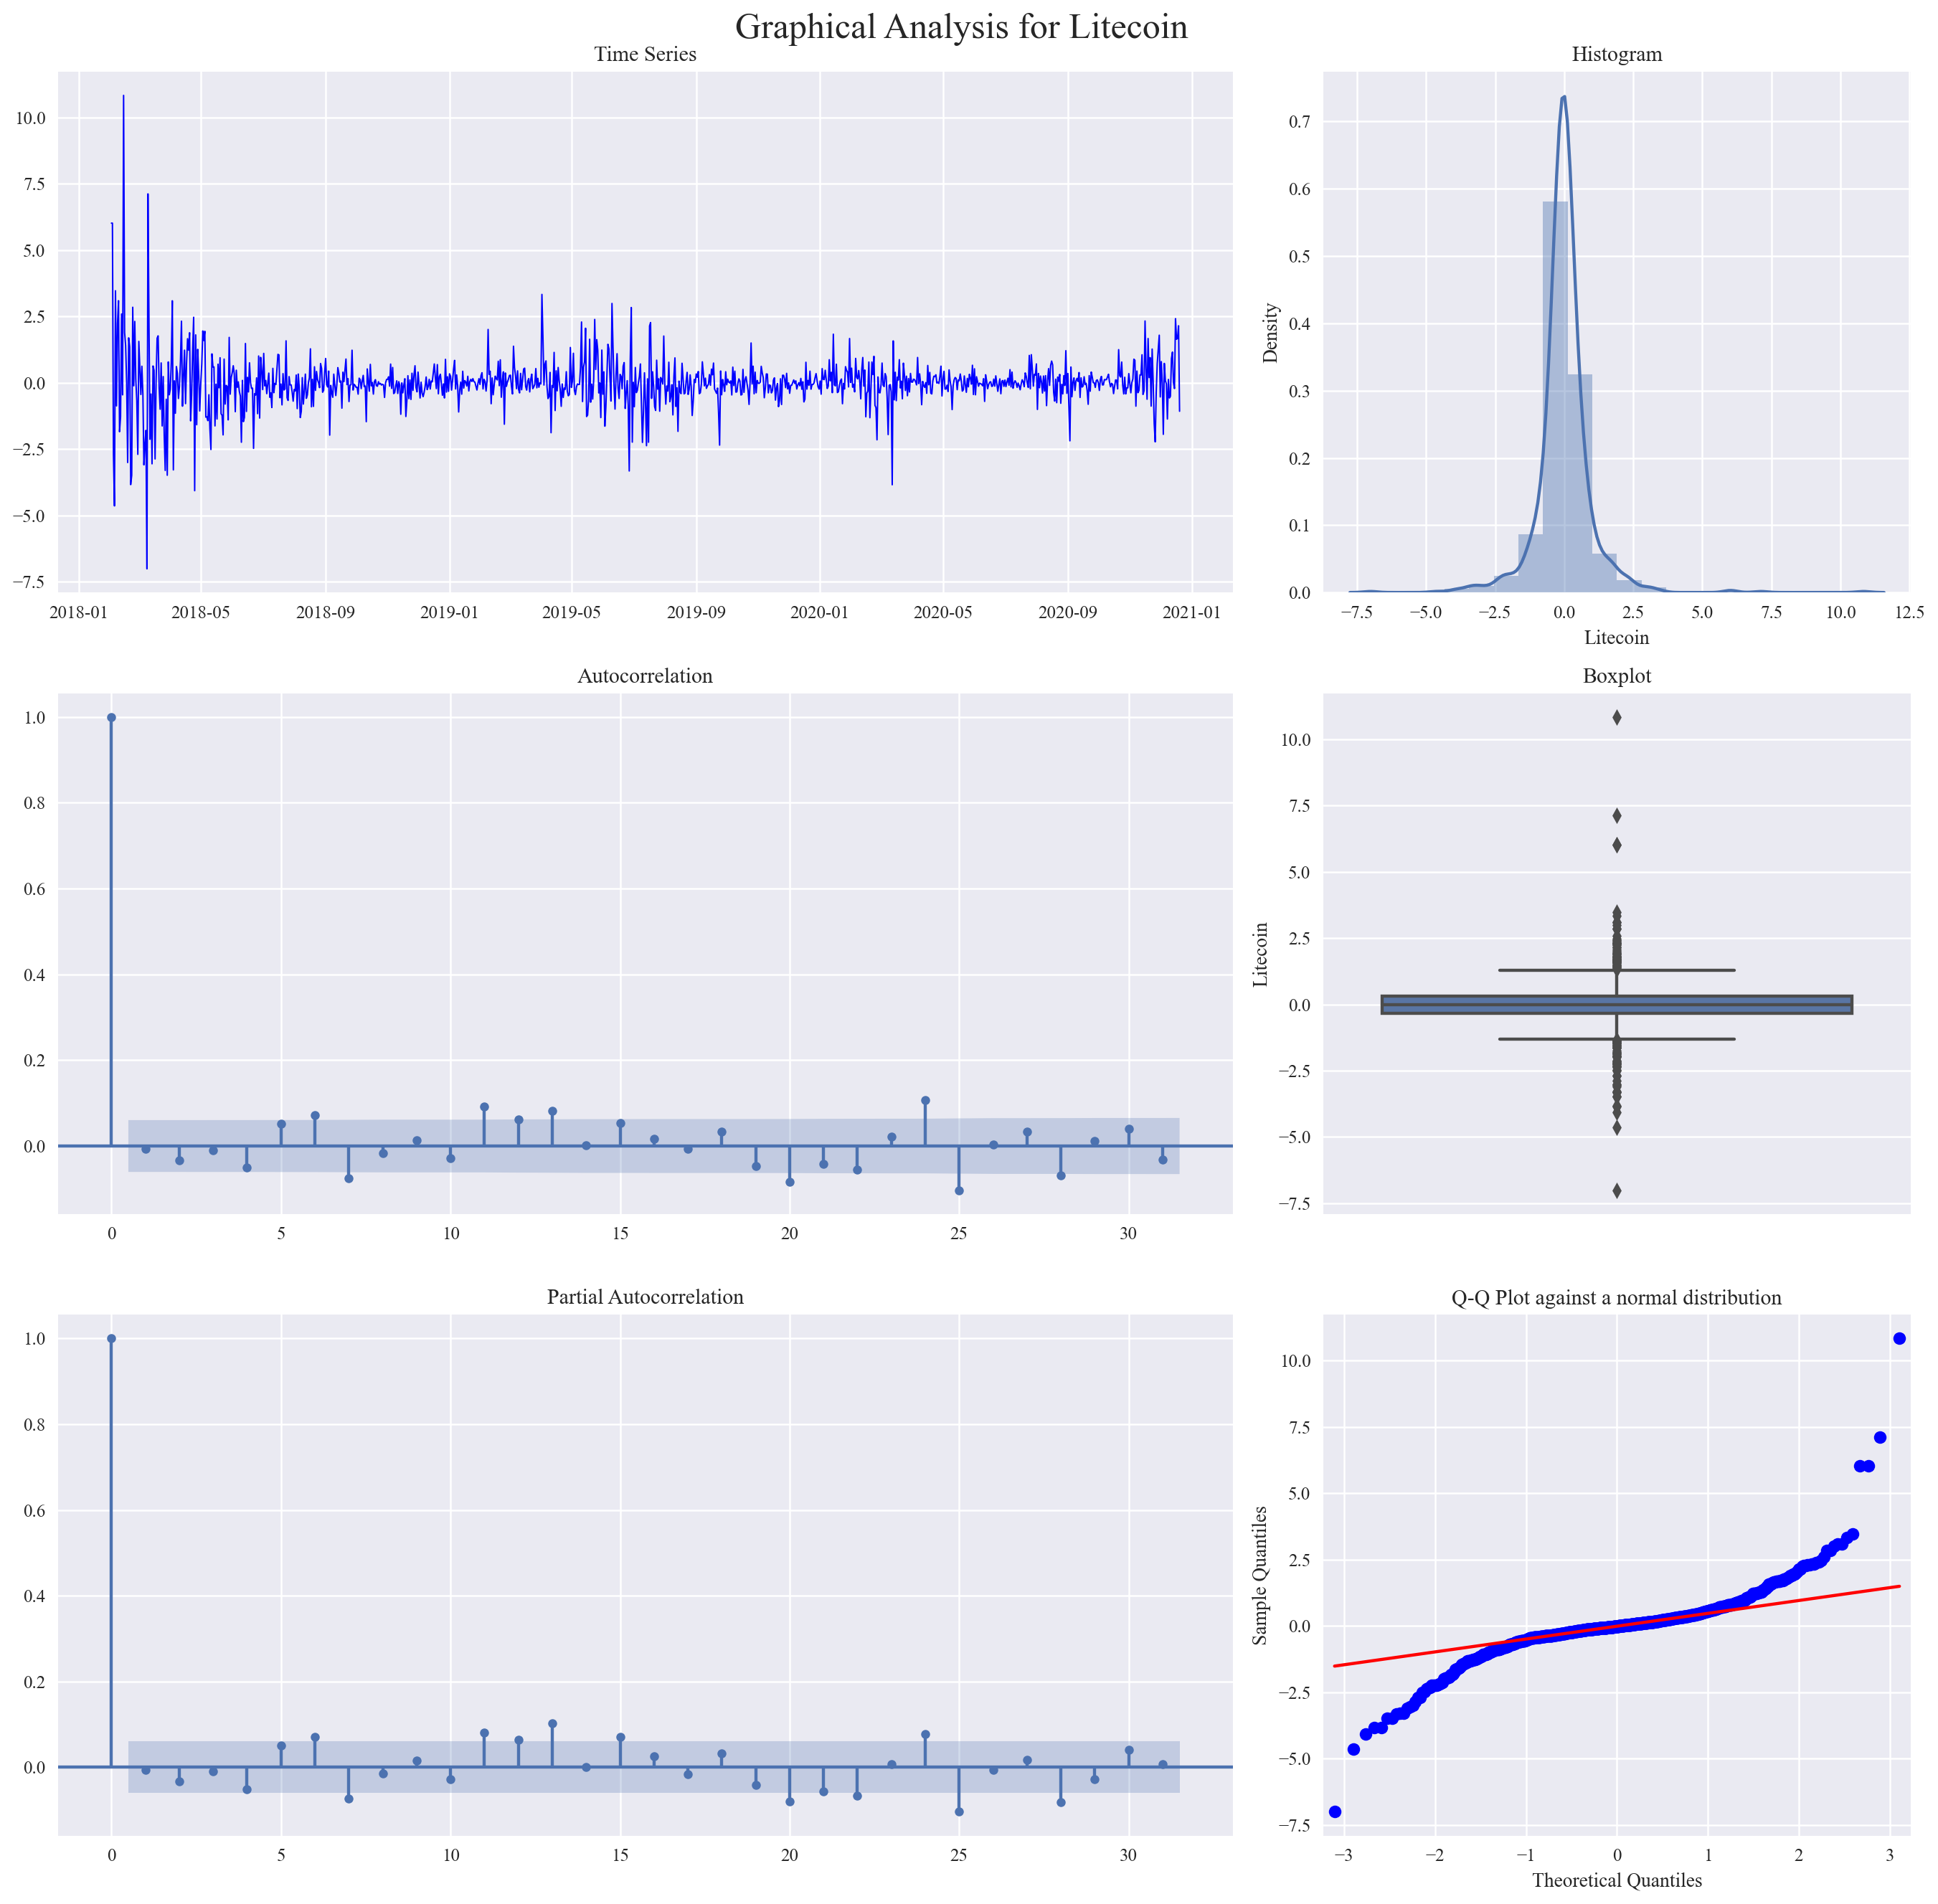

In [9]:
plot_graphics(standardDifferencedCrypto)

All of the standardised first differenced values have fat tails with a large amount of outliers, suggesting that a Normal distribution might be a bad fit for the returns. We shall confirm our hypothesis by performing the relevant statistical tests.

In [10]:
normality_checking(standardDifferencedCrypto)


--------------------------------------------

Checking Normality of Binance
Test Statistic : 2847.72, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Bitcoin
Test Statistic : 4198.81, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Cardano
Test Statistic : 23267.13, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of EOS
Test Statistic : 27298.68, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Chainlink
Test Statistic : 33993.47, p value : 0.00000
Data does not look Gaussian: we reject the Null Hypothesis

--------------------------------------------

Checking Normality of Ethereum
Test Statistic : 5685

In [11]:
stationary_checking(standardDifferencedCrypto)


--------------------------------------------

Checking Stationarity of Binance
Test Statistic : -12.27, p value : 0.00000
Data is Stationary for Binance

--------------------------------------------

Checking Stationarity of Bitcoin
Test Statistic : -6.10, p value : 0.00000
Data is Stationary for Bitcoin

--------------------------------------------

Checking Stationarity of Cardano
Test Statistic : -6.56, p value : 0.00000
Data is Stationary for Cardano

--------------------------------------------

Checking Stationarity of EOS
Test Statistic : -8.23, p value : 0.00000
Data is Stationary for EOS

--------------------------------------------

Checking Stationarity of Chainlink
Test Statistic : -8.15, p value : 0.00000
Data is Stationary for Chainlink

--------------------------------------------

Checking Stationarity of Ethereum
Test Statistic : -6.19, p value : 0.00000
Data is Stationary for Ethereum

--------------------------------------------

Checking Stationarity of Tether
Test

The standardised returns can be assumed to be stationary but not normally distributed. 
Foretunately for us, the RLM model does not require the variables to be normal in distribution.


### RLM Regression with Granger Causality

Please go ahead and have a look at the function.py file in the directory to see how I get the residuals of the RLM regression and how I choose the lag value as well as the Cryptocurrency pair.

In [12]:
results = get_residuals(standardDifferencedCrypto)

-----------------------------------------------------------------
Litecoin is most cointegrated with Bitcoin for the given timeframe
-----------------------------------------------------------------
---------------------------------------------------------------------
We have achieved a F-Statistic of 2.26 and p-value of 0.13272 with a Lag-order of 1 for Granger Causality
---------------------------------------------------------------------
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1052
Model:                            RLM   Df Residuals:                     1050
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Da

In [13]:

residuals = results["Residuals"]
regressParams = results["regressParams"]
bestPair = results["Best Pair"]
bestLag = results["Best Lag"]
residualStatistics = results["Residual Statistics"]
confidenceInterval = results["Confidence Interval"]


Theoritically, the residuals obtained from the regression should follow a random walk and no information should be extractable from them. Practially though, such a case is rarely seen in real life.
By plotting the residuals, we can clearly see some sort of pattern. 

I try to use a Fast Fourier Transform to remove the 'actual nosie' from the residuals by taking the top 10% of the frequencies.

In [14]:
residuals = remove_noise_by_fft(residuals, threshold=0.1)

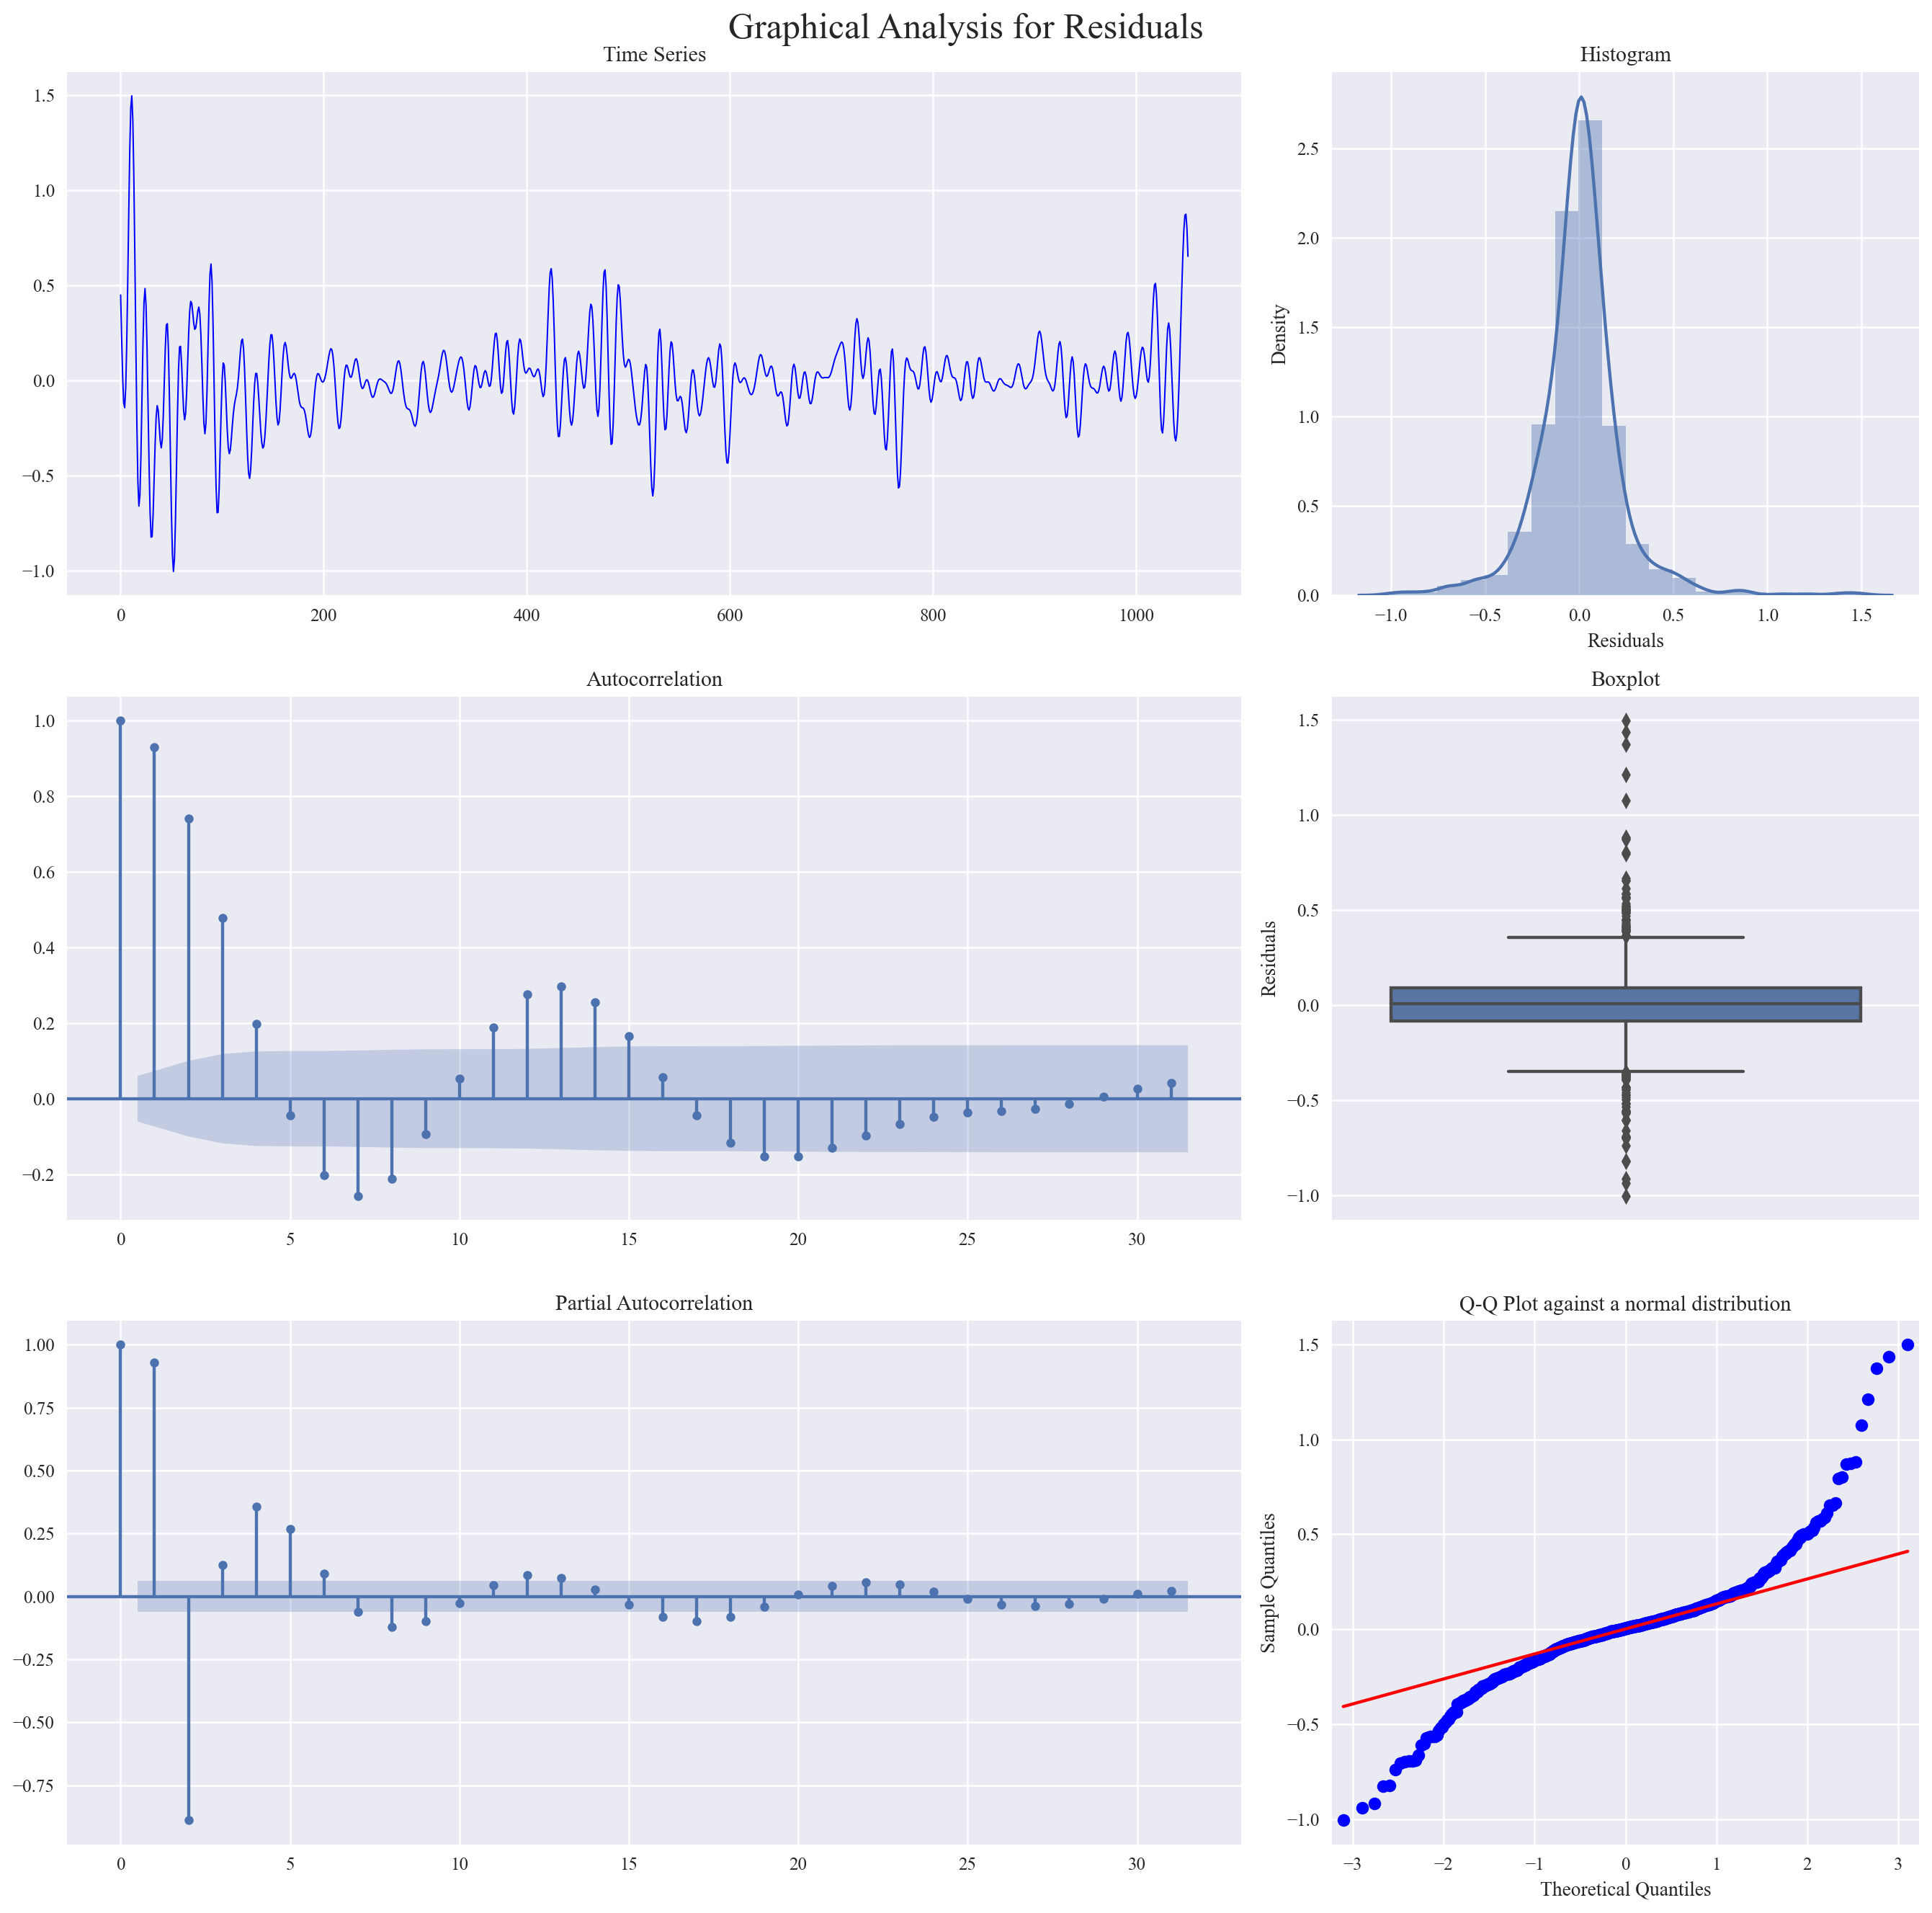

In [15]:
plot_graphics(pd.DataFrame(residuals, columns=["Residuals"]))

### LSTM Model

I feed the Fourier-transformed residuals into a Recurrent Neural Network with one LSTM layer with 2 fully connected Dense layers to try and forecast future residuals. We want to predict the residual value 3 days from now, using our current residual value. By taking a window size of 20, I ensure that the model has ample past values to learn a pattern from.

In [16]:

forecastHorizon = 3
windowSize = 20
X, Y = convert_to_window(
    residuals, windowSize=windowSize, forecastHorizon=forecastHorizon
)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [17]:

lstmInputData = standardDifferencedCrypto.iloc[
    : -bestLag - forecastHorizon - windowSize, :].copy()
trainSize = int(len(lstmInputData) * 0.8)
trainSetX = X[:trainSize]
trainSetY = Y[:trainSize]
testSetX = X[trainSize:]
testSetY = Y[trainSize:]

lstmTrainData = lstmInputData[:trainSize]
lstmTestData = lstmInputData[trainSize:]

model = create_simple_model(
    regressParams,
    X=lstmTrainData[bestPair[1]].values,
    Y=lstmTrainData[bestPair[0]].values,
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            4880      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                12832     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [18]:
history = model.fit(x=trainSetX, y=trainSetY, epochs=100, batch_size=32, verbose=False)

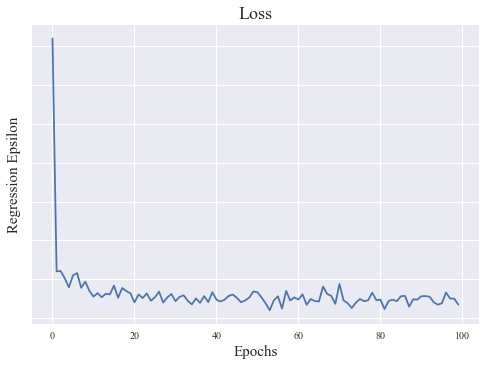

In [19]:

fig, ax = plt.subplots(1)
ax.set_title("Loss", size=18)
ax.plot(history.history["loss"])
ax.set_xlabel("Epochs", size=15)
ax.set_ylabel('Regression Epsilon', size=15)
ax.set_yticklabels([])
plt.show()


In [41]:
residualPredictions = model.predict(testSetX) * 300 + 8

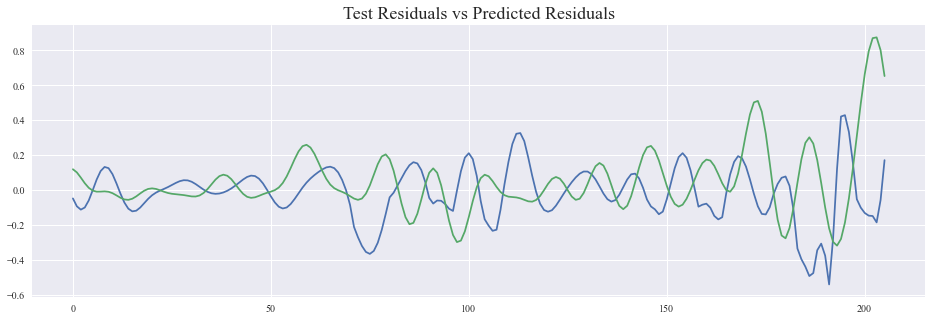

In [42]:

plt.figure(figsize=(16, 5))
plt.title("Test Residuals vs Predicted Residuals", size=18)
plt.plot(residualPredictions)
plt.plot(testSetY)
plt.show()

#green - actual
#blue - predicted value

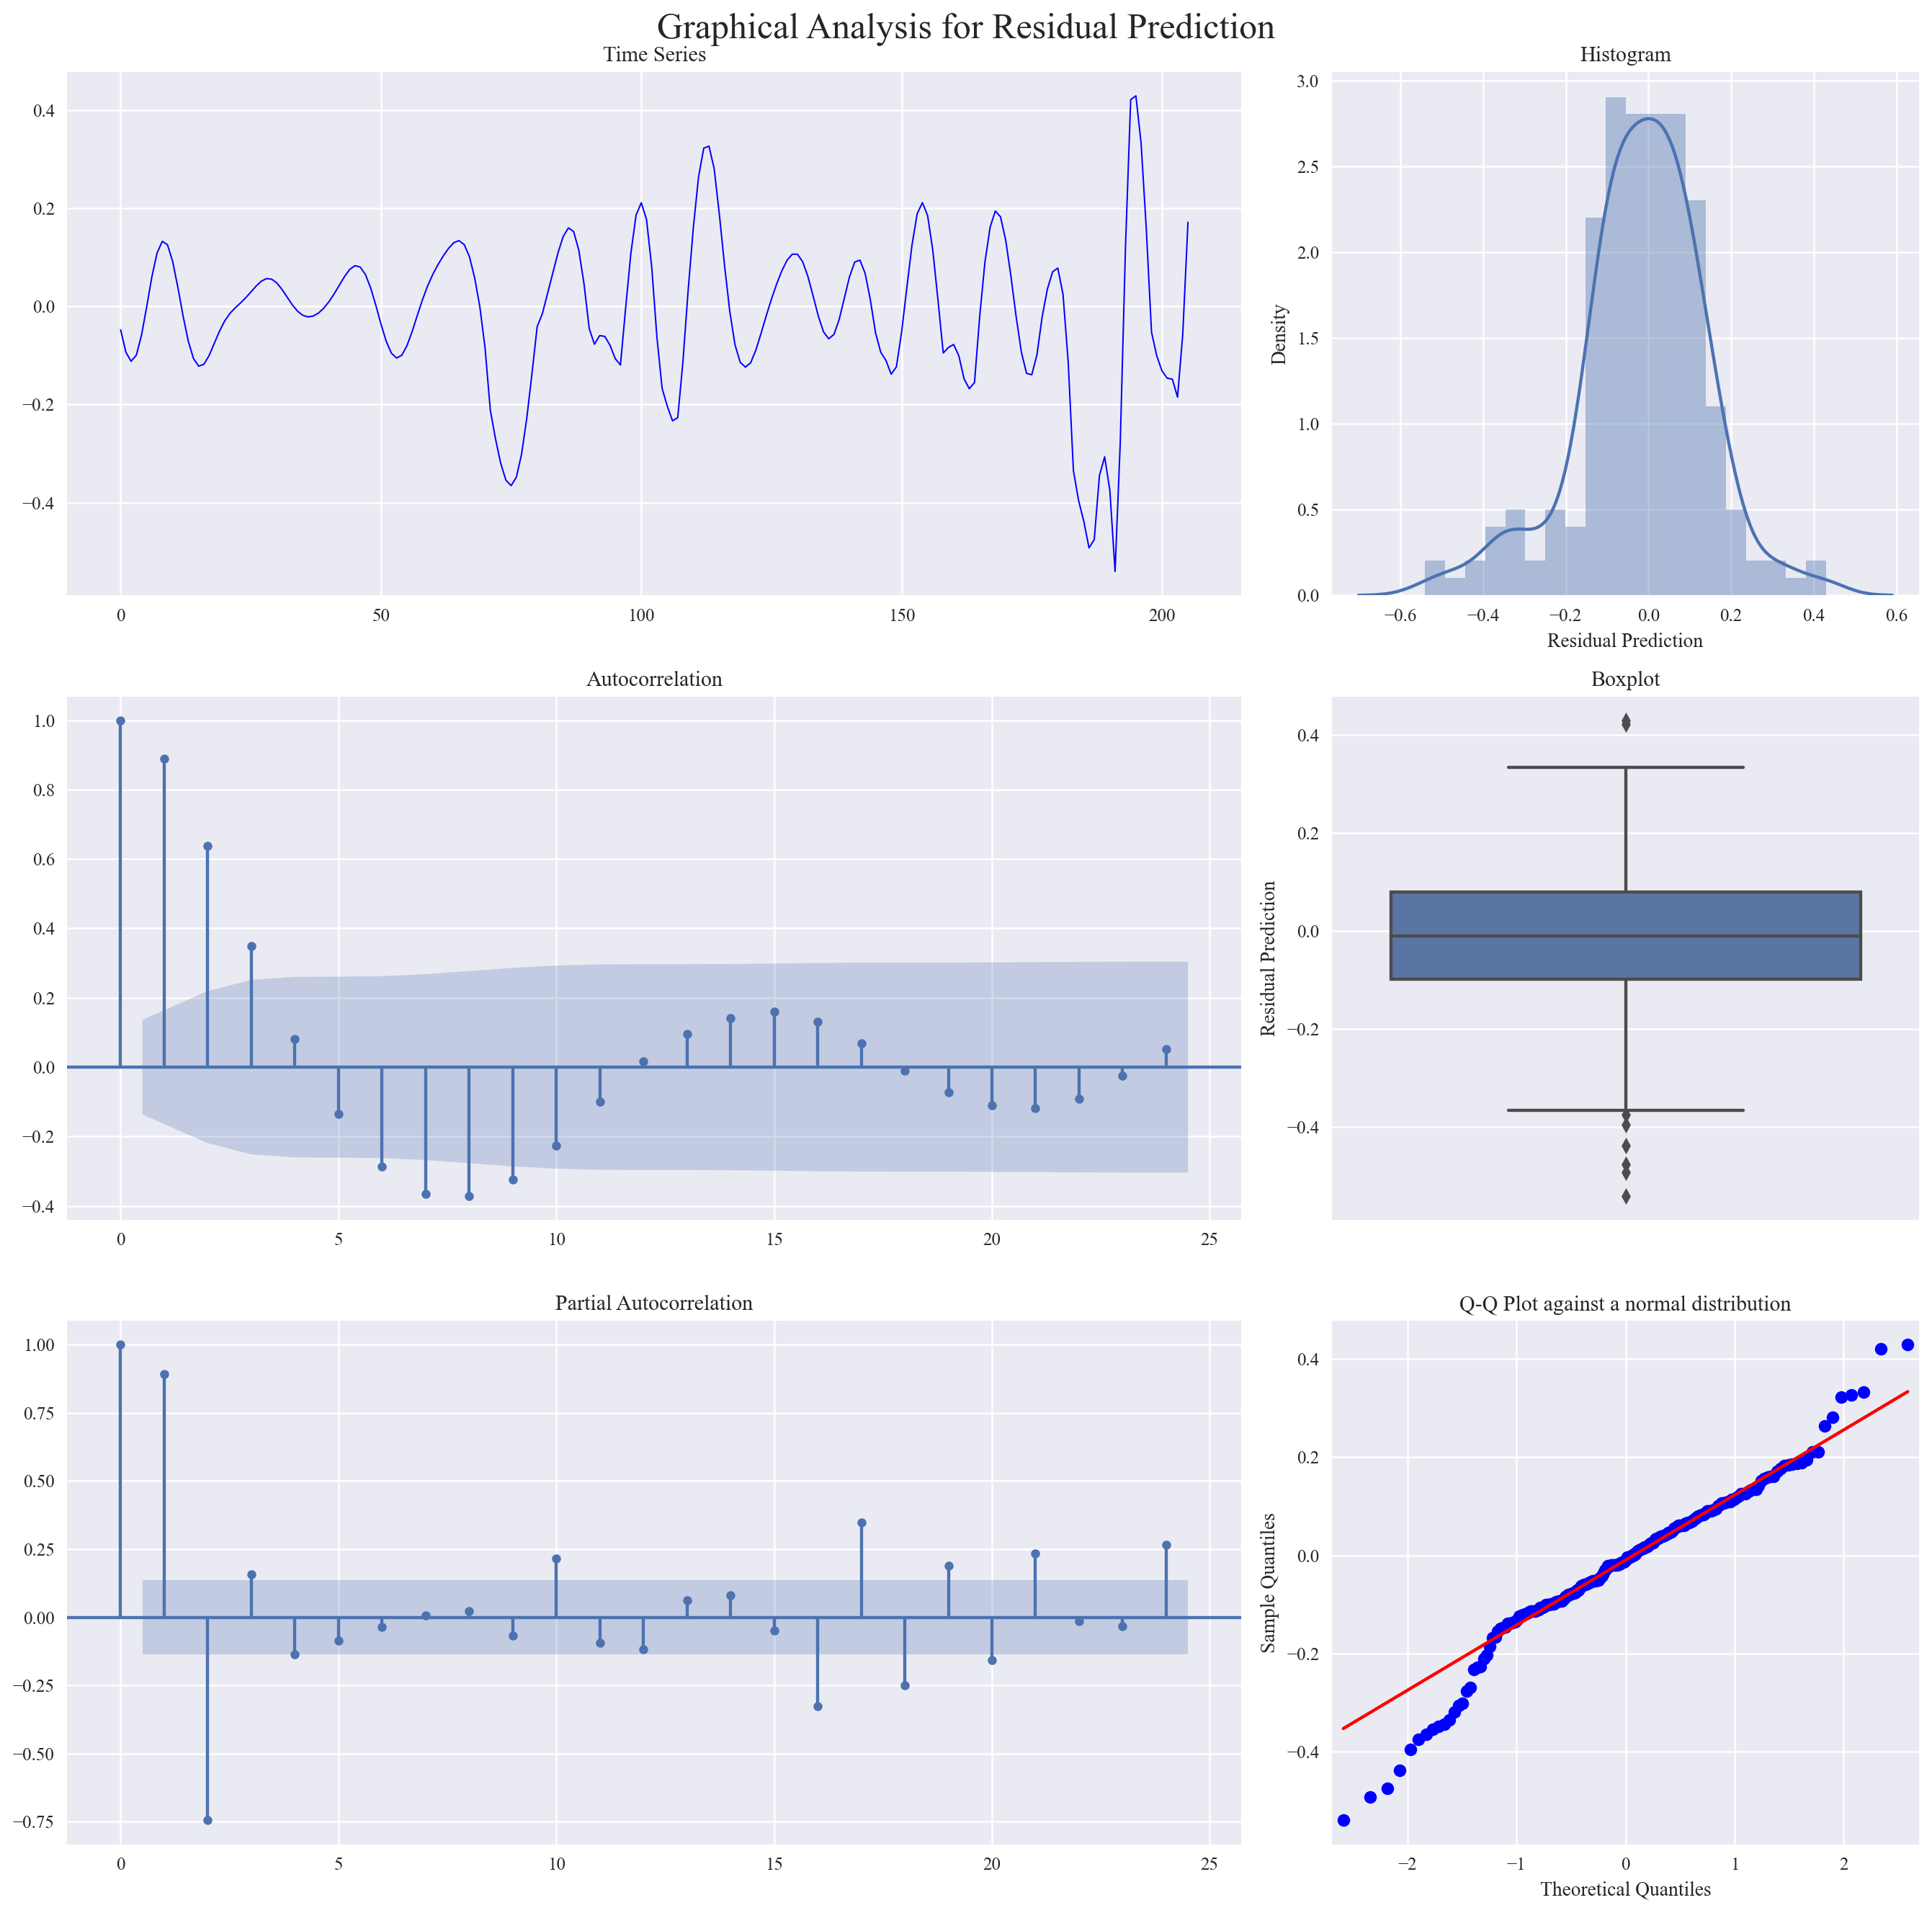

In [43]:
plot_graphics(pd.DataFrame(residualPredictions, columns=["Residual Prediction"]))

In [44]:

predictedMean = (
    np.add(
        regressParams[0],
        regressParams[1] * lstmTestData[bestPair[1]].values,
        residualPredictions.reshape(-1,),)* 20
)
upperInterval = (
    np.add(
        confidenceInterval[0, 1],
        confidenceInterval[1, 1] * lstmTestData[bestPair[1]].values,
        residualPredictions.reshape(-1,),)* 20
)
lowerInterval = (
    np.add(
        confidenceInterval[0, 0],
        confidenceInterval[1, 0] * lstmTestData[bestPair[1]].values,
        residualPredictions.reshape(-1,),)* 20
)


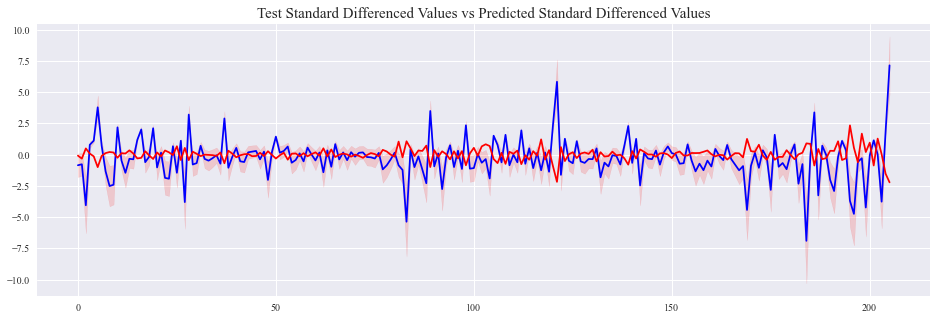

In [45]:

plt.figure(figsize=(16, 5))
plt.title(
    "Test Standard Differenced Values vs Predicted Standard Differenced Values", size=15
)
plt.plot(predictedMean, color="blue")
plt.plot(lstmTestData[bestPair[0]].values, color="red")
plt.fill_between(
    x=range(len(predictedMean)),
    y2=upperInterval,
    y1=lowerInterval,
    alpha=0.15,
    color="red",
)
plt.legend((predictedMean, lstmTestData[bestPair[0]].values), ('Forecast','True Values'))
plt.show()

#red - predicted value
#blue - actual value

In [46]:

testSet = crypto[bestPair[0]].iloc[: -bestLag - forecastHorizon - windowSize][
    trainSize:
]
predictedCryptoMean = inverse_transform(
                        predictedMean,
                        differencedCrypto[bestPair[0]],
                        testSet)
upperInterval = inverse_transform(
                        predictedMean,
                        differencedCrypto[bestPair[0]],
                        testSet)
lowerInterval = inverse_transform(
                        predictedMean,
                        differencedCrypto[bestPair[0]],
                        testSet)


In [47]:

predictedArray = pd.DataFrame(
    data={
        "Test_Data": testSet,
        "Prediction": predictedCryptoMean,
        "Confidence_Interval_1": upperInterval,
        "Confidence_Interval_2": lowerInterval,
    },
    index=lstmTestData.index,
)

predictedArray = predictedArray[1:]

In [48]:

MAPE = np.mean(
    (
        abs(predictedArray.Prediction.values - predictedArray.Test_Data.values)
        / predictedArray.Test_Data.values
    )[1:]
)
naiveForecast = predictedArray.Test_Data.shift(1).bfill()
naiveMAPE = np.mean(
    (
        abs(naiveForecast.values - predictedArray.Test_Data.values)
        / predictedArray.Test_Data.values
    )[1:]
)
rMAPE = MAPE / naiveMAPE


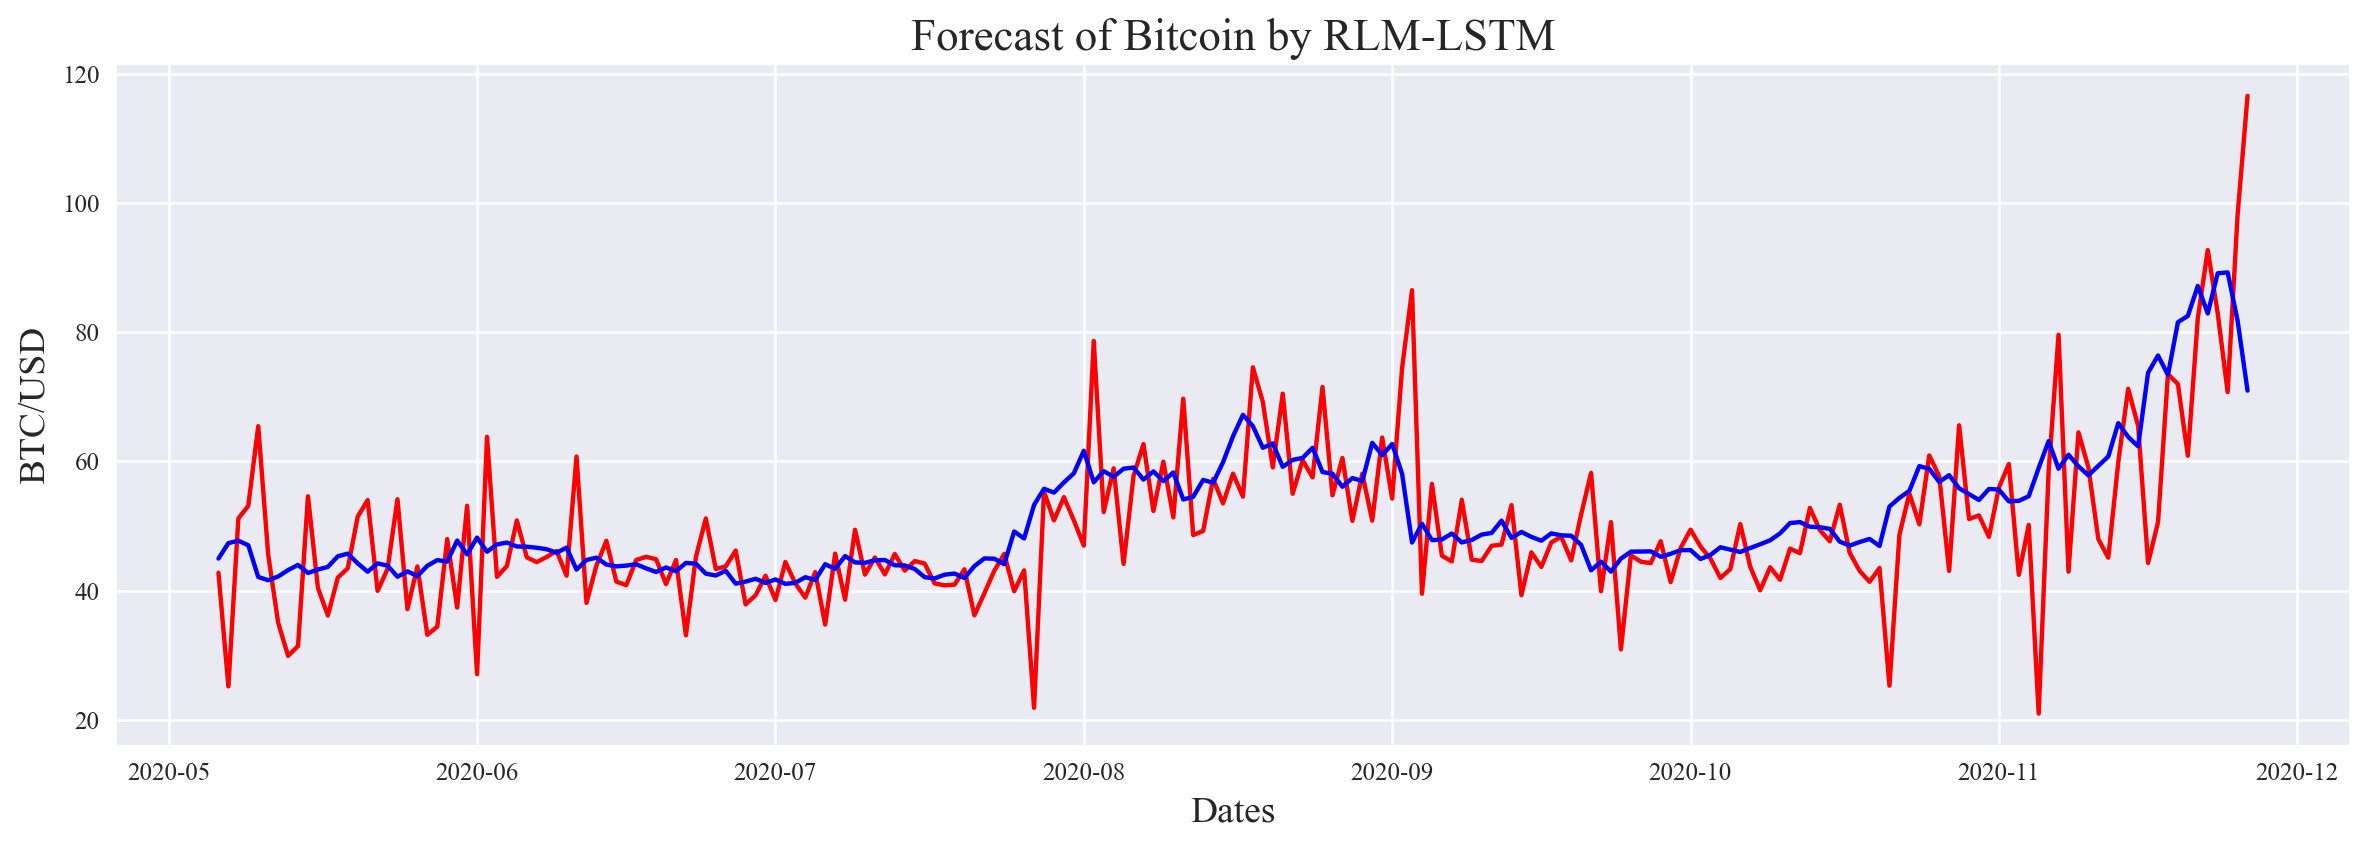


 	 	 	 	   ----------------- CONGRATULATIONS !! -----------------

	 	 	 	 The RLM-LSTM model has achieved an rMAPE of: 4.3254


In [49]:

plot_forecast(predictedArray, "RLM-LSTM")

print("\n \t \t \t \t   ----------------- CONGRATULATIONS !! -----------------\n")
print("\t \t \t \t The RLM-LSTM model has achieved an rMAPE of: {}".format(round(rMAPE, 4)))

#red - predicted value
#blue - actual value

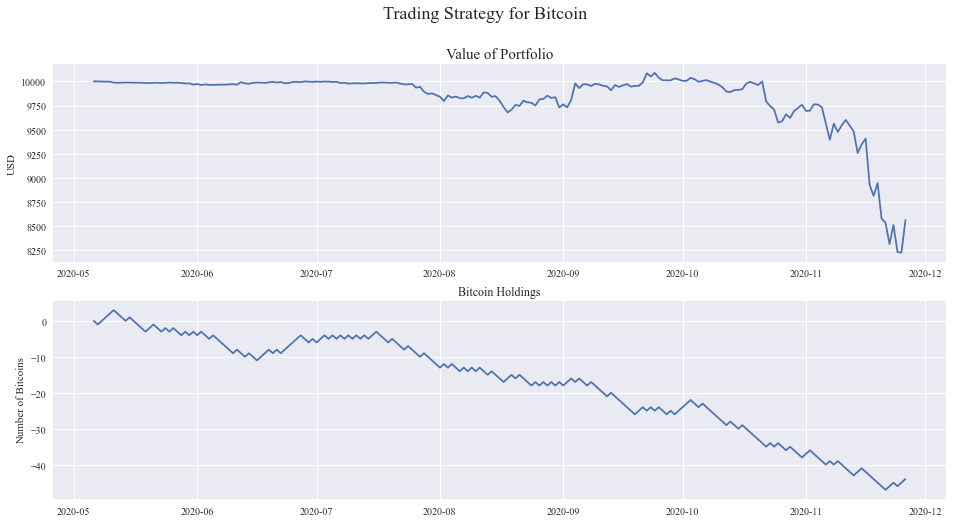

In [50]:
portfolioHoldings = trading(predictedArray)

In [51]:
printt(portfolioHoldings)

----------------------------------------------------------------------------------------------------
	 	 	 The value of your portfolio is 8563.08
	 	 	 You have achieved returns of -14.37%
----------------------------------------------------------------------------------------------------


### Please do let me know what else you'd like me to add